<a href="https://colab.research.google.com/github/Sushrut0202/CIIMS/blob/main/Integrated_AMR_data_analysis_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload HUMAN file


Saving Human Samples.xlsx to Human Samples (1).xlsx
Upload ANIMAL file


Saving Animal sample data.xlsx to Animal sample data (1).xlsx
Upload ENVIRONMENT file


Saving Enviormental Samples.xlsx to Enviormental Samples (1).xlsx


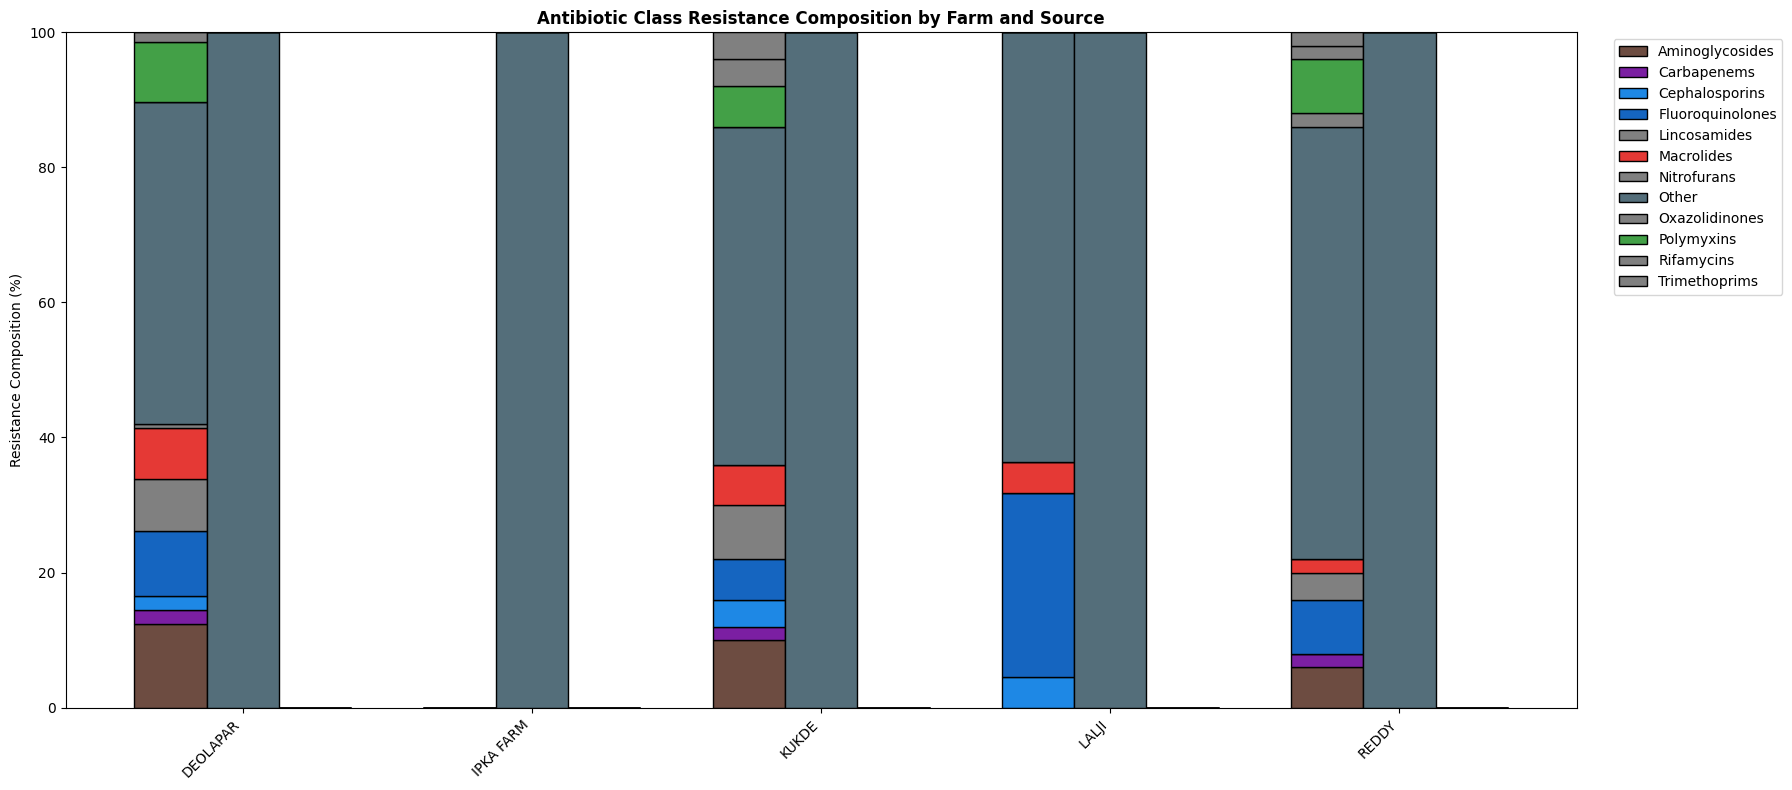

In [2]:
# ============================================================
# ONE HEALTH AMR PIPELINE
# Human + Animal (AST-validated) + Environment
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import io
from functools import lru_cache
from openpyxl import load_workbook
from google.colab import files

# ============================================================
# 1. FARM NORMALIZATION (GLOBAL)
# ============================================================

def canon(name):
    if name is None or pd.isna(name):
        return None

    name = str(name).upper()
    name = re.sub(r"[’'`]", "", name)
    name = re.sub(r"[^A-Z0-9 ]", " ", name)
    name = re.sub(r"\s+", " ", name).strip()

    if name in {"", "NAN", "RM2 1M", "RM2.1M", "R2 1M"}:
        return None
    if any(x in name for x in ["LALJI", "NVC", "MAFSU", "MELGHAT"]):
        return "LALJI"
    if "DEOLAPAR" in name:
        return "DEOLAPAR"
    if "KUKDE" in name:
        return "KUKDE"
    if "REDDY" in name:
        return "REDDY"

    return name


# ============================================================
# 2. ANTIBIOTIC CLASS MAPPING
# ============================================================

ABX_KEYWORD_TO_CLASS = {
    "AMIKACIN": "Aminoglycosides",
    "GENTAMICIN": "Aminoglycosides",
    "IMIPENEM": "Carbapenems",
    "MEROPENEM": "Carbapenems",
    "CEFTRIAXONE": "Cephalosporins",
    "CEFOTAXIME": "Cephalosporins",
    "CIPROFLOXACIN": "Fluoroquinolones",
    "LEVOFLOXACIN": "Fluoroquinolones",
    "AZITHROMYCIN": "Macrolides",
    "ERYTHROMYCIN": "Macrolides",
    "AMPICILLIN": "Penicillins",
    "AMOXICILLIN": "Penicillins",
    "VANCOMYCIN": "Glycopeptides",
    "COLISTIN": "Polymyxins",
    "TETRACYCLINE": "Tetracyclines",
    "CLINDAMYCIN": "Lincosamides",
    "LINEZOLID": "Oxazolidinones",
    "NITROFURANTOIN": "Nitrofurans",
    "RIFAMPICIN": "Rifamycins",
    "TRIMETHOPRIM": "Trimethoprims",
    "AZTREONAM": "Monobactams",
}

@lru_cache(maxsize=None)
def build_abx_regex():
    return [(re.compile(rf"\b{re.escape(k)}\b"), v)
            for k, v in ABX_KEYWORD_TO_CLASS.items()]

def assign_class(ab):
    ab = str(ab).upper()
    for pat, cls in build_abx_regex():
        if pat.search(ab):
            return cls
    return "Other"


# ============================================================
# 3. HUMAN + ENVIRONMENT LOADER
# ============================================================

def load_and_fix_excel(file_bytes, source, start_idx=15, end_idx=50):
    df = pd.read_excel(io.BytesIO(file_bytes))
    abx_row = df.iloc[0, start_idx:end_idx + 1]
    cols = list(df.columns)
    cols[start_idx:end_idx + 1] = abx_row.tolist()
    df.columns = cols
    df = df.drop(index=0).reset_index(drop=True)
    df["Source"] = source
    return df


# ============================================================
# 4. ANIMAL AST VALIDATED PREPROCESSOR
# ============================================================

def ast_from_fill(cell):
    fill = cell.fill
    if not fill or not fill.start_color:
        return np.nan
    rgb = fill.start_color.rgb
    if rgb is None:
        return np.nan
    if not isinstance(rgb, str):
        rgb = str(rgb)
    rgb = rgb.upper()
    if rgb.startswith("FFFF"):
        return "R"
    if rgb.startswith("FFEB") or rgb.startswith("FFFFFF00"):
        return "S"
    return np.nan


def preprocess_animal_amr(file_bytes):
    wb = load_workbook(io.BytesIO(file_bytes), data_only=True)
    ws = wb.active
    headers = [c.value for c in ws[1]]

    sample_col = headers.index("Sample Code") + 1
    farm_col = headers.index("Farm Name") + 1
    esk_col = next(i+1 for i,h in enumerate(headers) if h and "ESKAPE" in str(h))
    pcr_col = next(i+1 for i,h in enumerate(headers) if h and "PCR" in str(h))
    abx_cols = list(range(pcr_col + 1, len(headers) + 1))

    records = []
    cur_sample, cur_farm = None, None

    for r in range(2, ws.max_row + 1):
        if ws.cell(r, sample_col).value:
            cur_sample = ws.cell(r, sample_col).value
        if ws.cell(r, farm_col).value:
            cur_farm = ws.cell(r, farm_col).value

        org = ws.cell(r, esk_col).value
        pcr = ws.cell(r, pcr_col).value
        if not (org and pcr):
            continue

        farm = canon(cur_farm)
        if not farm:
            continue

        for c in abx_cols:
            abx = headers[c - 1]
            status = ast_from_fill(ws.cell(r, c))
            if pd.isna(status):
                continue

            records.append({
                "Location": farm,
                "Source": "Animal",
                "Antibiotic": abx,
                "Resistance Status": status
            })

    return pd.DataFrame(records)


# ============================================================
# 5. COMPOSITION CALCULATION
# ============================================================

def calculate_composition(all_data, start_idx=15, end_idx=50):
    records = []

    # -------------------------
    # HUMAN + ENVIRONMENT
    # -------------------------
    he = all_data[all_data["Source"].isin(["Human", "Environment"])].copy()

    if not he.empty:
        abx = he.iloc[:, start_idx:end_idx + 1].astype(str).apply(
            lambda x: x.str.strip().str.upper()
        )

        loc_col = "Farm Name" if "Farm Name" in he.columns else "Sample Code"

        base = pd.concat([he[loc_col], he["Source"], abx], axis=1)

        long = base.melt(
            id_vars=[loc_col, "Source"],
            var_name="Antibiotic",
            value_name="Resistance Status",
        )

        long["Resistance Status"] = (
            long["Resistance Status"]
            .replace({"RESISTANT": "R"})
            .str.upper()
        )

        long["Location"] = long[loc_col].apply(canon)

        long = long[
            (long["Resistance Status"] == "R") &
            (long["Location"].notna())
        ]

        records.append(
            long[["Location", "Source", "Antibiotic", "Resistance Status"]]
        )

    # -------------------------
    # ANIMAL (already long)
    # -------------------------
    animal = all_data[all_data["Source"] == "Animal"].copy()
    if not animal.empty:
        records.append(
            animal[["Location", "Source", "Antibiotic", "Resistance Status"]]
        )

    # -------------------------
    # COMBINE
    # -------------------------
    df = pd.concat(records, ignore_index=True)

    df["Antibiotic Class"] = df["Antibiotic"].apply(assign_class)

    counts = (
        df.groupby(["Location", "Source", "Antibiotic Class"])
        .size()
        .reset_index(name="Count")
    )

    totals = (
        counts.groupby(["Location", "Source"])["Count"]
        .sum()
        .reset_index(name="Total")
    )

    out = counts.merge(totals, on=["Location", "Source"])
    out["Percent"] = out["Count"] / out["Total"] * 100

    return out



# ============================================================
# 6. PLOTTING
# ============================================================

CLASS_COLORS = {
    "Aminoglycosides": "#6D4C41",
    "Carbapenems": "#7B1FA2",
    "Cephalosporins": "#1E88E5",
    "Fluoroquinolones": "#1565C0",
    "Macrolides": "#E53935",
    "Penicillins": "#C2185B",
    "Glycopeptides": "#F4511E",
    "Polymyxins": "#43A047",
    "Tetracyclines": "#9E9D24",
    "Other": "#546E7A",
}

def plot_composition(df, title):
    farms = sorted(df["Location"].unique())
    sources = ["Human", "Animal", "Environment"]
    classes = sorted(df["Antibiotic Class"].unique())

    x = np.arange(len(farms))
    bw = 0.25

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))
        for cls in classes:
            vals = [
                df.loc[
                    (df["Location"] == f) &
                    (df["Source"] == src) &
                    (df["Antibiotic Class"] == cls),
                    "Percent"
                ].sum()
                for f in farms
            ]

            ax.bar(
                x + i*bw, vals, bw,
                bottom=bottom,
                color=CLASS_COLORS.get(cls, "gray"),
                edgecolor="black",
                label=cls if i == 0 else ""
            )

            bottom += np.array(vals)

    ax.set_xticks(x + bw)
    ax.set_xticklabels(farms, rotation=45, ha="right")
    ax.set_ylim(0, 100)
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_title(title, fontweight="bold")

    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


# ============================================================
# 7. MAIN
# ============================================================

print("Upload HUMAN file")
human_up = files.upload()
human_df = load_and_fix_excel(human_up[list(human_up.keys())[0]], "Human")

print("Upload ANIMAL file")
animal_up = files.upload()
animal_df = preprocess_animal_amr(animal_up[list(animal_up.keys())[0]])

print("Upload ENVIRONMENT file")
env_up = files.upload()
env_df = load_and_fix_excel(env_up[list(env_up.keys())[0]], "Environment")

all_data = pd.concat([human_df, animal_df, env_df], ignore_index=True)

composition = calculate_composition(all_data)

plot_composition(
    composition,
    "Antibiotic Class Resistance Composition by Farm and Source"
)


Upload HUMAN file


Saving Human Samples.xlsx to Human Samples (2).xlsx
Upload ANIMAL file


Saving Animal sample data.xlsx to Animal sample data (2).xlsx
Upload ENVIRONMENT file


Saving Enviormental Samples.xlsx to Enviormental Samples (2).xlsx


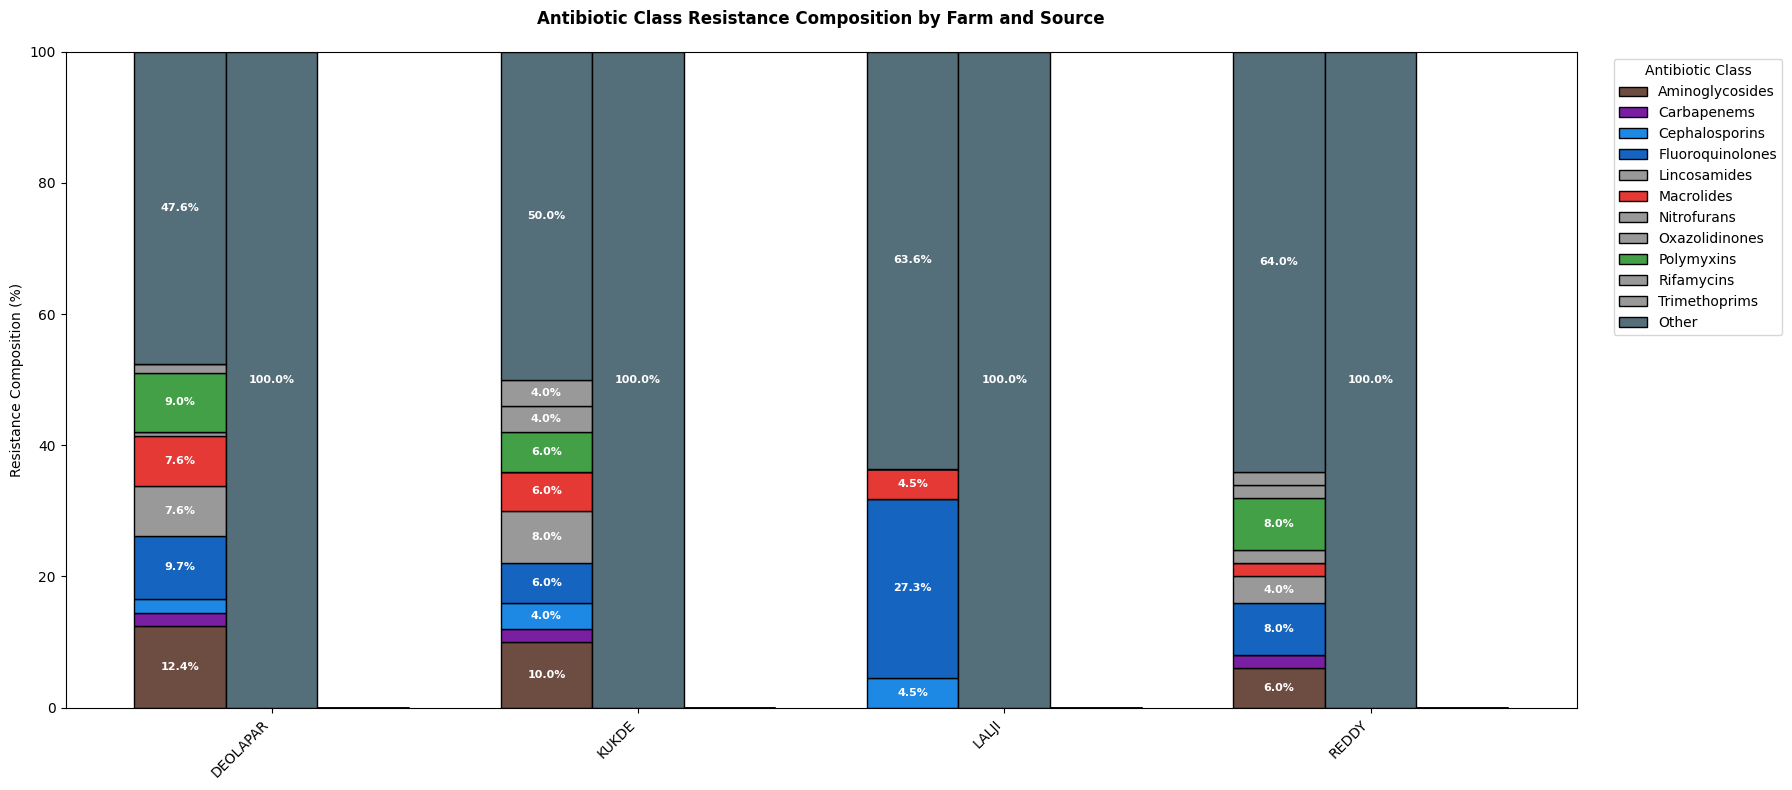

In [3]:
# ============================================================
# ONE HEALTH AMR PIPELINE
# Human + Animal (AST-validated) + Environment
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import io
from functools import lru_cache
from openpyxl import load_workbook
from google.colab import files

# ============================================================
# 1. FARM NORMALIZATION (GLOBAL)
# ============================================================

def canon(name):
    if name is None or pd.isna(name):
        return None

    name = str(name).upper()
    name = re.sub(r"[’'`]", "", name)
    name = re.sub(r"[^A-Z0-9 ]", " ", name)
    name = re.sub(r"\s+", " ", name).strip()

    if name in {"", "NAN", "RM2 1M", "RM2.1M", "R2 1M"}:
        return None
    if any(x in name for x in ["LALJI", "NVC", "MAFSU", "MELGHAT"]):
        return "LALJI"
    if "DEOLAPAR" in name:
        return "DEOLAPAR"
    if "KUKDE" in name:
        return "KUKDE"
    if "REDDY" in name:
        return "REDDY"

    return name


# ============================================================
# 2. ANTIBIOTIC CLASS MAPPING
# ============================================================

ABX_KEYWORD_TO_CLASS = {
    "AMIKACIN": "Aminoglycosides",
    "GENTAMICIN": "Aminoglycosides",
    "IMIPENEM": "Carbapenems",
    "MEROPENEM": "Carbapenems",
    "CEFTRIAXONE": "Cephalosporins",
    "CEFOTAXIME": "Cephalosporins",
    "CIPROFLOXACIN": "Fluoroquinolones",
    "LEVOFLOXACIN": "Fluoroquinolones",
    "AZITHROMYCIN": "Macrolides",
    "ERYTHROMYCIN": "Macrolides",
    "AMPICILLIN": "Penicillins",
    "AMOXICILLIN": "Penicillins",
    "VANCOMYCIN": "Glycopeptides",
    "COLISTIN": "Polymyxins",
    "TETRACYCLINE": "Tetracyclines",
    "CLINDAMYCIN": "Lincosamides",
    "LINEZOLID": "Oxazolidinones",
    "NITROFURANTOIN": "Nitrofurans",
    "RIFAMPICIN": "Rifamycins",
    "TRIMETHOPRIM": "Trimethoprims",
    "AZTREONAM": "Monobactams",
}

@lru_cache(maxsize=None)
def build_abx_regex():
    return [(re.compile(rf"\b{re.escape(k)}\b"), v)
            for k, v in ABX_KEYWORD_TO_CLASS.items()]

def assign_class(ab):
    ab = str(ab).upper()
    for pat, cls in build_abx_regex():
        if pat.search(ab):
            return cls
    return "Other"


# ============================================================
# 3. HUMAN + ENVIRONMENT LOADER
# ============================================================

def load_and_fix_excel(file_bytes, source, start_idx=15, end_idx=50):
    df = pd.read_excel(io.BytesIO(file_bytes))
    abx_row = df.iloc[0, start_idx:end_idx + 1]
    cols = list(df.columns)
    cols[start_idx:end_idx + 1] = abx_row.tolist()
    df.columns = cols
    df = df.drop(index=0).reset_index(drop=True)
    df["Source"] = source
    return df


# ============================================================
# 4. ANIMAL AST VALIDATED PREPROCESSOR
# ============================================================

def ast_from_fill(cell):
    fill = cell.fill
    if not fill or not fill.start_color:
        return np.nan
    rgb = fill.start_color.rgb
    if rgb is None:
        return np.nan
    if not isinstance(rgb, str):
        rgb = str(rgb)
    rgb = rgb.upper()
    if rgb.startswith("FFFF"):
        return "R"
    if rgb.startswith("FFEB") or rgb.startswith("FFFFFF00"):
        return "S"
    return np.nan


def preprocess_animal_amr(file_bytes):
    wb = load_workbook(io.BytesIO(file_bytes), data_only=True)
    ws = wb.active
    headers = [c.value for c in ws[1]]

    sample_col = headers.index("Sample Code") + 1
    farm_col = headers.index("Farm Name") + 1
    esk_col = next(i+1 for i,h in enumerate(headers) if h and "ESKAPE" in str(h))
    pcr_col = next(i+1 for i,h in enumerate(headers) if h and "PCR" in str(h))
    abx_cols = list(range(pcr_col + 1, len(headers) + 1))

    records = []
    cur_sample, cur_farm = None, None

    for r in range(2, ws.max_row + 1):
        if ws.cell(r, sample_col).value:
            cur_sample = ws.cell(r, sample_col).value
        if ws.cell(r, farm_col).value:
            cur_farm = ws.cell(r, farm_col).value

        org = ws.cell(r, esk_col).value
        pcr = ws.cell(r, pcr_col).value
        if not (org and pcr):
            continue

        farm = canon(cur_farm)
        if not farm:
            continue

        for c in abx_cols:
            abx = headers[c - 1]
            status = ast_from_fill(ws.cell(r, c))
            if pd.isna(status):
                continue

            records.append({
                "Location": farm,
                "Source": "Animal",
                "Antibiotic": abx,
                "Resistance Status": status
            })

    return pd.DataFrame(records)


# ============================================================
# 5. COMPOSITION CALCULATION
# ============================================================

def calculate_composition(all_data, start_idx=15, end_idx=50):
    records = []

    # -------------------------
    # HUMAN + ENVIRONMENT
    # -------------------------
    he = all_data[all_data["Source"].isin(["Human", "Environment"])].copy()

    if not he.empty:
        abx = he.iloc[:, start_idx:end_idx + 1].astype(str).apply(
            lambda x: x.str.strip().str.upper()
        )

        loc_col = "Farm Name" if "Farm Name" in he.columns else "Sample Code"

        base = pd.concat([he[loc_col], he["Source"], abx], axis=1)

        long = base.melt(
            id_vars=[loc_col, "Source"],
            var_name="Antibiotic",
            value_name="Resistance Status",
        )

        long["Resistance Status"] = (
            long["Resistance Status"]
            .replace({"RESISTANT": "R"})
            .str.upper()
        )

        long["Location"] = long[loc_col].apply(canon)

        long = long[
            (long["Resistance Status"] == "R") &
            (long["Location"].notna()) &
            (long["Location"] != "IPKA FARM")
        ]

        records.append(
            long[["Location", "Source", "Antibiotic", "Resistance Status"]]
        )

    # -------------------------
    # ANIMAL (already long)
    # -------------------------
    animal = all_data[all_data["Source"] == "Animal"].copy()
    if not animal.empty:
        animal = animal[animal["Location"] != "IPKA FARM"]
        records.append(
            animal[["Location", "Source", "Antibiotic", "Resistance Status"]]
        )

    df = pd.concat(records, ignore_index=True)

    # TRUE class assignment (unmatched → Other)
    df["Antibiotic Class"] = df["Antibiotic"].apply(assign_class)

    counts = (
        df.groupby(["Location", "Source", "Antibiotic Class"])
        .size()
        .reset_index(name="Count")
    )

    totals = (
        counts.groupby(["Location", "Source"])["Count"]
        .sum()
        .reset_index(name="Total")
    )

    out = counts.merge(totals, on=["Location", "Source"])
    out["Percent"] = out["Count"] / out["Total"] * 100

    return out



# ============================================================
# 6. PLOTTING
# ============================================================

CLASS_COLORS = {
    "Aminoglycosides": "#6D4C41",
    "Carbapenems": "#7B1FA2",
    "Cephalosporins": "#1E88E5",
    "Fluoroquinolones": "#1565C0",
    "Macrolides": "#E53935",
    "Penicillins": "#C2185B",
    "Glycopeptides": "#F4511E",
    "Polymyxins": "#43A047",
    "Tetracyclines": "#9E9D24",
    "Other": "#546E7A",
}

def plot_composition(df, title):
    if df.empty:
        print("No data to plot")
        return

    farms = sorted(df["Location"].unique())
    sources = ["Human", "Animal", "Environment"]

    classes = sorted(
        df["Antibiotic Class"].unique(),
        key=lambda x: (x == "Other", x)
    )

    x = np.arange(len(farms))
    bw = 0.25

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))

        for cls in classes:
            vals = [
                df.loc[
                    (df["Location"] == f) &
                    (df["Source"] == src) &
                    (df["Antibiotic Class"] == cls),
                    "Percent"
                ].sum()
                for f in farms
            ]

            bars = ax.bar(
                x + i*bw,
                vals,
                bw,
                bottom=bottom,
                color=CLASS_COLORS.get(cls, "#999999"),
                edgecolor="black",
                label=cls if i == 0 else ""
            )

            # ---- percentage labels ----
            for xi, yi, bi in zip(x + i*bw, vals, bottom):
                if yi >= 3:
                    ax.text(
                        xi,
                        bi + yi/2,
                        f"{yi:.1f}%",
                        ha="center",
                        va="center",
                        fontsize=8,
                        fontweight="bold",
                        color="white"
                    )

            bottom += np.array(vals)

    ax.set_xticks(x + bw)
    ax.set_xticklabels(farms, rotation=45, ha="right")
    ax.set_ylim(0, 100)
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_title(title, fontweight="bold", pad=20)

    ax.legend(
        title="Antibiotic Class",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=True
    )

    plt.tight_layout()
    plt.show()



# ============================================================
# 7. MAIN
# ============================================================

print("Upload HUMAN file")
human_up = files.upload()
human_df = load_and_fix_excel(human_up[list(human_up.keys())[0]], "Human")

print("Upload ANIMAL file")
animal_up = files.upload()
animal_df = preprocess_animal_amr(animal_up[list(animal_up.keys())[0]])

print("Upload ENVIRONMENT file")
env_up = files.upload()
env_df = load_and_fix_excel(env_up[list(env_up.keys())[0]], "Environment")

all_data = pd.concat([human_df, animal_df, env_df], ignore_index=True)

composition = calculate_composition(all_data)

plot_composition(
    composition,
    "Antibiotic Class Resistance Composition by Farm and Source"
)


Upload HUMAN file


Saving Human Samples.xlsx to Human Samples (3).xlsx
Upload ANIMAL file


Saving Animal sample data.xlsx to Animal sample data (3).xlsx
Upload ENVIRONMENT file


Saving Enviormental Samples.xlsx to Enviormental Samples (3).xlsx


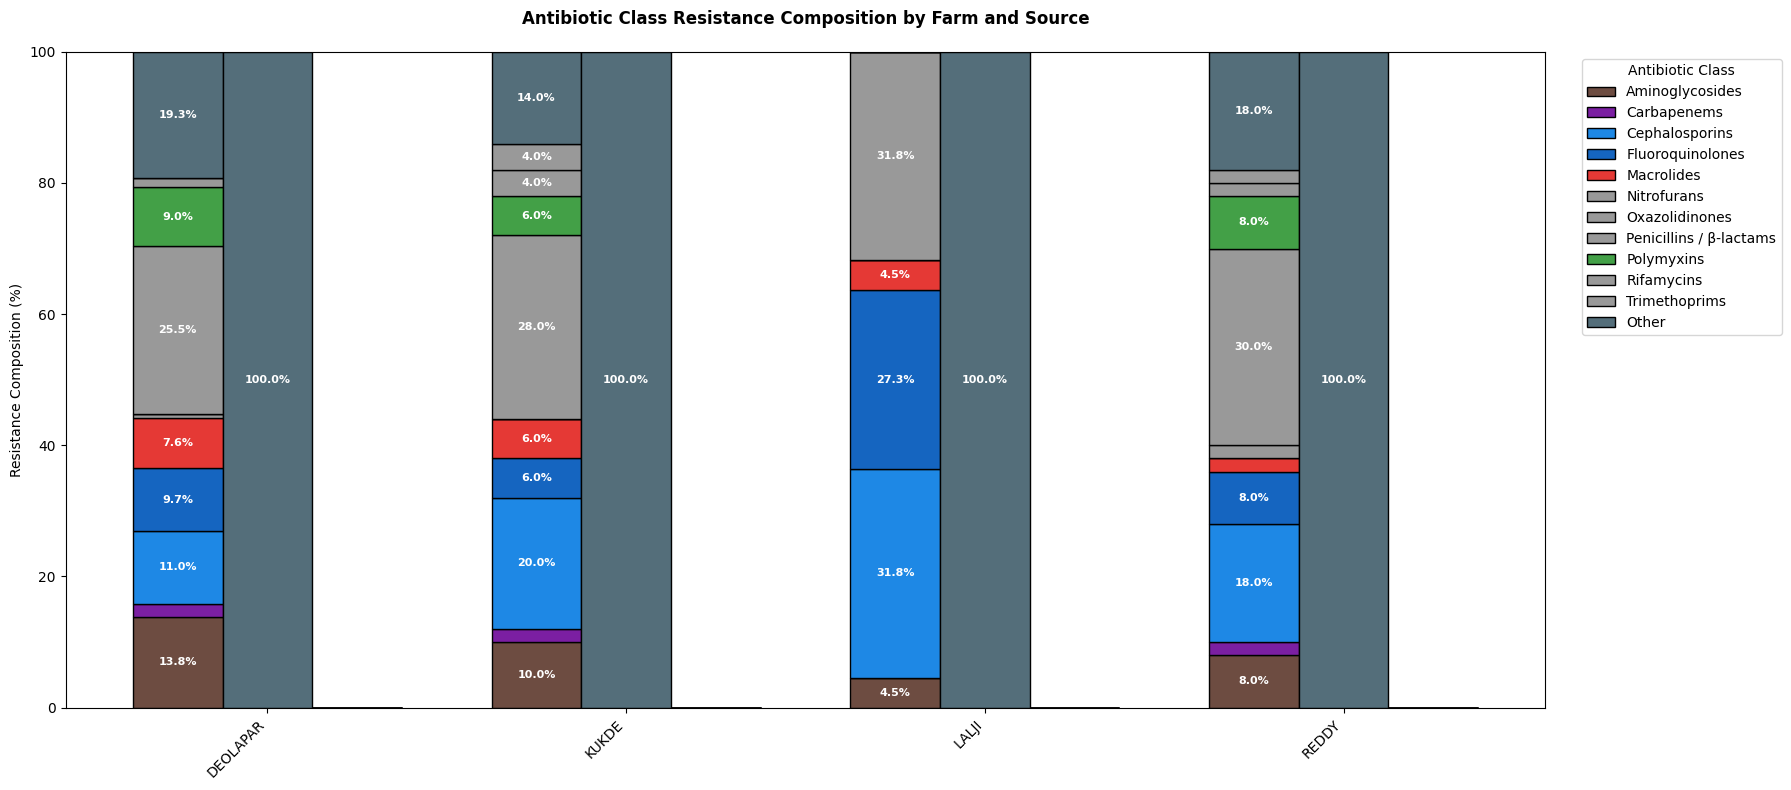

In [4]:
# ============================================================
# ONE HEALTH AMR PIPELINE
# Human + Animal (AST-validated) + Environment
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import io
from functools import lru_cache
from openpyxl import load_workbook
from google.colab import files

# ============================================================
# 1. FARM NORMALIZATION (GLOBAL)
# ============================================================

def canon(name):
    if name is None or pd.isna(name):
        return None

    name = str(name).upper()
    name = re.sub(r"[’'`]", "", name)
    name = re.sub(r"[^A-Z0-9 ]", " ", name)
    name = re.sub(r"\s+", " ", name).strip()

    if name in {"", "NAN", "RM2 1M", "RM2.1M", "R2 1M"}:
        return None
    if any(x in name for x in ["LALJI", "NVC", "MAFSU", "MELGHAT"]):
        return "LALJI"
    if "DEOLAPAR" in name:
        return "DEOLAPAR"
    if "KUKDE" in name:
        return "KUKDE"
    if "REDDY" in name:
        return "REDDY"

    return name


# ============================================================
# 2. ANTIBIOTIC CLASS MAPPING
# ============================================================

ABX_KEYWORD_TO_CLASS = {
    # Aminoglycosides
    "AMIKACIN": "Aminoglycosides",
    "GENTAMICIN": "Aminoglycosides",
    "GENTAMYCIN": "Aminoglycosides",

    # Carbapenems
    "IMIPENEM": "Carbapenems",
    "MEROPENEM": "Carbapenems",
    "ERTAPENEM": "Carbapenems",

    # Cephalosporins
    "CEFTRIAXONE": "Cephalosporins",
    "CEFOTAXIME": "Cephalosporins",
    "CEFTAZIDIME": "Cephalosporins",
    "CEFEPIME": "Cephalosporins",
    "CEFUROXIME": "Cephalosporins",
    "CEFOXITIN": "Cephalosporins",

    # Fluoroquinolones
    "CIPROFLOXACIN": "Fluoroquinolones",
    "LEVOFLOXACIN": "Fluoroquinolones",
    "OFLOXACIN": "Fluoroquinolones",

    # Macrolides
    "ERYTHROMYCIN": "Macrolides",
    "AZITHROMYCIN": "Macrolides",

    # 🔴 MERGED CLASS
    "AMPICILLIN": "Penicillins / β-lactams",
    "AMOXICILLIN": "Penicillins / β-lactams",
    "AMOXYCILLIN": "Penicillins / β-lactams",
    "BENZYLPENICILLIN": "Penicillins / β-lactams",
    "OXACILLIN": "Penicillins / β-lactams",
    "PIPERACILLIN": "Penicillins / β-lactams",
    "TAZOBACTAM": "Penicillins / β-lactams",
    "CLAVULANIC": "Penicillins / β-lactams",

    # Glycopeptides
    "VANCOMYCIN": "Glycopeptides",
    "TEICOPLANIN": "Glycopeptides",

    # Others (true)
    "COLISTIN": "Polymyxins",
    "TETRACYCLINE": "Tetracyclines",
    "DOXYCYCLINE": "Tetracyclines",
    "LINEZOLID": "Oxazolidinones",
    "NITROFURANTOIN": "Nitrofurans",
    "RIFAMPICIN": "Rifamycins",
    "TRIMETHOPRIM": "Trimethoprims",
    "AZTREONAM": "Monobactams",
}

@lru_cache(maxsize=None)
def build_abx_regex():
    return [(re.compile(rf"\b{re.escape(k)}\b"), v)
            for k, v in ABX_KEYWORD_TO_CLASS.items()]

def assign_class(ab):
    ab = str(ab).upper()
    for pat, cls in build_abx_regex():
        if pat.search(ab):
            return cls
    return "Other"


# ============================================================
# 3. HUMAN + ENVIRONMENT LOADER
# ============================================================

def load_and_fix_excel(file_bytes, source, start_idx=15, end_idx=50):
    df = pd.read_excel(io.BytesIO(file_bytes))
    abx_row = df.iloc[0, start_idx:end_idx + 1]
    cols = list(df.columns)
    cols[start_idx:end_idx + 1] = abx_row.tolist()
    df.columns = cols
    df = df.drop(index=0).reset_index(drop=True)
    df["Source"] = source
    return df


# ============================================================
# 4. ANIMAL AST VALIDATED PREPROCESSOR
# ============================================================

def ast_from_fill(cell):
    fill = cell.fill
    if not fill or not fill.start_color:
        return np.nan
    rgb = fill.start_color.rgb
    if rgb is None:
        return np.nan
    if not isinstance(rgb, str):
        rgb = str(rgb)
    rgb = rgb.upper()
    if rgb.startswith("FFFF"):
        return "R"
    if rgb.startswith("FFEB") or rgb.startswith("FFFFFF00"):
        return "S"
    return np.nan


def preprocess_animal_amr(file_bytes):
    wb = load_workbook(io.BytesIO(file_bytes), data_only=True)
    ws = wb.active
    headers = [c.value for c in ws[1]]

    sample_col = headers.index("Sample Code") + 1
    farm_col = headers.index("Farm Name") + 1
    esk_col = next(i+1 for i,h in enumerate(headers) if h and "ESKAPE" in str(h))
    pcr_col = next(i+1 for i,h in enumerate(headers) if h and "PCR" in str(h))
    abx_cols = list(range(pcr_col + 1, len(headers) + 1))

    records = []
    cur_sample, cur_farm = None, None

    for r in range(2, ws.max_row + 1):
        if ws.cell(r, sample_col).value:
            cur_sample = ws.cell(r, sample_col).value
        if ws.cell(r, farm_col).value:
            cur_farm = ws.cell(r, farm_col).value

        org = ws.cell(r, esk_col).value
        pcr = ws.cell(r, pcr_col).value
        if not (org and pcr):
            continue

        farm = canon(cur_farm)
        if not farm:
            continue

        for c in abx_cols:
            abx = headers[c - 1]
            status = ast_from_fill(ws.cell(r, c))
            if pd.isna(status):
                continue

            records.append({
                "Location": farm,
                "Source": "Animal",
                "Antibiotic": abx,
                "Resistance Status": status
            })

    return pd.DataFrame(records)


# ============================================================
# 5. COMPOSITION CALCULATION
# ============================================================

def calculate_composition(all_data, start_idx=15, end_idx=50):
    records = []

    # -------------------------
    # HUMAN + ENVIRONMENT
    # -------------------------
    he = all_data[all_data["Source"].isin(["Human", "Environment"])].copy()

    if not he.empty:
        abx = he.iloc[:, start_idx:end_idx + 1].astype(str).apply(
            lambda x: x.str.strip().str.upper()
        )

        loc_col = "Farm Name" if "Farm Name" in he.columns else "Sample Code"

        base = pd.concat([he[loc_col], he["Source"], abx], axis=1)

        long = base.melt(
            id_vars=[loc_col, "Source"],
            var_name="Antibiotic",
            value_name="Resistance Status",
        )

        long["Resistance Status"] = (
            long["Resistance Status"]
            .replace({"RESISTANT": "R"})
            .str.upper()
        )

        long["Location"] = long[loc_col].apply(canon)

        long = long[
            (long["Resistance Status"] == "R") &
            (long["Location"].notna()) &
            (long["Location"] != "IPKA FARM")
        ]

        records.append(
            long[["Location", "Source", "Antibiotic", "Resistance Status"]]
        )

    # -------------------------
    # ANIMAL (already long)
    # -------------------------
    animal = all_data[all_data["Source"] == "Animal"].copy()
    if not animal.empty:
        animal = animal[animal["Location"] != "IPKA FARM"]
        records.append(
            animal[["Location", "Source", "Antibiotic", "Resistance Status"]]
        )

    df = pd.concat(records, ignore_index=True)

    # TRUE class assignment (unmatched → Other)
    df["Antibiotic Class"] = df["Antibiotic"].apply(assign_class)

    counts = (
        df.groupby(["Location", "Source", "Antibiotic Class"])
        .size()
        .reset_index(name="Count")
    )

    totals = (
        counts.groupby(["Location", "Source"])["Count"]
        .sum()
        .reset_index(name="Total")
    )

    out = counts.merge(totals, on=["Location", "Source"])
    out["Percent"] = out["Count"] / out["Total"] * 100

    return out



# ============================================================
# 6. PLOTTING
# ============================================================

def inspect_other_antibiotics(df):
    other = df[df["Antibiotic Class"] == "Other"]
    summary = (
        other.groupby(["Source", "Antibiotic"])
        .size()
        .reset_index(name="Resistant Count")
        .sort_values("Resistant Count", ascending=False)
    )
    return summary

CLASS_COLORS = {
    "Aminoglycosides": "#6D4C41",
    "Carbapenems": "#7B1FA2",
    "Cephalosporins": "#1E88E5",
    "Fluoroquinolones": "#1565C0",
    "Macrolides": "#E53935",
    "Penicillins": "#C2185B",
    "Glycopeptides": "#F4511E",
    "Polymyxins": "#43A047",
    "Tetracyclines": "#9E9D24",
    "Other": "#546E7A",
}

def plot_composition(df, title):
    if df.empty:
        print("No data to plot")
        return

    farms = sorted(df["Location"].unique())
    sources = ["Human", "Animal", "Environment"]

    classes = sorted(
        df["Antibiotic Class"].unique(),
        key=lambda x: (x == "Other", x)
    )

    x = np.arange(len(farms))
    bw = 0.25

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))

        for cls in classes:
            vals = [
                df.loc[
                    (df["Location"] == f) &
                    (df["Source"] == src) &
                    (df["Antibiotic Class"] == cls),
                    "Percent"
                ].sum()
                for f in farms
            ]

            bars = ax.bar(
                x + i*bw,
                vals,
                bw,
                bottom=bottom,
                color=CLASS_COLORS.get(cls, "#999999"),
                edgecolor="black",
                label=cls if i == 0 else ""
            )

            # ---- percentage labels ----
            for xi, yi, bi in zip(x + i*bw, vals, bottom):
                if yi >= 3:
                    ax.text(
                        xi,
                        bi + yi/2,
                        f"{yi:.1f}%",
                        ha="center",
                        va="center",
                        fontsize=8,
                        fontweight="bold",
                        color="white"
                    )

            bottom += np.array(vals)

    ax.set_xticks(x + bw)
    ax.set_xticklabels(farms, rotation=45, ha="right")
    ax.set_ylim(0, 100)
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_title(title, fontweight="bold", pad=20)

    ax.legend(
        title="Antibiotic Class",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=True
    )

    plt.tight_layout()
    plt.show()



# ============================================================
# 7. MAIN
# ============================================================

print("Upload HUMAN file")
human_up = files.upload()
human_df = load_and_fix_excel(human_up[list(human_up.keys())[0]], "Human")

print("Upload ANIMAL file")
animal_up = files.upload()
animal_df = preprocess_animal_amr(animal_up[list(animal_up.keys())[0]])

print("Upload ENVIRONMENT file")
env_up = files.upload()
env_df = load_and_fix_excel(env_up[list(env_up.keys())[0]], "Environment")

all_data = pd.concat([human_df, animal_df, env_df], ignore_index=True)

composition = calculate_composition(all_data)

plot_composition(
    composition,
    "Antibiotic Class Resistance Composition by Farm and Source"
)


Upload HUMAN file


Saving Human Samples.xlsx to Human Samples (3).xlsx
Upload ANIMAL file


Saving Animal sample data.xlsx to Animal sample data (3).xlsx
Upload ENVIRONMENT file


Saving Enviormental Samples.xlsx to Enviormental Samples (3).xlsx


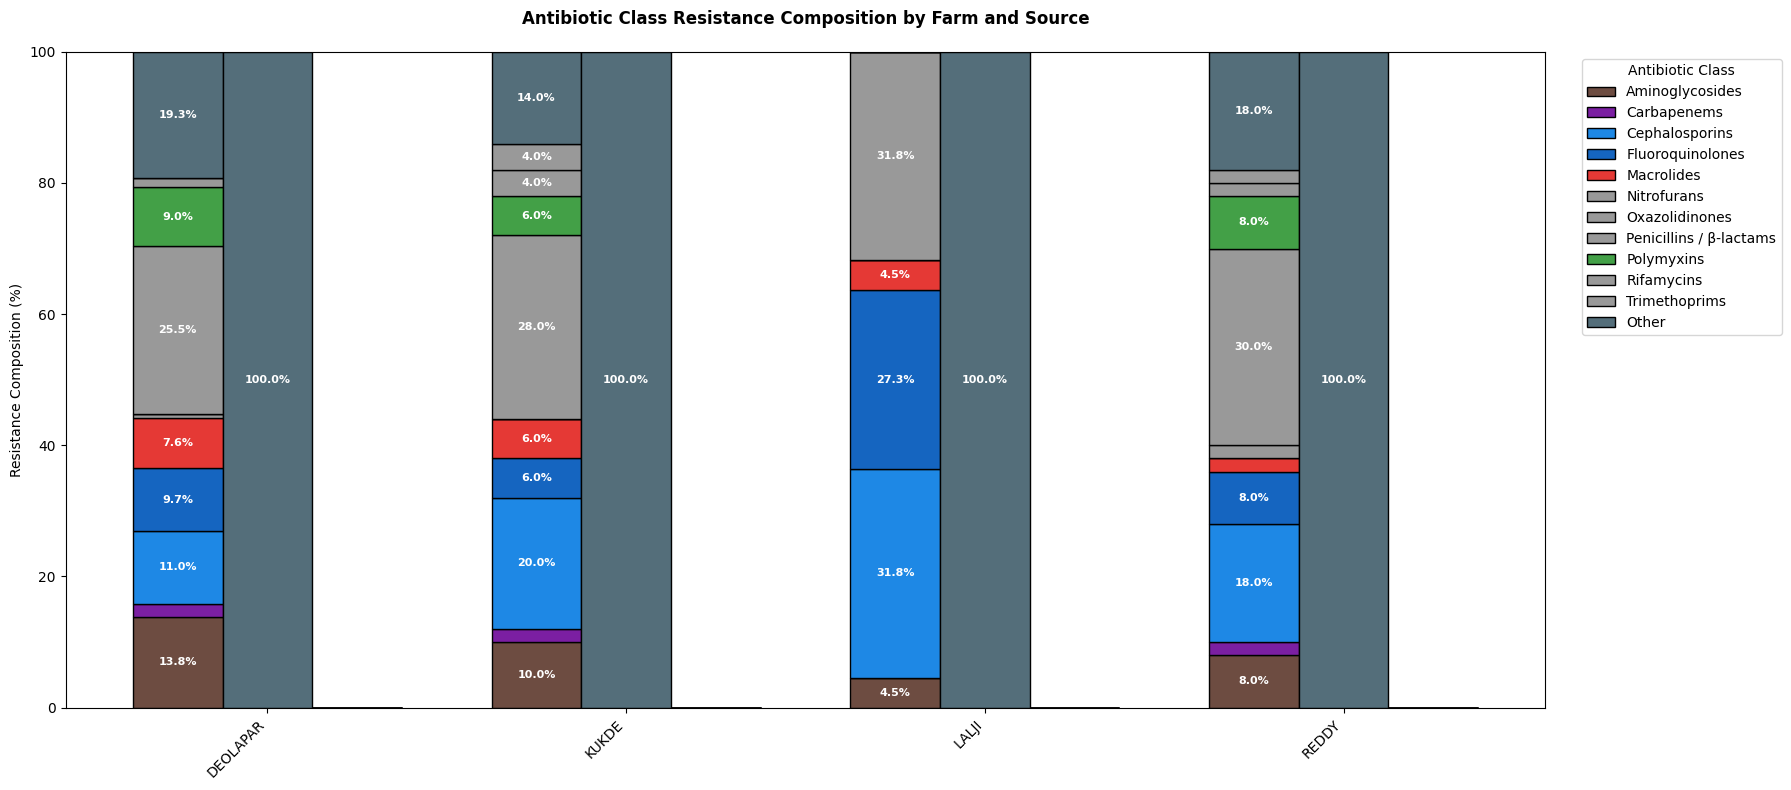

In [ ]:
# ============================================================
# ONE HEALTH AMR PIPELINE
# Human + Animal (AST-validated) + Environment
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import io
from functools import lru_cache
from openpyxl import load_workbook
from google.colab import files

# ============================================================
# 1. FARM NORMALIZATION (GLOBAL)
# ============================================================

def canon(name):
    if name is None or pd.isna(name):
        return None

    name = str(name).upper()
    name = re.sub(r"[’'`]", "", name)
    name = re.sub(r"[^A-Z0-9 ]", " ", name)
    name = re.sub(r"\s+", " ", name).strip()

    if name in {"", "NAN", "RM2 1M", "RM2.1M", "R2 1M"}:
        return None
    if any(x in name for x in ["LALJI", "NVC", "MAFSU", "MELGHAT"]):
        return "LALJI"
    if "DEOLAPAR" in name:
        return "DEOLAPAR"
    if "KUKDE" in name:
        return "KUKDE"
    if "REDDY" in name:
        return "REDDY"

    return name


# ============================================================
# 2. ANTIBIOTIC CLASS MAPPING
# ============================================================

ABX_KEYWORD_TO_CLASS = {
    # Aminoglycosides
    "AMIKACIN": "Aminoglycosides",
    "GENTAMICIN": "Aminoglycosides",
    "GENTAMYCIN": "Aminoglycosides",

    # Carbapenems
    "IMIPENEM": "Carbapenems",
    "MEROPENEM": "Carbapenems",
    "ERTAPENEM": "Carbapenems",

    # Cephalosporins
    "CEFTRIAXONE": "Cephalosporins",
    "CEFOTAXIME": "Cephalosporins",
    "CEFTAZIDIME": "Cephalosporins",
    "CEFEPIME": "Cephalosporins",
    "CEFUROXIME": "Cephalosporins",
    "CEFOXITIN": "Cephalosporins",

    # Fluoroquinolones
    "CIPROFLOXACIN": "Fluoroquinolones",
    "LEVOFLOXACIN": "Fluoroquinolones",
    "OFLOXACIN": "Fluoroquinolones",

    # Macrolides
    "ERYTHROMYCIN": "Macrolides",
    "AZITHROMYCIN": "Macrolides",

    # 🔴 MERGED CLASS
    "AMPICILLIN": "Penicillins / β-lactams",
    "AMOXICILLIN": "Penicillins / β-lactams",
    "AMOXYCILLIN": "Penicillins / β-lactams",
    "BENZYLPENICILLIN": "Penicillins / β-lactams",
    "OXACILLIN": "Penicillins / β-lactams",
    "PIPERACILLIN": "Penicillins / β-lactams",
    "TAZOBACTAM": "Penicillins / β-lactams",
    "CLAVULANIC": "Penicillins / β-lactams",

    # Glycopeptides
    "VANCOMYCIN": "Glycopeptides",
    "TEICOPLANIN": "Glycopeptides",

    # Others (true)
    "COLISTIN": "Polymyxins",
    "TETRACYCLINE": "Tetracyclines",
    "DOXYCYCLINE": "Tetracyclines",
    "LINEZOLID": "Oxazolidinones",
    "NITROFURANTOIN": "Nitrofurans",
    "RIFAMPICIN": "Rifamycins",
    "TRIMETHOPRIM": "Trimethoprims",
    "AZTREONAM": "Monobactams",
}

@lru_cache(maxsize=None)
def build_abx_regex():
    return [(re.compile(rf"\b{re.escape(k)}\b"), v)
            for k, v in ABX_KEYWORD_TO_CLASS.items()]

def assign_class(ab):
    ab = str(ab).upper()
    for pat, cls in build_abx_regex():
        if pat.search(ab):
            return cls
    return "Other"


# ============================================================
# 3. HUMAN + ENVIRONMENT LOADER
# ============================================================

def load_and_fix_excel(file_bytes, source, start_idx=15, end_idx=50):
    df = pd.read_excel(io.BytesIO(file_bytes))
    abx_row = df.iloc[0, start_idx:end_idx + 1]
    cols = list(df.columns)
    cols[start_idx:end_idx + 1] = abx_row.tolist()
    df.columns = cols
    df = df.drop(index=0).reset_index(drop=True)
    df["Source"] = source
    return df


# ============================================================
# 4. ANIMAL AST VALIDATED PREPROCESSOR
# ============================================================

def ast_from_fill(cell):
    fill = cell.fill
    if not fill or not fill.start_color:
        return np.nan
    rgb = fill.start_color.rgb
    if rgb is None:
        return np.nan
    if not isinstance(rgb, str):
        rgb = str(rgb)
    rgb = rgb.upper()
    if rgb.startswith("FFFF"):
        return "R"
    if rgb.startswith("FFEB") or rgb.startswith("FFFFFF00"):
        return "S"
    return np.nan


def preprocess_animal_amr(file_bytes):
    wb = load_workbook(io.BytesIO(file_bytes), data_only=True)
    ws = wb.active
    headers = [c.value for c in ws[1]]

    sample_col = headers.index("Sample Code") + 1
    farm_col = headers.index("Farm Name") + 1
    esk_col = next(i+1 for i,h in enumerate(headers) if h and "ESKAPE" in str(h))
    pcr_col = next(i+1 for i,h in enumerate(headers) if h and "PCR" in str(h))
    abx_cols = list(range(pcr_col + 1, len(headers) + 1))

    records = []
    cur_sample, cur_farm = None, None

    for r in range(2, ws.max_row + 1):
        if ws.cell(r, sample_col).value:
            cur_sample = ws.cell(r, sample_col).value
        if ws.cell(r, farm_col).value:
            cur_farm = ws.cell(r, farm_col).value

        org = ws.cell(r, esk_col).value
        pcr = ws.cell(r, pcr_col).value
        if not (org and pcr):
            continue

        farm = canon(cur_farm)
        if not farm:
            continue

        for c in abx_cols:
            abx = headers[c - 1]
            status = ast_from_fill(ws.cell(r, c))
            if pd.isna(status):
                continue

            records.append({
                "Location": farm,
                "Source": "Animal",
                "Antibiotic": abx,
                "Resistance Status": status
            })

    return pd.DataFrame(records)


# ============================================================
# 5. COMPOSITION CALCULATION
# ============================================================

def calculate_composition(all_data, start_idx=15, end_idx=50):
    records = []

    # -------------------------
    # HUMAN + ENVIRONMENT
    # -------------------------
    he = all_data[all_data["Source"].isin(["Human", "Environment"])].copy()

    if not he.empty:
        abx = he.iloc[:, start_idx:end_idx + 1].astype(str).apply(
            lambda x: x.str.strip().str.upper()
        )

        loc_col = "Farm Name" if "Farm Name" in he.columns else "Sample Code"

        base = pd.concat([he[loc_col], he["Source"], abx], axis=1)

        long = base.melt(
            id_vars=[loc_col, "Source"],
            var_name="Antibiotic",
            value_name="Resistance Status",
        )

        long["Resistance Status"] = (
            long["Resistance Status"]
            .replace({"RESISTANT": "R"})
            .str.upper()
        )

        long["Location"] = long[loc_col].apply(canon)

        long = long[
            (long["Resistance Status"] == "R") &
            (long["Location"].notna()) &
            (long["Location"] != "IPKA FARM")
        ]

        records.append(
            long[["Location", "Source", "Antibiotic", "Resistance Status"]]
        )

    # -------------------------
    # ANIMAL (already long)
    # -------------------------
    animal = all_data[all_data["Source"] == "Animal"].copy()
    if not animal.empty:
        animal = animal[animal["Location"] != "IPKA FARM"]
        records.append(
            animal[["Location", "Source", "Antibiotic", "Resistance Status"]]
        )

    df = pd.concat(records, ignore_index=True)

    # TRUE class assignment (unmatched → Other)
    df["Antibiotic Class"] = df["Antibiotic"].apply(assign_class)

    counts = (
        df.groupby(["Location", "Source", "Antibiotic Class"])
        .size()
        .reset_index(name="Count")
    )

    totals = (
        counts.groupby(["Location", "Source"])["Count"]
        .sum()
        .reset_index(name="Total")
    )

    out = counts.merge(totals, on=["Location", "Source"])
    out["Percent"] = out["Count"] / out["Total"] * 100

    return out



# ============================================================
# 6. PLOTTING
# ============================================================

def inspect_other_antibiotics(df):
    other = df[df["Antibiotic Class"] == "Other"]
    summary = (
        other.groupby(["Source", "Antibiotic"])
        .size()
        .reset_index(name="Resistant Count")
        .sort_values("Resistant Count", ascending=False)
    )
    return summary

CLASS_COLORS = {
    "Aminoglycosides": "#6D4C41",
    "Carbapenems": "#7B1FA2",
    "Cephalosporins": "#1E88E5",
    "Fluoroquinolones": "#1565C0",
    "Macrolides": "#E53935",
    "Penicillins": "#C2185B",
    "Glycopeptides": "#F4511E",
    "Polymyxins": "#43A047",
    "Tetracyclines": "#9E9D24",
    "Other": "#546E7A",
}

def plot_composition(df, title):
    if df.empty:
        print("No data to plot")
        return

    farms = sorted(df["Location"].unique())
    sources = ["Human", "Animal", "Environment"]

    classes = sorted(
        df["Antibiotic Class"].unique(),
        key=lambda x: (x == "Other", x)
    )

    x = np.arange(len(farms))
    bw = 0.25

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))

        for cls in classes:
            vals = [
                df.loc[
                    (df["Location"] == f) &
                    (df["Source"] == src) &
                    (df["Antibiotic Class"] == cls),
                    "Percent"
                ].sum()
                for f in farms
            ]

            bars = ax.bar(
                x + i*bw,
                vals,
                bw,
                bottom=bottom,
                color=CLASS_COLORS.get(cls, "#999999"),
                edgecolor="black",
                label=cls if i == 0 else ""
            )

            # ---- percentage labels ----
            for xi, yi, bi in zip(x + i*bw, vals, bottom):
                if yi >= 3:
                    ax.text(
                        xi,
                        bi + yi/2,
                        f"{yi:.1f}%",
                        ha="center",
                        va="center",
                        fontsize=8,
                        fontweight="bold",
                        color="white"
                    )

            bottom += np.array(vals)

    ax.set_xticks(x + bw)
    ax.set_xticklabels(farms, rotation=45, ha="right")
    ax.set_ylim(0, 100)
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_title(title, fontweight="bold", pad=20)

    ax.legend(
        title="Antibiotic Class",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=True
    )

    plt.tight_layout()
    plt.show()



# ============================================================
# 7. MAIN
# ============================================================

print("Upload HUMAN file")
human_up = files.upload()
human_df = load_and_fix_excel(human_up[list(human_up.keys())[0]], "Human")

print("Upload ANIMAL file")
animal_up = files.upload()
animal_df = preprocess_animal_amr(animal_up[list(animal_up.keys())[0]])

print("Upload ENVIRONMENT file")
env_up = files.upload()
env_df = load_and_fix_excel(env_up[list(env_up.keys())[0]], "Environment")

all_data = pd.concat([human_df, animal_df, env_df], ignore_index=True)

composition = calculate_composition(all_data)

plot_composition(
    composition,
    "Antibiotic Class Resistance Composition by Farm and Source"
)


Upload HUMAN file


Saving Human Samples.xlsx to Human Samples (4).xlsx
Upload ANIMAL file


Saving Animal sample data.xlsx to Animal sample data (4).xlsx
Upload ENVIRONMENT file


Saving Enviormental Samples.xlsx to Enviormental Samples (4).xlsx

ANIMAL AST SANITY CHECK

Antibiotics with R (raw):
Antibiotic
List of Antimicrograms    68
Name: count, dtype: int64

Mapped classes:
Class
Other    2788
Name: count, dtype: int64


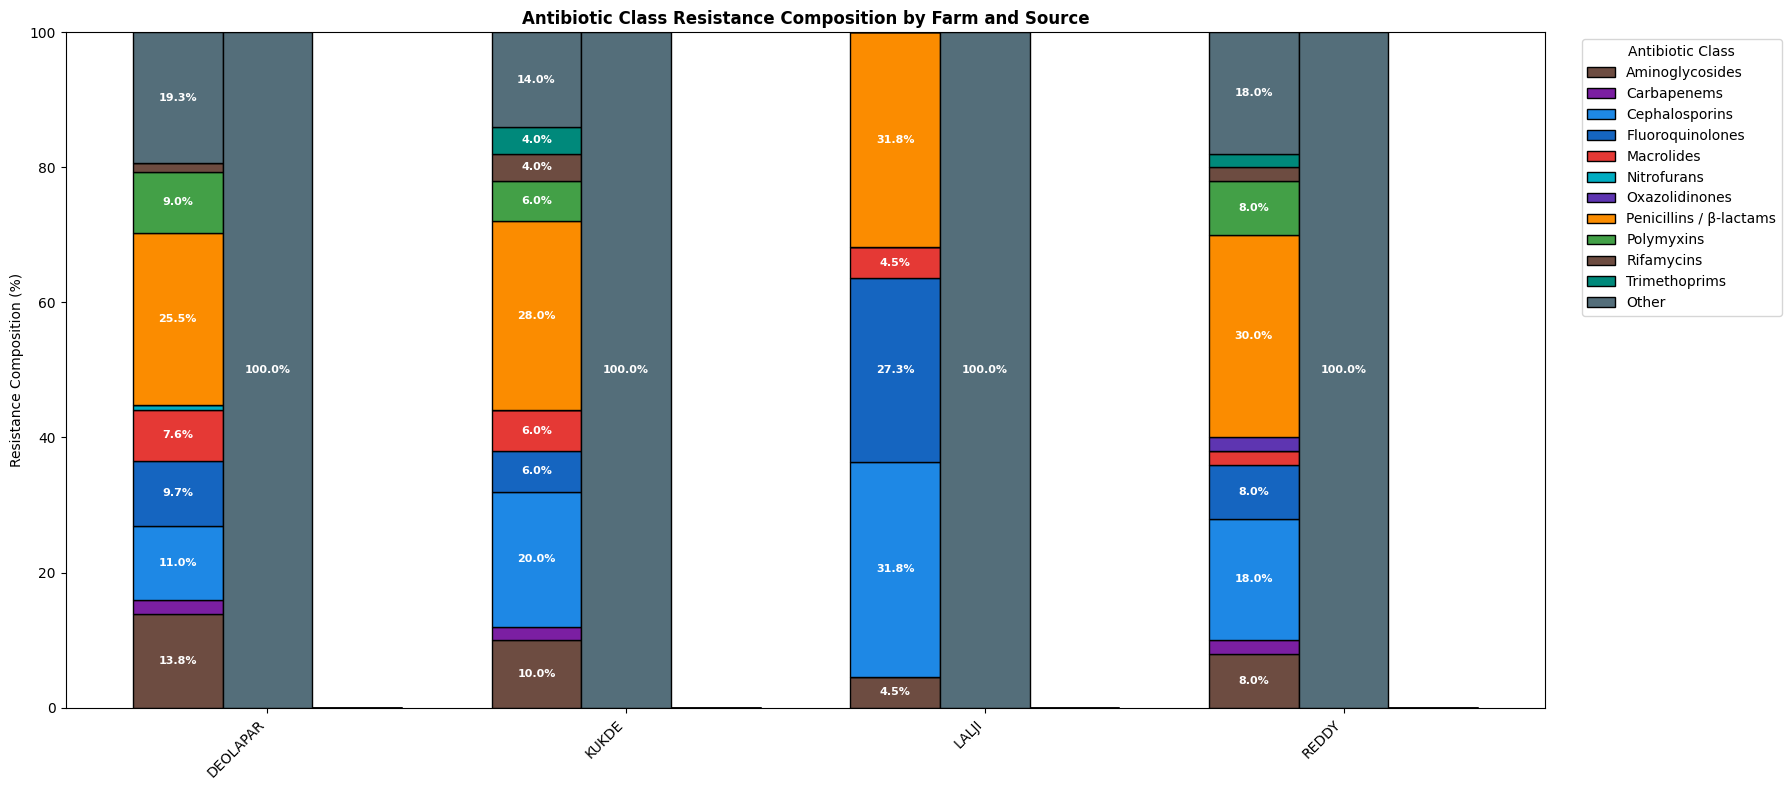

In [7]:
# ============================================================
# ONE HEALTH AMR PIPELINE
# Human + Animal + Environment
# WITH ANIMAL AST SANITY CHECK
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import io
from functools import lru_cache
from openpyxl import load_workbook
from google.colab import files

# ============================================================
# 1. FARM NAME NORMALIZATION
# ============================================================

def canon(name):
    if name is None or pd.isna(name):
        return None

    name = str(name).upper()
    name = re.sub(r"[’'`]", "", name)
    name = re.sub(r"[^A-Z0-9 ]", " ", name)
    name = re.sub(r"\s+", " ", name).strip()

    if name in {"", "NAN", "RM2 1M", "RM2.1M", "R2 1M"}:
        return None
    if any(x in name for x in ["LALJI", "NVC", "MAFSU", "MELGHAT"]):
        return "LALJI"
    if "DEOLAPAR" in name:
        return "DEOLAPAR"
    if "KUKDE" in name:
        return "KUKDE"
    if "REDDY" in name:
        return "REDDY"
    if "IPKA" in name:
        return None

    return name


# ============================================================
# 2. ANTIBIOTIC CLASS MAPPING (REFINED)
# ============================================================

ABX_KEYWORD_TO_CLASS = {
    # Aminoglycosides
    "AMIKACIN": "Aminoglycosides",
    "GENTAMICIN": "Aminoglycosides",
    "GENTAMYCIN": "Aminoglycosides",

    # Carbapenems
    "IMIPENEM": "Carbapenems",
    "MEROPENEM": "Carbapenems",
    "ERTAPENEM": "Carbapenems",

    # Cephalosporins
    "CEFTRIAXONE": "Cephalosporins",
    "CEFOTAXIME": "Cephalosporins",
    "CEFTAZIDIME": "Cephalosporins",
    "CEFEPIME": "Cephalosporins",
    "CEFUROXIME": "Cephalosporins",
    "CEFOXITIN": "Cephalosporins",

    # Fluoroquinolones
    "CIPROFLOXACIN": "Fluoroquinolones",
    "LEVOFLOXACIN": "Fluoroquinolones",
    "OFLOXACIN": "Fluoroquinolones",

    # Macrolides
    "ERYTHROMYCIN": "Macrolides",
    "AZITHROMYCIN": "Macrolides",

    # Penicillins / β-lactams (MERGED)
    "AMPICILLIN": "Penicillins / β-lactams",
    "AMOXICILLIN": "Penicillins / β-lactams",
    "AMOXYCILLIN": "Penicillins / β-lactams",
    "BENZYLPENICILLIN": "Penicillins / β-lactams",
    "OXACILLIN": "Penicillins / β-lactams",
    "PIPERACILLIN": "Penicillins / β-lactams",
    "TAZOBACTAM": "Penicillins / β-lactams",
    "CLAVULANIC": "Penicillins / β-lactams",

    # Others
    "VANCOMYCIN": "Glycopeptides",
    "TEICOPLANIN": "Glycopeptides",
    "COLISTIN": "Polymyxins",
    "TETRACYCLINE": "Tetracyclines",
    "DOXYCYCLINE": "Tetracyclines",
    "LINEZOLID": "Oxazolidinones",
    "NITROFURANTOIN": "Nitrofurans",
    "RIFAMPICIN": "Rifamycins",
    "TRIMETHOPRIM": "Trimethoprims",
    "AZTREONAM": "Monobactams",
}

@lru_cache(maxsize=None)
def build_abx_regex():
    return [(re.compile(rf"\b{re.escape(k)}\b"), v)
            for k, v in ABX_KEYWORD_TO_CLASS.items()]

def assign_class(ab):
    ab = str(ab).upper()
    for pat, cls in build_abx_regex():
        if pat.search(ab):
            return cls
    return "Other"


# ============================================================
# 3. LOAD HUMAN / ENVIRONMENT DATA
# ============================================================

def load_and_fix_excel(file_bytes, source, start_idx=15, end_idx=50):
    df = pd.read_excel(io.BytesIO(file_bytes))
    abx_row = df.iloc[0, start_idx:end_idx + 1]
    cols = list(df.columns)
    cols[start_idx:end_idx + 1] = abx_row.tolist()
    df.columns = cols
    df = df.drop(index=0).reset_index(drop=True)
    df["Source"] = source
    return df


# ============================================================
# 4. LOAD & PROCESS ANIMAL AST DATA (COLOR-BASED)
# ============================================================

def ast_from_fill(cell):
    fill = cell.fill
    if not fill or not fill.start_color:
        return np.nan
    rgb = fill.start_color.rgb
    if rgb is None:
        return np.nan
    rgb = str(rgb).upper()
    if rgb.startswith("FFFF"):
        return "R"
    if rgb.startswith("FFEB") or rgb.startswith("FFFFFF00"):
        return "S"
    return np.nan


def preprocess_animal_amr(file_bytes):
    wb = load_workbook(io.BytesIO(file_bytes), data_only=True)
    ws = wb.active
    headers = [c.value for c in ws[1]]

    sample_col = headers.index("Sample Code") + 1
    farm_col = headers.index("Farm Name") + 1
    esk_col = next(i+1 for i,h in enumerate(headers) if h and "ESKAPE" in str(h))
    pcr_col = next(i+1 for i,h in enumerate(headers) if h and "PCR" in str(h))
    abx_cols = list(range(pcr_col + 1, len(headers) + 1))

    rows = []
    cur_sample, cur_farm = None, None

    for r in range(2, ws.max_row + 1):
        if ws.cell(r, sample_col).value:
            cur_sample = ws.cell(r, sample_col).value
        if ws.cell(r, farm_col).value:
            cur_farm = ws.cell(r, farm_col).value

        org = ws.cell(r, esk_col).value
        pcr = ws.cell(r, pcr_col).value
        if not (org and pcr):
            continue

        farm = canon(cur_farm)
        if not farm:
            continue

        for c in abx_cols:
            abx = headers[c - 1]
            status = ast_from_fill(ws.cell(r, c))
            if pd.isna(status):
                continue

            rows.append({
                "Location": farm,
                "Source": "Animal",
                "Antibiotic": abx,
                "Resistance Status": status
            })

    return pd.DataFrame(rows)


# ============================================================
# 5. 🔎 ANIMAL AST SANITY CHECK (DIAGNOSTIC)
# ============================================================

def animal_sanity_check(all_data):
    animal = all_data[all_data["Source"] == "Animal"].copy()

    print("\n" + "="*70)
    print("ANIMAL AST SANITY CHECK")
    print("="*70)

    print("\nAntibiotics with R (raw):")
    print(
        animal[animal["Resistance Status"] == "R"]["Antibiotic"]
        .value_counts()
    )

    print("\nMapped classes:")
    print(
        animal[animal["Resistance Status"] == "R"]
        .assign(Class=lambda d: d["Antibiotic"].apply(assign_class))
        ["Class"]
        .value_counts()
    )

    print("="*70)


# ============================================================
# 6. CALCULATE RESISTANCE COMPOSITION
# ============================================================

def calculate_composition(all_data, start_idx=15, end_idx=50):
    records = []

    he = all_data[all_data["Source"].isin(["Human", "Environment"])].copy()
    if not he.empty:
        abx = he.iloc[:, start_idx:end_idx + 1].astype(str).apply(
            lambda x: x.str.strip().str.upper()
        )
        loc_col = "Farm Name" if "Farm Name" in he.columns else "Sample Code"
        base = pd.concat([he[loc_col], he["Source"], abx], axis=1)

        long = base.melt(
            id_vars=[loc_col, "Source"],
            var_name="Antibiotic",
            value_name="Resistance Status"
        )

        long["Resistance Status"] = (
            long["Resistance Status"]
            .replace({"RESISTANT": "R"})
            .str.upper()
        )

        long["Location"] = long[loc_col].apply(canon)
        long = long[(long["Resistance Status"] == "R") & long["Location"].notna()]

        records.append(long[["Location", "Source", "Antibiotic", "Resistance Status"]])

    animal = all_data[all_data["Source"] == "Animal"]
    if not animal.empty:
        records.append(animal[["Location", "Source", "Antibiotic", "Resistance Status"]])

    df = pd.concat(records, ignore_index=True)
    df["Antibiotic Class"] = df["Antibiotic"].apply(assign_class)

    counts = df.groupby(["Location", "Source", "Antibiotic Class"]).size().reset_index(name="Count")
    totals = counts.groupby(["Location", "Source"])["Count"].sum().reset_index(name="Total")
    out = counts.merge(totals, on=["Location", "Source"])
    out["Percent"] = out["Count"] / out["Total"] * 100

    return out


# ============================================================
# 7. PLOTTING
# ============================================================

CLASS_COLORS = {
    "Aminoglycosides": "#6D4C41",
    "Carbapenems": "#7B1FA2",
    "Cephalosporins": "#1E88E5",
    "Fluoroquinolones": "#1565C0",
    "Macrolides": "#E53935",
    "Penicillins / β-lactams": "#FB8C00",
    "Glycopeptides": "#F4511E",
    "Polymyxins": "#43A047",
    "Tetracyclines": "#9E9D24",
    "Oxazolidinones": "#5E35B1",
    "Nitrofurans": "#00ACC1",
    "Rifamycins": "#6D4C41",
    "Trimethoprims": "#00897B",
    "Monobactams": "#827717",
    "Other": "#546E7A",
}

def plot_composition(df, title):
    farms = sorted(df["Location"].unique())
    sources = ["Human", "Animal", "Environment"]
    classes = sorted(df["Antibiotic Class"].unique(), key=lambda x: (x == "Other", x))

    x = np.arange(len(farms))
    bw = 0.25

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))
        for cls in classes:
            vals = [
                df.loc[
                    (df["Location"] == f) &
                    (df["Source"] == src) &
                    (df["Antibiotic Class"] == cls),
                    "Percent"
                ].sum()
                for f in farms
            ]

            ax.bar(
                x + i*bw,
                vals,
                bw,
                bottom=bottom,
                color=CLASS_COLORS.get(cls, "#999999"),
                edgecolor="black",
                label=cls if i == 0 else ""
            )

            for xi, yi, bi in zip(x + i*bw, vals, bottom):
                if yi >= 3:
                    ax.text(xi, bi + yi/2, f"{yi:.1f}%",
                            ha="center", va="center",
                            fontsize=8, fontweight="bold", color="white")

            bottom += np.array(vals)

    ax.set_xticks(x + bw)
    ax.set_xticklabels(farms, rotation=45, ha="right")
    ax.set_ylim(0, 100)
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_title(title, fontweight="bold")

    ax.legend(title="Antibiotic Class", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


# ============================================================
# 8. MAIN
# ============================================================

print("Upload HUMAN file")
human_up = files.upload()
human_df = load_and_fix_excel(human_up[list(human_up.keys())[0]], "Human")

print("Upload ANIMAL file")
animal_up = files.upload()
animal_df = preprocess_animal_amr(animal_up[list(animal_up.keys())[0]])

print("Upload ENVIRONMENT file")
env_up = files.upload()
env_df = load_and_fix_excel(env_up[list(env_up.keys())[0]], "Environment")

all_data = pd.concat([human_df, animal_df, env_df], ignore_index=True)

# 🔎 SANITY CHECK (RUN ONCE)
animal_sanity_check(all_data)

composition = calculate_composition(all_data)

plot_composition(
    composition,
    "Antibiotic Class Resistance Composition by Farm and Source"
)


In [8]:
# ============================================================
# COMPLETE AMR PIPELINE WITH:
# - NO "OTHER" CLASS
# - DRUG-LEVEL EXPANSION
# - ANIMAL SANITY CHECK
# - SAMPLE TYPE LABELS ON TOP
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io, re
from google.colab import files
from functools import lru_cache

# ============================================================
# 1. LOAD & FIX EXCEL
# ============================================================

def load_and_fix_excel(file_bytes, source, start_idx=15, end_idx=50):
    df = pd.read_excel(io.BytesIO(file_bytes))
    abx_row = df.iloc[0, start_idx:end_idx + 1]
    df.columns = list(df.columns[:start_idx]) + abx_row.tolist() + list(df.columns[end_idx+1:])
    df = df.drop(index=0).reset_index(drop=True)
    df["Source"] = source
    return df, start_idx, end_idx


def load_all_amr_data():
    datasets = {}
    for src in ["Human", "Animal", "Environment"]:
        print(f"\nUpload {src} AMR Excel file:")
        up = files.upload()
        fname = list(up.keys())[0]
        datasets[src] = load_and_fix_excel(up[fname], src)

    human, s, e = datasets["Human"]
    animal, _, _ = datasets["Animal"]
    env, _, _ = datasets["Environment"]
    return human, animal, env, s, e


# ============================================================
# 2. FARM NORMALIZATION
# ============================================================

def canon(name):
    if pd.isna(name):
        return None
    name = re.sub(r"[^A-Z0-9 ]", " ", str(name).upper())
    name = re.sub(r"\s+", " ", name).strip()

    if name in {"NAN", "RM2 1M", "R2 1M", ""}:
        return None
    if "DEOLAPAR" in name:
        return "DEOLAPAR"
    if "KUKDE" in name:
        return "KUKDE"
    if "REDDY" in name:
        return "REDDY"
    if "LALJI" in name or "MAFSU" in name:
        return "LALJI"
    return name


def detect_location_column(df):
    return "Farm Name" if "Farm Name" in df.columns else "Sample Code"


def normalize_farms(df, loc_col):
    df = df.copy()
    df[loc_col] = df[loc_col].apply(canon)
    return df[df[loc_col].notna()].reset_index(drop=True)


# ============================================================
# 3. ANTIBIOTIC → CLASS (NO "OTHER")
# ============================================================

BETA_LACTAMS = {
    "AMOXICILLIN", "AMPICILLIN", "OXACILLIN",
    "CEFUROXIME", "CEFEPIME", "CEFTRIAXONE",
    "CEFOPERAZONE", "CEFOXITIN",
    "PIPERACILLIN", "AZTREONAM",
    "AMOXICILLIN/CLAVULANIC"
}

CLASS_MAP = {
    "AMIKACIN": "Aminoglycosides",
    "GENTAMICIN": "Aminoglycosides",
    "IMIPENEM": "Carbapenems",
    "MEROPENEM": "Carbapenems",
    "CIPROFLOXACIN": "Fluoroquinolones",
    "LEVOFLOXACIN": "Fluoroquinolones",
    "ERYTHROMYCIN": "Macrolides",
    "CLINDAMYCIN": "Lincosamides",
    "LINEZOLID": "Oxazolidinones",
    "COLISTIN": "Polymyxins",
    "RIFAMPICIN": "Rifamycins",
    "TRIMETHOPRIM": "Trimethoprims",
    "NITROFURANTOIN": "Nitrofurans",
    "FOSFOMYCIN": "Fosfomycins",
    "DAPTOMYCIN": "Daptomycins",
}


@lru_cache(None)
def classify_drug(drug):
    d = drug.upper()
    if any(b in d for b in BETA_LACTAMS):
        return "Penicillins / β-lactams"
    for k, v in CLASS_MAP.items():
        if k in d:
            return v
    return d  # 👈 promote drug itself (NO "Other")


# ============================================================
# 4. ANIMAL SANITY CHECK
# ============================================================

def animal_sanity_check(long_df):
    animal = long_df[long_df["Source"] == "Animal"]
    print("\n" + "="*70)
    print("ANIMAL AST SANITY CHECK")
    print("="*70)
    print("\nResistant drugs in animals:")
    print(animal["Antibiotic"].value_counts())
    print("\nMapped classes:")
    print(animal["Drug Class"].value_counts())
    print("="*70)


# ============================================================
# 5. CALCULATION
# ============================================================

def calculate_composition(df, start_idx, end_idx):
    loc_col = detect_location_column(df)
    df = normalize_farms(df, loc_col)

    abx = df.iloc[:, start_idx:end_idx+1].astype(str).apply(lambda x: x.str.upper())
    base = pd.concat([df[[loc_col, "Source"]], abx], axis=1)

    long = base.melt(
        id_vars=[loc_col, "Source"],
        var_name="Antibiotic",
        value_name="Status"
    )

    long = long[long["Status"].str.startswith("R", na=False)]
    long["Drug Class"] = long["Antibiotic"].apply(classify_drug)

    animal_sanity_check(long)

    counts = (
        long.groupby([loc_col, "Source", "Drug Class"])
        .size()
        .reset_index(name="Count")
    )

    totals = counts.groupby([loc_col, "Source"])["Count"].sum().reset_index(name="Total")
    comp = counts.merge(totals, on=[loc_col, "Source"])
    comp["Percent"] = comp["Count"] / comp["Total"] * 100
    comp = comp.rename(columns={loc_col: "Location"})

    return comp


# ============================================================
# 6. PLOTTING
# ============================================================

def plot_composition(df, title):
    farms = sorted(df["Location"].unique())
    sources = ["Human", "Animal", "Environment"]
    classes = sorted(df["Drug Class"].unique())

    bar_w = 0.22
    x = np.arange(len(farms))

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))

        for cls in classes:
            vals = [
                df[(df["Location"] == f) & (df["Source"] == src) & (df["Drug Class"] == cls)]["Percent"].sum()
                for f in farms
            ]

            ax.bar(x + i*bar_w, vals, bar_w, bottom=bottom, label=cls if i == 0 else "")

            for xi, yi, bi in zip(x + i*bar_w, vals, bottom):
                if yi >= 4:
                    ax.text(xi, bi + yi/2, f"{yi:.1f}%", ha="center", va="center", fontsize=8)

            bottom += np.array(vals)

        for xi in x:
            ax.text(xi + i*bar_w, 102, src, ha="center", va="bottom", fontsize=9, rotation=45)

    ax.set_xticks(x + bar_w)
    ax.set_xticklabels(farms, rotation=45, ha="right")
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_ylim(0, 110)
    ax.set_title(title, fontweight="bold")

    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


# ============================================================
# 7. MAIN
# ============================================================

human, animal, env, s, e = load_all_amr_data()
all_data = pd.concat([human, animal, env], ignore_index=True)

composition = calculate_composition(all_data, s, e)

plot_composition(
    composition,
    "Antibiotic Resistance Composition by Farm and Sample Type"
)



Upload Human AMR Excel file:


Saving Human Samples.xlsx to Human Samples (5).xlsx

Upload Animal AMR Excel file:


Saving Animal sample data.xlsx to Animal sample data (5).xlsx

Upload Environment AMR Excel file:


Saving Enviormental Samples.xlsx to Enviormental Samples (5).xlsx


InvalidIndexError: Reindexing only valid with uniquely valued Index objects


Upload Human AMR Excel file:


Saving Human Samples.xlsx to Human Samples (6).xlsx

Upload Animal AMR Excel file:


Saving Animal sample data.xlsx to Animal sample data (6).xlsx

Upload Environment AMR Excel file:


Saving Enviormental Samples.xlsx to Enviormental Samples (6).xlsx

ANIMAL AST SANITY CHECK

Resistant drugs:
Series([], Name: count, dtype: int64)

Mapped classes:
Series([], Name: count, dtype: int64)


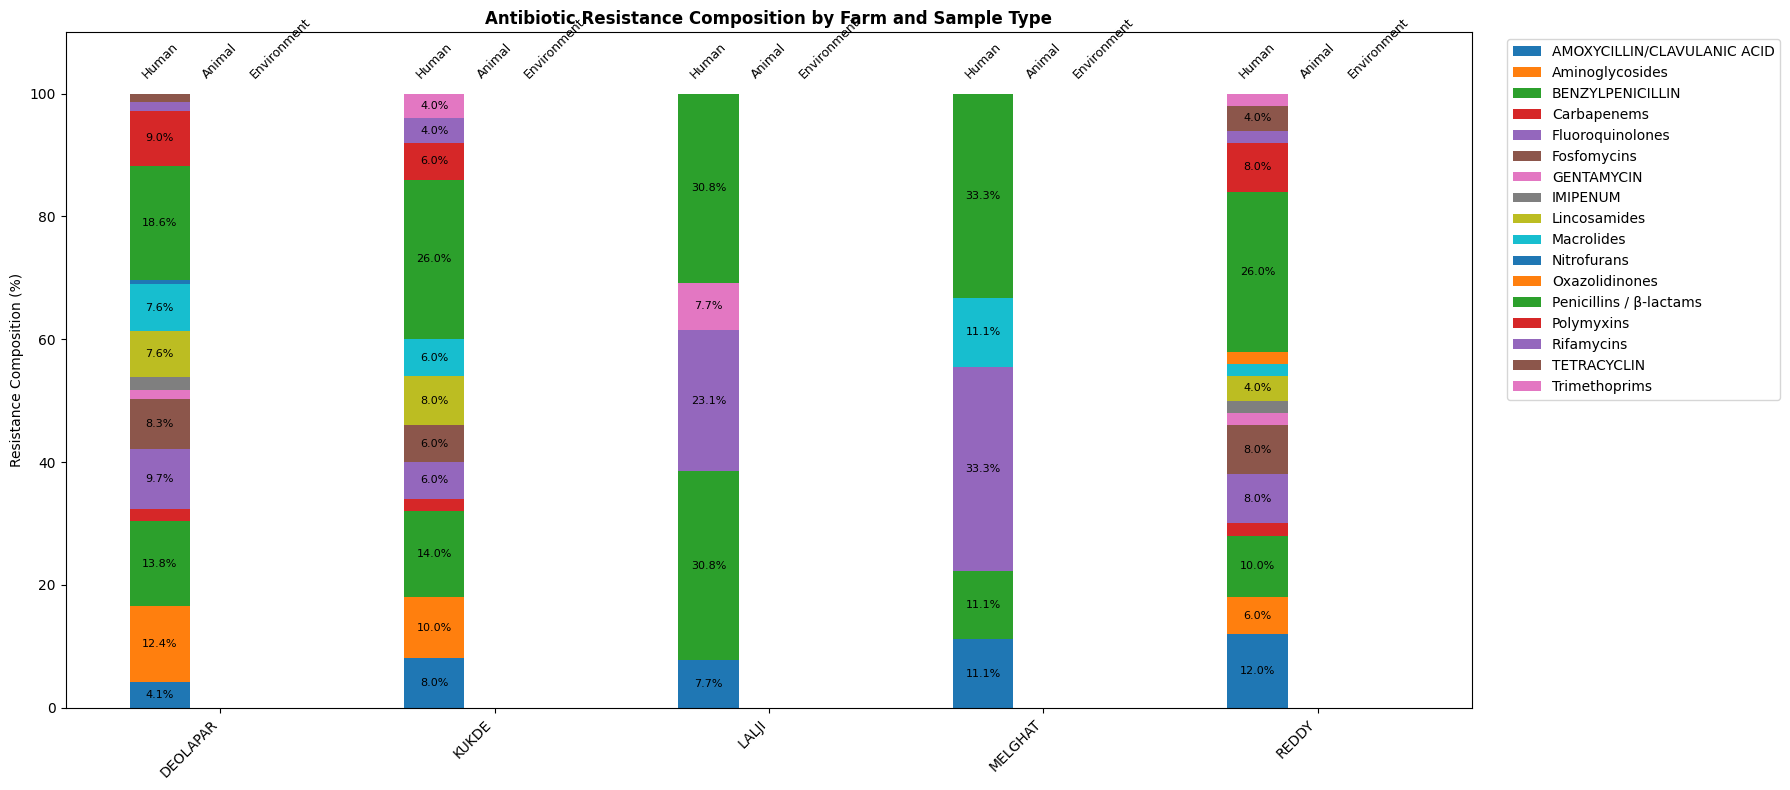

In [9]:
# ============================================================
# COMPLETE AMR PIPELINE (FIXED FOR DUPLICATE COLUMNS)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io, re
from google.colab import files
from functools import lru_cache

# ============================================================
# 1. LOAD & FIX EXCEL (WITH UNIQUE COLUMN FIX)
# ============================================================

def make_columns_unique(cols):
    seen = {}
    new_cols = []
    for c in cols:
        if c not in seen:
            seen[c] = 1
            new_cols.append(c)
        else:
            seen[c] += 1
            new_cols.append(f"{c}_{seen[c]}")
    return new_cols


def load_and_fix_excel(file_bytes, source, start_idx=15, end_idx=50):
    df = pd.read_excel(io.BytesIO(file_bytes))

    abx_row = df.iloc[0, start_idx:end_idx + 1].astype(str)
    cols = list(df.columns)

    cols[start_idx:end_idx + 1] = abx_row.tolist()
    cols = make_columns_unique(cols)  # 🔧 FIX HERE

    df.columns = cols
    df = df.drop(index=0).reset_index(drop=True)
    df["Source"] = source

    return df, start_idx, end_idx


def load_all_amr_data():
    datasets = {}
    for src in ["Human", "Animal", "Environment"]:
        print(f"\nUpload {src} AMR Excel file:")
        up = files.upload()
        fname = list(up.keys())[0]
        datasets[src] = load_and_fix_excel(up[fname], src)

    human, s, e = datasets["Human"]
    animal, _, _ = datasets["Animal"]
    env, _, _ = datasets["Environment"]

    return human, animal, env, s, e


# ============================================================
# 2. FARM NORMALIZATION
# ============================================================

def canon(name):
    if pd.isna(name):
        return None
    name = re.sub(r"[^A-Z0-9 ]", " ", str(name).upper())
    name = re.sub(r"\s+", " ", name).strip()

    if name in {"NAN", "RM2 1M", "R2 1M", ""}:
        return None
    if "DEOLAPAR" in name:
        return "DEOLAPAR"
    if "KUKDE" in name:
        return "KUKDE"
    if "REDDY" in name:
        return "REDDY"
    if "LALJI" in name or "MAFSU" in name:
        return "LALJI"
    return name


def detect_location_column(df):
    return "Farm Name" if "Farm Name" in df.columns else "Sample Code"


def normalize_farms(df, loc_col):
    df = df.copy()
    df[loc_col] = df[loc_col].apply(canon)
    return df[df[loc_col].notna()].reset_index(drop=True)


# ============================================================
# 3. DRUG → CLASS (NO "OTHER")
# ============================================================

BETA_LACTAMS = {
    "AMOXICILLIN", "AMPICILLIN", "OXACILLIN",
    "CEFUROXIME", "CEFEPIME", "CEFTRIAXONE",
    "CEFOPERAZONE", "CEFOXITIN",
    "PIPERACILLIN", "AZTREONAM",
    "AMOXICILLIN/CLAVULANIC"
}

CLASS_MAP = {
    "AMIKACIN": "Aminoglycosides",
    "GENTAMICIN": "Aminoglycosides",
    "IMIPENEM": "Carbapenems",
    "MEROPENEM": "Carbapenems",
    "CIPROFLOXACIN": "Fluoroquinolones",
    "LEVOFLOXACIN": "Fluoroquinolones",
    "ERYTHROMYCIN": "Macrolides",
    "CLINDAMYCIN": "Lincosamides",
    "LINEZOLID": "Oxazolidinones",
    "COLISTIN": "Polymyxins",
    "RIFAMPICIN": "Rifamycins",
    "TRIMETHOPRIM": "Trimethoprims",
    "NITROFURANTOIN": "Nitrofurans",
    "FOSFOMYCIN": "Fosfomycins",
    "DAPTOMYCIN": "Daptomycins",
}


@lru_cache(None)
def classify_drug(drug):
    d = drug.upper()
    if any(b in d for b in BETA_LACTAMS):
        return "Penicillins / β-lactams"
    for k, v in CLASS_MAP.items():
        if k in d:
            return v
    return d  # promote drug itself


# ============================================================
# 4. ANIMAL SANITY CHECK
# ============================================================

def animal_sanity_check(long_df):
    animal = long_df[long_df["Source"] == "Animal"]
    print("\n" + "="*70)
    print("ANIMAL AST SANITY CHECK")
    print("="*70)
    print("\nResistant drugs:")
    print(animal["Antibiotic"].value_counts())
    print("\nMapped classes:")
    print(animal["Drug Class"].value_counts())
    print("="*70)


# ============================================================
# 5. CALCULATION
# ============================================================

def calculate_composition(df, start_idx, end_idx):
    loc_col = detect_location_column(df)
    df = normalize_farms(df, loc_col)

    abx = df.iloc[:, start_idx:end_idx+1].astype(str).apply(lambda x: x.str.upper())
    base = pd.concat([df[[loc_col, "Source"]], abx], axis=1)

    long = base.melt(
        id_vars=[loc_col, "Source"],
        var_name="Antibiotic",
        value_name="Status"
    )

    long = long[long["Status"].str.startswith("R", na=False)]
    long["Drug Class"] = long["Antibiotic"].apply(classify_drug)

    animal_sanity_check(long)

    counts = (
        long.groupby([loc_col, "Source", "Drug Class"])
        .size()
        .reset_index(name="Count")
    )

    totals = counts.groupby([loc_col, "Source"])["Count"].sum().reset_index(name="Total")
    comp = counts.merge(totals, on=[loc_col, "Source"])
    comp["Percent"] = comp["Count"] / comp["Total"] * 100
    comp = comp.rename(columns={loc_col: "Location"})

    return comp


# ============================================================
# 6. PLOTTING
# ============================================================

def plot_composition(df, title):
    farms = sorted(df["Location"].unique())
    sources = ["Human", "Animal", "Environment"]
    classes = sorted(df["Drug Class"].unique())

    bar_w = 0.22
    x = np.arange(len(farms))

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))

        for cls in classes:
            vals = [
                df[(df["Location"] == f) & (df["Source"] == src) & (df["Drug Class"] == cls)]["Percent"].sum()
                for f in farms
            ]

            ax.bar(x + i*bar_w, vals, bar_w, bottom=bottom, label=cls if i == 0 else "")

            for xi, yi, bi in zip(x + i*bar_w, vals, bottom):
                if yi >= 4:
                    ax.text(xi, bi + yi/2, f"{yi:.1f}%", ha="center", va="center", fontsize=8)

            bottom += np.array(vals)

        for xi in x:
            ax.text(xi + i*bar_w, 102, src, ha="center", va="bottom", fontsize=9, rotation=45)

    ax.set_xticks(x + bar_w)
    ax.set_xticklabels(farms, rotation=45, ha="right")
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_ylim(0, 110)
    ax.set_title(title, fontweight="bold")

    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


# ============================================================
# 7. MAIN
# ============================================================

human, animal, env, s, e = load_all_amr_data()
all_data = pd.concat([human, animal, env], ignore_index=True)

composition = calculate_composition(all_data, s, e)

plot_composition(
    composition,
    "Antibiotic Resistance Composition by Farm and Sample Type"
)



Upload Human AMR Excel file:


Saving Human Samples.xlsx to Human Samples (6).xlsx

Upload Animal AMR Excel file:


Saving Animal sample data.xlsx to Animal sample data (6).xlsx

Upload Environment AMR Excel file:


Saving Enviormental Samples.xlsx to Enviormental Samples (6).xlsx

ANIMAL AST SANITY CHECK

Resistant drugs:
Series([], Name: count, dtype: int64)

Mapped classes:
Series([], Name: count, dtype: int64)


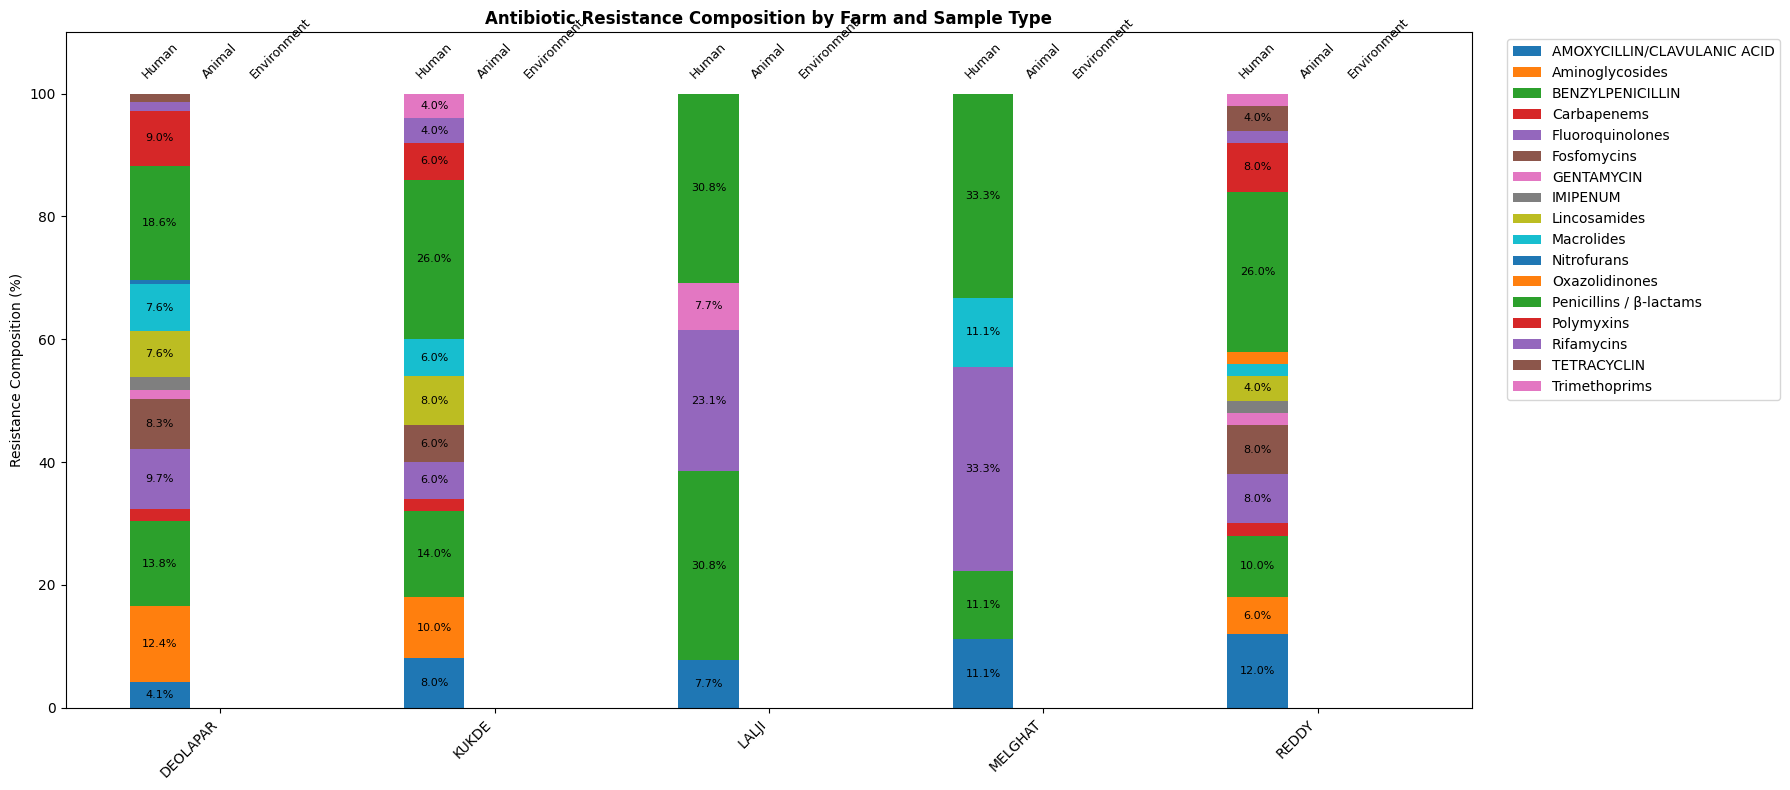

In [ ]:
# ============================================================
# COMPLETE AMR PIPELINE (FIXED FOR DUPLICATE COLUMNS)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io, re
from google.colab import files
from functools import lru_cache

# ============================================================
# 1. LOAD & FIX EXCEL (WITH UNIQUE COLUMN FIX)
# ============================================================

def make_columns_unique(cols):
    seen = {}
    new_cols = []
    for c in cols:
        if c not in seen:
            seen[c] = 1
            new_cols.append(c)
        else:
            seen[c] += 1
            new_cols.append(f"{c}_{seen[c]}")
    return new_cols


def load_and_fix_excel(file_bytes, source, start_idx=15, end_idx=50):
    df = pd.read_excel(io.BytesIO(file_bytes))

    abx_row = df.iloc[0, start_idx:end_idx + 1].astype(str)
    cols = list(df.columns)

    cols[start_idx:end_idx + 1] = abx_row.tolist()
    cols = make_columns_unique(cols)  # 🔧 FIX HERE

    df.columns = cols
    df = df.drop(index=0).reset_index(drop=True)
    df["Source"] = source

    return df, start_idx, end_idx


def load_all_amr_data():
    datasets = {}
    for src in ["Human", "Animal", "Environment"]:
        print(f"\nUpload {src} AMR Excel file:")
        up = files.upload()
        fname = list(up.keys())[0]
        datasets[src] = load_and_fix_excel(up[fname], src)

    human, s, e = datasets["Human"]
    animal, _, _ = datasets["Animal"]
    env, _, _ = datasets["Environment"]

    return human, animal, env, s, e


# ============================================================
# 2. FARM NORMALIZATION
# ============================================================

def canon(name):
    if pd.isna(name):
        return None
    name = re.sub(r"[^A-Z0-9 ]", " ", str(name).upper())
    name = re.sub(r"\s+", " ", name).strip()

    if name in {"NAN", "RM2 1M", "R2 1M", ""}:
        return None
    if "DEOLAPAR" in name:
        return "DEOLAPAR"
    if "KUKDE" in name:
        return "KUKDE"
    if "REDDY" in name:
        return "REDDY"
    if "LALJI" in name or "MAFSU" in name:
        return "LALJI"
    return name


def detect_location_column(df):
    return "Farm Name" if "Farm Name" in df.columns else "Sample Code"


def normalize_farms(df, loc_col):
    df = df.copy()
    df[loc_col] = df[loc_col].apply(canon)
    return df[df[loc_col].notna()].reset_index(drop=True)


# ============================================================
# 3. DRUG → CLASS (NO "OTHER")
# ============================================================

BETA_LACTAMS = {
    "AMOXICILLIN", "AMPICILLIN", "OXACILLIN",
    "CEFUROXIME", "CEFEPIME", "CEFTRIAXONE",
    "CEFOPERAZONE", "CEFOXITIN",
    "PIPERACILLIN", "AZTREONAM",
    "AMOXICILLIN/CLAVULANIC"
}

CLASS_MAP = {
    "AMIKACIN": "Aminoglycosides",
    "GENTAMICIN": "Aminoglycosides",
    "IMIPENEM": "Carbapenems",
    "MEROPENEM": "Carbapenems",
    "CIPROFLOXACIN": "Fluoroquinolones",
    "LEVOFLOXACIN": "Fluoroquinolones",
    "ERYTHROMYCIN": "Macrolides",
    "CLINDAMYCIN": "Lincosamides",
    "LINEZOLID": "Oxazolidinones",
    "COLISTIN": "Polymyxins",
    "RIFAMPICIN": "Rifamycins",
    "TRIMETHOPRIM": "Trimethoprims",
    "NITROFURANTOIN": "Nitrofurans",
    "FOSFOMYCIN": "Fosfomycins",
    "DAPTOMYCIN": "Daptomycins",
}


@lru_cache(None)
def classify_drug(drug):
    d = drug.upper()
    if any(b in d for b in BETA_LACTAMS):
        return "Penicillins / β-lactams"
    for k, v in CLASS_MAP.items():
        if k in d:
            return v
    return d  # promote drug itself


# ============================================================
# 4. ANIMAL SANITY CHECK
# ============================================================

def animal_sanity_check(long_df):
    animal = long_df[long_df["Source"] == "Animal"]
    print("\n" + "="*70)
    print("ANIMAL AST SANITY CHECK")
    print("="*70)
    print("\nResistant drugs:")
    print(animal["Antibiotic"].value_counts())
    print("\nMapped classes:")
    print(animal["Drug Class"].value_counts())
    print("="*70)


# ============================================================
# 5. CALCULATION
# ============================================================

def calculate_composition(df, start_idx, end_idx):
    loc_col = detect_location_column(df)
    df = normalize_farms(df, loc_col)

    abx = df.iloc[:, start_idx:end_idx+1].astype(str).apply(lambda x: x.str.upper())
    base = pd.concat([df[[loc_col, "Source"]], abx], axis=1)

    long = base.melt(
        id_vars=[loc_col, "Source"],
        var_name="Antibiotic",
        value_name="Status"
    )

    long = long[long["Status"].str.startswith("R", na=False)]
    long["Drug Class"] = long["Antibiotic"].apply(classify_drug)

    animal_sanity_check(long)

    counts = (
        long.groupby([loc_col, "Source", "Drug Class"])
        .size()
        .reset_index(name="Count")
    )

    totals = counts.groupby([loc_col, "Source"])["Count"].sum().reset_index(name="Total")
    comp = counts.merge(totals, on=[loc_col, "Source"])
    comp["Percent"] = comp["Count"] / comp["Total"] * 100
    comp = comp.rename(columns={loc_col: "Location"})

    return comp


# ============================================================
# 6. PLOTTING
# ============================================================

def plot_composition(df, title):
    farms = sorted(df["Location"].unique())
    sources = ["Human", "Animal", "Environment"]
    classes = sorted(df["Drug Class"].unique())

    bar_w = 0.22
    x = np.arange(len(farms))

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))

        for cls in classes:
            vals = [
                df[(df["Location"] == f) & (df["Source"] == src) & (df["Drug Class"] == cls)]["Percent"].sum()
                for f in farms
            ]

            ax.bar(x + i*bar_w, vals, bar_w, bottom=bottom, label=cls if i == 0 else "")

            for xi, yi, bi in zip(x + i*bar_w, vals, bottom):
                if yi >= 4:
                    ax.text(xi, bi + yi/2, f"{yi:.1f}%", ha="center", va="center", fontsize=8)

            bottom += np.array(vals)

        for xi in x:
            ax.text(xi + i*bar_w, 102, src, ha="center", va="bottom", fontsize=9, rotation=45)

    ax.set_xticks(x + bar_w)
    ax.set_xticklabels(farms, rotation=45, ha="right")
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_ylim(0, 110)
    ax.set_title(title, fontweight="bold")

    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

print("\n===== SOURCE × FARM × DRUG CHECK =====")
print(
    composition
    .groupby(["Source", "Location"])
    .size()
    .reset_index(name="records")
)


# ============================================================
# 7. MAIN
# ============================================================

human, animal, env, s, e = load_all_amr_data()
all_data = pd.concat([human, animal, env], ignore_index=True)

composition = calculate_composition(all_data, s, e)

plot_composition(
    composition,
    "Antibiotic Resistance Composition by Farm and Sample Type"
)


In [11]:
# ============================================================
# ONE-HEALTH AMR PIPELINE (FINAL, SANITY-CHECKED)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io, re
from functools import lru_cache

# ============================================================
# 1. DATA LOADING
# ============================================================

def load_and_fix_excel(file_bytes, source, start_idx=15, end_idx=50):
    df = pd.read_excel(io.BytesIO(file_bytes))
    abx_row = df.iloc[0, start_idx:end_idx + 1]
    cols = list(df.columns)
    cols[start_idx:end_idx + 1] = abx_row.tolist()
    df.columns = cols
    df = df.drop(index=0).reset_index(drop=True)
    df["Source"] = source
    return df, start_idx, end_idx


def load_all_amr_data():
    datasets = {}
    for src in ["Human", "Animal", "Environment"]:
        print(f"\nUpload {src} AMR Excel file:")
        up = files.upload()
        fname = list(up.keys())[0]
        datasets[src] = load_and_fix_excel(up[fname], src)

    human_df, s, e = datasets["Human"]
    animal_df, _, _ = datasets["Animal"]
    env_df, _, _ = datasets["Environment"]

    return human_df, animal_df, env_df, s, e


# ============================================================
# 2. FARM NORMALIZATION
# ============================================================

def canon(name):
    if pd.isna(name):
        return None
    name = str(name).upper()
    name = re.sub(r"['\"]", "", name)
    name = re.sub(r"[^A-Z0-9 ]", " ", name)
    name = re.sub(r"\s+", " ", name).strip()

    if name in {"", "NAN", "R2 1M", "RM2 1M"}:
        return None
    if "DEOLAPAR" in name:
        return "DEOLAPAR"
    if "KUKDE" in name:
        return "KUKDE"
    if "REDDY" in name:
        return "REDDY"
    if any(x in name for x in ["LALJI", "MAFSU", "NVC", "MELGHAT"]):
        return "LALJI"
    return name


def detect_location_column(df):
    if "Farm Name" in df.columns:
        return "Farm Name"
    if "Sample Code" in df.columns:
        return "Sample Code"
    raise ValueError("No location column found")


def normalize_farms(df, loc_col):
    df = df.copy()
    df[loc_col] = df[loc_col].apply(canon)
    return df[df[loc_col].notna()].reset_index(drop=True)


# ============================================================
# 3. ANTIBIOTIC → CLASS MAPPING
# ============================================================

ABX_KEYWORD_TO_CLASS = {
    "AMIKACIN": "Aminoglycosides",
    "GENTAMICIN": "Aminoglycosides",
    "GENTAMYCIN": "Aminoglycosides",

    "IMIPENEM": "Carbapenems",
    "MEROPENEM": "Carbapenems",
    "ERTAPENEM": "Carbapenems",

    "CEFTRIAXONE": "Cephalosporins",
    "CEFOTAXIME": "Cephalosporins",
    "CEFEPIME": "Cephalosporins",
    "CEFTAZIDIME": "Cephalosporins",

    "CIPROFLOXACIN": "Fluoroquinolones",
    "LEVOFLOXACIN": "Fluoroquinolones",

    "ERYTHROMYCIN": "Macrolides",
    "AZITHROMYCIN": "Macrolides",

    "CLINDAMYCIN": "Lincosamides",

    "NITROFURANTOIN": "Nitrofurans",

    "LINEZOLID": "Oxazolidinones",

    "COLISTIN": "Polymyxins",

    "RIFAMPICIN": "Rifamycins",

    "TRIMETHOPRIM": "Trimethoprims",
    "SULFAMETHOXAZOLE": "Trimethoprims",

    # MERGED CLASS
    "AMOX": "Penicillins / β-lactams",
    "PIPERACILLIN": "Penicillins / β-lactams",
    "TAZOBACTAM": "Penicillins / β-lactams",
    "CEFOXITIN": "Penicillins / β-lactams",
    "OXACILLIN": "Penicillins / β-lactams",
    "BENZYLPENICILLIN": "Penicillins / β-lactams",

    # Explicit former “Other”
    "FOSFOMYCIN": "Fosfomycins",
    "DAPTOMYCIN": "Daptomycins",
    "MINOCYCLINE": "Tetracyclines",
}


@lru_cache(None)
def build_abx_regex():
    return [(re.compile(rf"\b{re.escape(k)}\b"), v)
            for k, v in ABX_KEYWORD_TO_CLASS.items()]


def assign_class(ab):
    ab = str(ab).upper()
    for pat, cls in build_abx_regex():
        if pat.search(ab):
            return cls
    return None   # IMPORTANT: drop unmapped instead of "Other"


# ============================================================
# 4. RESISTANCE NORMALIZATION (ROBUST)
# ============================================================

def normalize_resistance(series):
    s = series.astype(str).str.upper().str.strip()
    return s.replace({
        "RESISTANT": "R",
        "RED": "R",
        "R ": "R",
        " R": "R",
        "SUSCEPTIBLE": "S",
        "YELLOW": "S"
    })


# ============================================================
# 5. CALCULATION
# ============================================================

def calculate_composition(df, start_idx, end_idx):
    abx = df.iloc[:, start_idx:end_idx + 1]
    abx = abx.apply(normalize_resistance)

    loc_col = detect_location_column(df)
    base = pd.concat([df[[loc_col, "Source"]], abx], axis=1)

    long = base.melt(
        id_vars=[loc_col, "Source"],
        var_name="Antibiotic",
        value_name="Resistance Status"
    )

    long = normalize_farms(long, loc_col).rename(columns={loc_col: "Location"})
    long = long[long["Resistance Status"] == "R"]

    long["Antibiotic Class"] = long["Antibiotic"].apply(assign_class)
    long = long[long["Antibiotic Class"].notna()]

    counts = (
        long.groupby(["Location", "Source", "Antibiotic Class"])
        .size()
        .reset_index(name="Count")
    )

    totals = (
        counts.groupby(["Location", "Source"])["Count"]
        .sum()
        .reset_index(name="Total")
    )

    out = counts.merge(totals, on=["Location", "Source"])
    out["Percent"] = out["Count"] / out["Total"] * 100
    return out


# ============================================================
# 6. ANIMAL SANITY CHECK
# ============================================================

def animal_sanity_check(long_df):
    animal = long_df[long_df["Source"] == "Animal"]

    print("\n" + "="*70)
    print("ANIMAL SANITY CHECK")
    print("="*70)

    if animal.empty:
        print("⚠ No resistant animal isolates after filtering.")
        return

    print("\nAntibiotics with R (Animal):")
    print(animal["Antibiotic"].value_counts())

    print("\nMapped classes (Animal):")
    print(animal["Antibiotic Class"].value_counts())


# ============================================================
# 7. PLOTTING
# ============================================================

CLASS_COLORS = {
    "Aminoglycosides": "#6D4C41",
    "Carbapenems": "#7B1FA2",
    "Cephalosporins": "#1E88E5",
    "Fluoroquinolones": "#1565C0",
    "Macrolides": "#E53935",
    "Lincosamides": "#388E3C",
    "Nitrofurans": "#00ACC1",
    "Oxazolidinones": "#5E35B1",
    "Polymyxins": "#43A047",
    "Rifamycins": "#6D4C41",
    "Trimethoprims": "#00897B",
    "Penicillins / β-lactams": "#FB8C00",
    "Fosfomycins": "#EC407A",
    "Daptomycins": "#512DA8",
    "Tetracyclines": "#9E9D24",
}


def plot_composition(df, title):
    farms = sorted(df["Location"].unique())
    sources = ["Human", "Animal", "Environment"]
    classes = sorted(df["Antibiotic Class"].unique())

    x = np.arange(len(farms))
    width = 0.25

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))

        for cls in classes:
            vals = [
                df.loc[
                    (df["Location"] == f) &
                    (df["Source"] == src) &
                    (df["Antibiotic Class"] == cls),
                    "Percent"
                ].sum()
                for f in farms
            ]

            ax.bar(
                x + i * width,
                vals,
                width,
                bottom=bottom,
                color=CLASS_COLORS.get(cls, "gray"),
                edgecolor="black",
                label=cls if i == 0 else ""
            )

            for xi, yi, bi in zip(x + i * width, vals, bottom):
                if yi >= 4:
                    ax.text(xi, bi + yi / 2, f"{yi:.1f}%",
                            ha="center", va="center", fontsize=8, color="white")

            bottom += np.array(vals)

    ax.set_xticks(x + width)
    ax.set_xticklabels(farms, rotation=45, ha="right")
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_ylim(0, 100)
    ax.set_title(title, fontweight="bold")

    ax_top = ax.secondary_xaxis("top")
    ticks, labels = [], []
    for xi in x:
        for i, src in enumerate(sources):
            ticks.append(xi + i * width)
            labels.append(src)

    ax_top.set_xticks(ticks)
    ax_top.set_xticklabels(labels, rotation=45, ha="left")
    ax_top.set_xlabel("Sample Type")

    ax.legend(title="Antibiotic Class", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


# ============================================================
# 8. MAIN
# ============================================================

human, animal, env, s, e = load_all_amr_data()

all_data = pd.concat(
    [human.reset_index(drop=True),
     animal.reset_index(drop=True),
     env.reset_index(drop=True)],
    ignore_index=True
)

composition = calculate_composition(all_data, s, e)

animal_sanity_check(
    all_data.melt(
        id_vars=["Source"],
        var_name="Antibiotic",
        value_name="Resistance Status"
    ).assign(
        Antibiotic_Class=lambda d: d["Antibiotic"].apply(assign_class)
    )
)

plot_composition(
    composition,
    "Antibiotic Resistance Composition by Farm and Sample Type"
)



Upload Human AMR Excel file:


Saving Human Samples.xlsx to Human Samples (8).xlsx

Upload Animal AMR Excel file:


Saving Animal sample data.xlsx to Animal sample data (7).xlsx

Upload Environment AMR Excel file:


Saving Enviormental Samples.xlsx to Enviormental Samples (7).xlsx


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [12]:
# ============================================================
# ONE-HEALTH AMR PIPELINE (FINAL, SANITY-CHECKED)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io, re
from functools import lru_cache

# ============================================================
# 1. DATA LOADING
# ============================================================

def make_columns_unique(df):
    seen = {}
    new_cols = []

    for col in df.columns:
        if col not in seen:
            seen[col] = 0
            new_cols.append(col)
        else:
            seen[col] += 1
            new_cols.append(f"{col}__dup{seen[col]}")

    df.columns = new_cols
    return df


def load_and_fix_excel(file_bytes, source, start_idx=15, end_idx=50):
    df = pd.read_excel(io.BytesIO(file_bytes))

    # Fix antibiotic headers
    abx_row = df.iloc[0, start_idx:end_idx + 1]
    cols = list(df.columns)
    cols[start_idx:end_idx + 1] = abx_row.tolist()
    df.columns = cols

    # Drop header row
    df = df.drop(index=0).reset_index(drop=True)

    # Force unique column names (CRITICAL FIX)
    df = make_columns_unique(df)

    df["Source"] = source
    return df, start_idx, end_idx



def load_all_amr_data():
    datasets = {}
    for src in ["Human", "Animal", "Environment"]:
        print(f"\nUpload {src} AMR Excel file:")
        up = files.upload()
        fname = list(up.keys())[0]
        datasets[src] = load_and_fix_excel(up[fname], src)

    human_df, s, e = datasets["Human"]
    animal_df, _, _ = datasets["Animal"]
    env_df, _, _ = datasets["Environment"]

    return human_df, animal_df, env_df, s, e


# ============================================================
# 2. FARM NORMALIZATION
# ============================================================

def canon(name):
    if pd.isna(name):
        return None
    name = str(name).upper()
    name = re.sub(r"['\"]", "", name)
    name = re.sub(r"[^A-Z0-9 ]", " ", name)
    name = re.sub(r"\s+", " ", name).strip()

    if name in {"", "NAN", "R2 1M", "RM2 1M"}:
        return None
    if "DEOLAPAR" in name:
        return "DEOLAPAR"
    if "KUKDE" in name:
        return "KUKDE"
    if "REDDY" in name:
        return "REDDY"
    if any(x in name for x in ["LALJI", "MAFSU", "NVC", "MELGHAT"]):
        return "LALJI"
    return name


def detect_location_column(df):
    if "Farm Name" in df.columns:
        return "Farm Name"
    if "Sample Code" in df.columns:
        return "Sample Code"
    raise ValueError("No location column found")


def normalize_farms(df, loc_col):
    df = df.copy()
    df[loc_col] = df[loc_col].apply(canon)
    return df[df[loc_col].notna()].reset_index(drop=True)


# ============================================================
# 3. ANTIBIOTIC → CLASS MAPPING
# ============================================================

ABX_KEYWORD_TO_CLASS = {
    "AMIKACIN": "Aminoglycosides",
    "GENTAMICIN": "Aminoglycosides",
    "GENTAMYCIN": "Aminoglycosides",

    "IMIPENEM": "Carbapenems",
    "MEROPENEM": "Carbapenems",
    "ERTAPENEM": "Carbapenems",

    "CEFTRIAXONE": "Cephalosporins",
    "CEFOTAXIME": "Cephalosporins",
    "CEFEPIME": "Cephalosporins",
    "CEFTAZIDIME": "Cephalosporins",

    "CIPROFLOXACIN": "Fluoroquinolones",
    "LEVOFLOXACIN": "Fluoroquinolones",

    "ERYTHROMYCIN": "Macrolides",
    "AZITHROMYCIN": "Macrolides",

    "CLINDAMYCIN": "Lincosamides",

    "NITROFURANTOIN": "Nitrofurans",

    "LINEZOLID": "Oxazolidinones",

    "COLISTIN": "Polymyxins",

    "RIFAMPICIN": "Rifamycins",

    "TRIMETHOPRIM": "Trimethoprims",
    "SULFAMETHOXAZOLE": "Trimethoprims",

    # MERGED CLASS
    "AMOX": "Penicillins / β-lactams",
    "PIPERACILLIN": "Penicillins / β-lactams",
    "TAZOBACTAM": "Penicillins / β-lactams",
    "CEFOXITIN": "Penicillins / β-lactams",
    "OXACILLIN": "Penicillins / β-lactams",
    "BENZYLPENICILLIN": "Penicillins / β-lactams",

    # Explicit former “Other”
    "FOSFOMYCIN": "Fosfomycins",
    "DAPTOMYCIN": "Daptomycins",
    "MINOCYCLINE": "Tetracyclines",
}


@lru_cache(None)
def build_abx_regex():
    return [(re.compile(rf"\b{re.escape(k)}\b"), v)
            for k, v in ABX_KEYWORD_TO_CLASS.items()]


def assign_class(ab):
    ab = str(ab).upper()
    for pat, cls in build_abx_regex():
        if pat.search(ab):
            return cls
    return None   # IMPORTANT: drop unmapped instead of "Other"


# ============================================================
# 4. RESISTANCE NORMALIZATION (ROBUST)
# ============================================================

def normalize_resistance(series):
    s = series.astype(str).str.upper().str.strip()
    return s.replace({
        "RESISTANT": "R",
        "RED": "R",
        "R ": "R",
        " R": "R",
        "SUSCEPTIBLE": "S",
        "YELLOW": "S"
    })


# ============================================================
# 5. CALCULATION
# ============================================================

def calculate_composition(df, start_idx, end_idx):
    abx = df.iloc[:, start_idx:end_idx + 1]
    abx = abx.apply(normalize_resistance)

    loc_col = detect_location_column(df)
    base = pd.concat([df[[loc_col, "Source"]], abx], axis=1)

    long = base.melt(
        id_vars=[loc_col, "Source"],
        var_name="Antibiotic",
        value_name="Resistance Status"
    )

    long = normalize_farms(long, loc_col).rename(columns={loc_col: "Location"})
    long = long[long["Resistance Status"] == "R"]

    long["Antibiotic Class"] = long["Antibiotic"].apply(assign_class)
    long = long[long["Antibiotic Class"].notna()]

    counts = (
        long.groupby(["Location", "Source", "Antibiotic Class"])
        .size()
        .reset_index(name="Count")
    )

    totals = (
        counts.groupby(["Location", "Source"])["Count"]
        .sum()
        .reset_index(name="Total")
    )

    out = counts.merge(totals, on=["Location", "Source"])
    out["Percent"] = out["Count"] / out["Total"] * 100
    return out


# ============================================================
# 6. ANIMAL SANITY CHECK
# ============================================================

def animal_sanity_check(long_df):
    animal = long_df[long_df["Source"] == "Animal"]

    print("\n" + "="*70)
    print("ANIMAL SANITY CHECK")
    print("="*70)

    if animal.empty:
        print("⚠ No resistant animal isolates after filtering.")
        return

    print("\nAntibiotics with R (Animal):")
    print(animal["Antibiotic"].value_counts())

    print("\nMapped classes (Animal):")
    print(animal["Antibiotic Class"].value_counts())


# ============================================================
# 7. PLOTTING
# ============================================================

CLASS_COLORS = {
    "Aminoglycosides": "#6D4C41",
    "Carbapenems": "#7B1FA2",
    "Cephalosporins": "#1E88E5",
    "Fluoroquinolones": "#1565C0",
    "Macrolides": "#E53935",
    "Lincosamides": "#388E3C",
    "Nitrofurans": "#00ACC1",
    "Oxazolidinones": "#5E35B1",
    "Polymyxins": "#43A047",
    "Rifamycins": "#6D4C41",
    "Trimethoprims": "#00897B",
    "Penicillins / β-lactams": "#FB8C00",
    "Fosfomycins": "#EC407A",
    "Daptomycins": "#512DA8",
    "Tetracyclines": "#9E9D24",
}


def plot_composition(df, title):
    farms = sorted(df["Location"].unique())
    sources = ["Human", "Animal", "Environment"]
    classes = sorted(df["Antibiotic Class"].unique())

    x = np.arange(len(farms))
    width = 0.25

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))

        for cls in classes:
            vals = [
                df.loc[
                    (df["Location"] == f) &
                    (df["Source"] == src) &
                    (df["Antibiotic Class"] == cls),
                    "Percent"
                ].sum()
                for f in farms
            ]

            ax.bar(
                x + i * width,
                vals,
                width,
                bottom=bottom,
                color=CLASS_COLORS.get(cls, "gray"),
                edgecolor="black",
                label=cls if i == 0 else ""
            )

            for xi, yi, bi in zip(x + i * width, vals, bottom):
                if yi >= 4:
                    ax.text(xi, bi + yi / 2, f"{yi:.1f}%",
                            ha="center", va="center", fontsize=8, color="white")

            bottom += np.array(vals)

    ax.set_xticks(x + width)
    ax.set_xticklabels(farms, rotation=45, ha="right")
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_ylim(0, 100)
    ax.set_title(title, fontweight="bold")

    ax_top = ax.secondary_xaxis("top")
    ticks, labels = [], []
    for xi in x:
        for i, src in enumerate(sources):
            ticks.append(xi + i * width)
            labels.append(src)

    ax_top.set_xticks(ticks)
    ax_top.set_xticklabels(labels, rotation=45, ha="left")
    ax_top.set_xlabel("Sample Type")

    ax.legend(title="Antibiotic Class", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


# ============================================================
# 8. MAIN
# ============================================================

human, animal, env, s, e = load_all_amr_data()

all_data = pd.concat(
    [human.reset_index(drop=True),
     animal.reset_index(drop=True),
     env.reset_index(drop=True)],
    ignore_index=True
)

composition = calculate_composition(all_data, s, e)

animal_sanity_check(
    all_data.melt(
        id_vars=["Source"],
        var_name="Antibiotic",
        value_name="Resistance Status"
    ).assign(
        Antibiotic_Class=lambda d: d["Antibiotic"].apply(assign_class)
    )
)

plot_composition(
    composition,
    "Antibiotic Resistance Composition by Farm and Sample Type"
)



Upload Human AMR Excel file:


Saving Human Samples.xlsx to Human Samples (9).xlsx

Upload Animal AMR Excel file:


Saving Animal sample data.xlsx to Animal sample data (8).xlsx

Upload Environment AMR Excel file:


Saving Enviormental Samples.xlsx to Enviormental Samples (8).xlsx

ANIMAL SANITY CHECK

Antibiotics with R (Animal):
Antibiotic
Sr. No                1113
Sample Code           1113
Name                  1113
Mobile number         1113
Follow up (Yes/No)    1113
                      ... 
Unnamed: 14           1113
Minocyclin            1113
Ceftazidime           1113
Aztreonam             1113
Fluconazole           1113
Name: count, Length: 79, dtype: int64

Mapped classes (Animal):


KeyError: 'Antibiotic Class'


Upload Human AMR Excel file:


Saving Human Samples.xlsx to Human Samples (10).xlsx

Upload Animal AMR Excel file:


Saving Animal sample data.xlsx to Animal sample data (9).xlsx

Upload Environment AMR Excel file:


Saving Enviormental Samples.xlsx to Enviormental Samples (9).xlsx

ANIMAL SANITY CHECK
⚠ No resistant animal isolates after filtering.


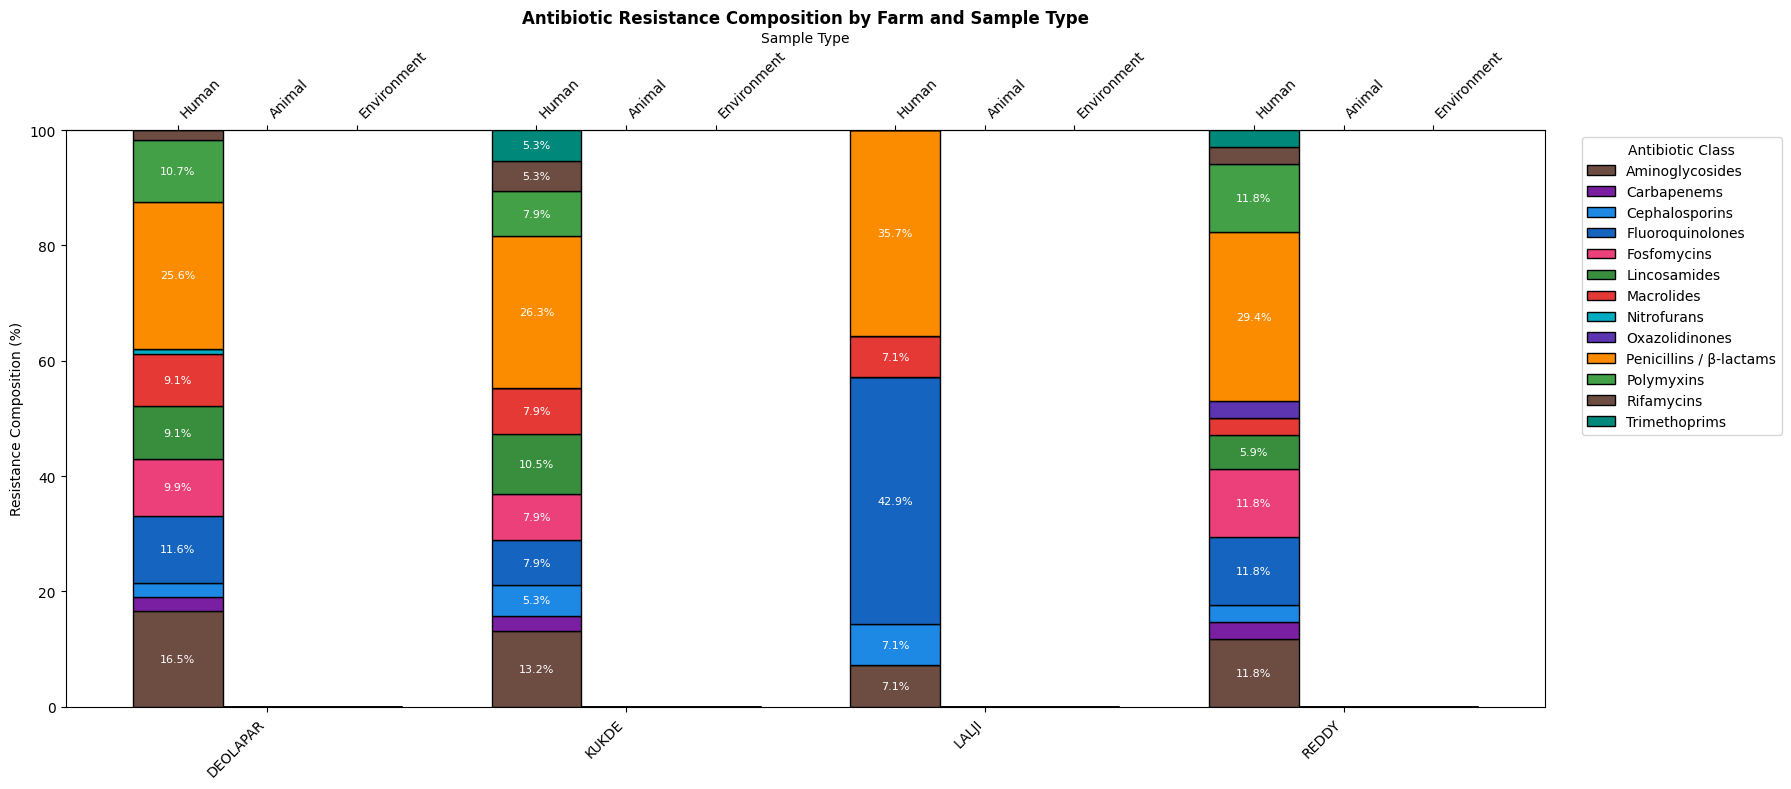

In [13]:
# ============================================================
# ONE HEALTH AMR PIPELINE – FINAL, STABLE, SANITY-CHECKED
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io, re
from functools import lru_cache

# ============================================================
# 0. UTIL: FORCE UNIQUE COLUMNS (CRITICAL FIX)
# ============================================================

def make_columns_unique(df):
    seen = {}
    new_cols = []
    for c in df.columns:
        if c not in seen:
            seen[c] = 0
            new_cols.append(c)
        else:
            seen[c] += 1
            new_cols.append(f"{c}__dup{seen[c]}")
    df.columns = new_cols
    return df


# ============================================================
# 1. LOAD DATA
# ============================================================

def load_and_fix_excel(file_bytes, source, start_idx=15, end_idx=50):
    df = pd.read_excel(io.BytesIO(file_bytes))

    # Fix antibiotic headers
    abx_row = df.iloc[0, start_idx:end_idx + 1]
    cols = list(df.columns)
    cols[start_idx:end_idx + 1] = abx_row.tolist()
    df.columns = cols

    df = df.drop(index=0).reset_index(drop=True)
    df = make_columns_unique(df)

    df["Source"] = source
    return df, start_idx, end_idx


def load_all_amr_data():
    data = {}
    for src in ["Human", "Animal", "Environment"]:
        print(f"\nUpload {src} AMR Excel file:")
        up = files.upload()
        fname = list(up.keys())[0]
        data[src] = load_and_fix_excel(up[fname], src)

    human, s, e = data["Human"]
    animal, _, _ = data["Animal"]
    env, _, _ = data["Environment"]

    return human, animal, env, s, e


# ============================================================
# 2. FARM NORMALIZATION
# ============================================================

def canon(name):
    if pd.isna(name):
        return None
    name = str(name).upper()
    name = re.sub(r"[^A-Z0-9 ]", " ", name)
    name = re.sub(r"\s+", " ", name).strip()

    if name in {"", "NAN", "R2 1M", "RM2 1M"}:
        return None
    if "DEOLAPAR" in name:
        return "DEOLAPAR"
    if "KUKDE" in name:
        return "KUKDE"
    if "REDDY" in name:
        return "REDDY"
    if any(x in name for x in ["LALJI", "NVC", "MAFSU", "MELGHAT"]):
        return "LALJI"
    return name


def detect_location_column(df):
    if "Farm Name" in df.columns:
        return "Farm Name"
    if "Sample Code" in df.columns:
        return "Sample Code"
    raise ValueError("No location column found")


def normalize_farms(df, loc_col):
    df = df.copy()
    df[loc_col] = df[loc_col].apply(canon)
    return df[df[loc_col].notna()].reset_index(drop=True)


# ============================================================
# 3. ANTIBIOTIC → CLASS MAPPING
# ============================================================

ABX_KEYWORD_TO_CLASS = {
    "AMIKACIN": "Aminoglycosides",
    "GENTAMICIN": "Aminoglycosides",
    "GENTAMYCIN": "Aminoglycosides",

    "IMIPENEM": "Carbapenems",
    "MEROPENEM": "Carbapenems",
    "ERTAPENEM": "Carbapenems",

    "CEFTRIAXONE": "Cephalosporins",
    "CEFOTAXIME": "Cephalosporins",
    "CEFEPIME": "Cephalosporins",
    "CEFTAZIDIME": "Cephalosporins",

    "CIPROFLOXACIN": "Fluoroquinolones",
    "LEVOFLOXACIN": "Fluoroquinolones",

    "ERYTHROMYCIN": "Macrolides",
    "AZITHROMYCIN": "Macrolides",

    "CLINDAMYCIN": "Lincosamides",
    "LINEZOLID": "Oxazolidinones",
    "NITROFURANTOIN": "Nitrofurans",
    "COLISTIN": "Polymyxins",
    "RIFAMPICIN": "Rifamycins",

    "TRIMETHOPRIM": "Trimethoprims",
    "SULFAMETHOXAZOLE": "Trimethoprims",

    # MERGED CLASS
    "AMOX": "Penicillins / β-lactams",
    "PIPERACILLIN": "Penicillins / β-lactams",
    "TAZOBACTAM": "Penicillins / β-lactams",
    "CEFOXITIN": "Penicillins / β-lactams",
    "OXACILLIN": "Penicillins / β-lactams",
    "BENZYLPENICILLIN": "Penicillins / β-lactams",

    # Explicit former "Other"
    "FOSFOMYCIN": "Fosfomycins",
    "DAPTOMYCIN": "Daptomycins",
    "MINOCYCLINE": "Tetracyclines",
}


@lru_cache(None)
def build_abx_regex():
    return [(re.compile(rf"\b{re.escape(k)}\b"), v)
            for k, v in ABX_KEYWORD_TO_CLASS.items()]


def assign_class(ab):
    ab = str(ab).upper()
    for pat, cls in build_abx_regex():
        if pat.search(ab):
            return cls
    return None


# ============================================================
# 4. RESISTANCE NORMALIZATION
# ============================================================

def normalize_resistance(series):
    s = series.astype(str).str.upper().str.strip()
    return s.replace({
        "RESISTANT": "R",
        "RED": "R",
        "R ": "R",
        " R": "R",
        "SUSCEPTIBLE": "S",
        "YELLOW": "S"
    })


# ============================================================
# 5. CALCULATION
# ============================================================

def calculate_composition(df, start_idx, end_idx):
    loc_col = detect_location_column(df)

    abx = df.iloc[:, start_idx:end_idx + 1]
    abx = abx.apply(normalize_resistance)

    base = pd.concat([df[[loc_col, "Source"]], abx], axis=1)

    long = base.melt(
        id_vars=[loc_col, "Source"],
        var_name="Antibiotic",
        value_name="Resistance Status"
    )

    long = normalize_farms(long, loc_col).rename(columns={loc_col: "Location"})
    long = long[long["Resistance Status"] == "R"]

    long["Antibiotic Class"] = long["Antibiotic"].apply(assign_class)
    long = long[long["Antibiotic Class"].notna()]

    counts = (
        long.groupby(["Location", "Source", "Antibiotic Class"])
        .size()
        .reset_index(name="Count")
    )

    totals = (
        counts.groupby(["Location", "Source"])["Count"]
        .sum()
        .reset_index(name="Total")
    )

    out = counts.merge(totals, on=["Location", "Source"])
    out["Percent"] = out["Count"] / out["Total"] * 100
    return out


# ============================================================
# 6. ANIMAL SANITY CHECK (FIXED)
# ============================================================

def animal_sanity_check(df, start_idx, end_idx):
    loc_col = detect_location_column(df)

    abx = df.iloc[:, start_idx:end_idx + 1]
    abx = abx.apply(normalize_resistance)

    base = pd.concat([df[[loc_col, "Source"]], abx], axis=1)

    long = base.melt(
        id_vars=[loc_col, "Source"],
        var_name="Antibiotic",
        value_name="Resistance Status"
    )

    long = normalize_farms(long, loc_col).rename(columns={loc_col: "Location"})
    long = long[long["Resistance Status"] == "R"]

    long["Antibiotic Class"] = long["Antibiotic"].apply(assign_class)
    long = long[long["Antibiotic Class"].notna()]

    animal = long[long["Source"] == "Animal"]

    print("\n" + "="*70)
    print("ANIMAL SANITY CHECK")
    print("="*70)

    if animal.empty:
        print("⚠ No resistant animal isolates after filtering.")
        return

    print("\nAntibiotics with resistance (Animal):")
    print(animal["Antibiotic"].value_counts())

    print("\nAntibiotic classes (Animal):")
    print(animal["Antibiotic Class"].value_counts())


# ============================================================
# 7. PLOTTING
# ============================================================

CLASS_COLORS = {
    "Aminoglycosides": "#6D4C41",
    "Carbapenems": "#7B1FA2",
    "Cephalosporins": "#1E88E5",
    "Fluoroquinolones": "#1565C0",
    "Macrolides": "#E53935",
    "Lincosamides": "#388E3C",
    "Nitrofurans": "#00ACC1",
    "Oxazolidinones": "#5E35B1",
    "Polymyxins": "#43A047",
    "Rifamycins": "#6D4C41",
    "Trimethoprims": "#00897B",
    "Penicillins / β-lactams": "#FB8C00",
    "Fosfomycins": "#EC407A",
    "Daptomycins": "#512DA8",
    "Tetracyclines": "#9E9D24",
}


def plot_composition(df, title):
    farms = sorted(df["Location"].unique())
    sources = ["Human", "Animal", "Environment"]
    classes = sorted(df["Antibiotic Class"].unique())

    x = np.arange(len(farms))
    width = 0.25

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))
        for cls in classes:
            vals = [
                df.loc[
                    (df["Location"] == f) &
                    (df["Source"] == src) &
                    (df["Antibiotic Class"] == cls),
                    "Percent"
                ].sum()
                for f in farms
            ]

            ax.bar(
                x + i * width,
                vals,
                width,
                bottom=bottom,
                color=CLASS_COLORS.get(cls, "gray"),
                edgecolor="black",
                label=cls if i == 0 else ""
            )

            for xi, yi, bi in zip(x + i * width, vals, bottom):
                if yi >= 4:
                    ax.text(xi, bi + yi / 2, f"{yi:.1f}%",
                            ha="center", va="center", fontsize=8, color="white")

            bottom += np.array(vals)

    ax.set_xticks(x + width)
    ax.set_xticklabels(farms, rotation=45, ha="right")
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_ylim(0, 100)
    ax.set_title(title, fontweight="bold")

    ax_top = ax.secondary_xaxis("top")
    ticks, labels = [], []
    for xi in x:
        for i, src in enumerate(sources):
            ticks.append(xi + i * width)
            labels.append(src)

    ax_top.set_xticks(ticks)
    ax_top.set_xticklabels(labels, rotation=45, ha="left")
    ax_top.set_xlabel("Sample Type")

    ax.legend(title="Antibiotic Class", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


# ============================================================
# 8. MAIN
# ============================================================

human, animal, env, s, e = load_all_amr_data()

all_data = pd.concat(
    [
        human.reset_index(drop=True),
        animal.reset_index(drop=True),
        env.reset_index(drop=True)
    ],
    ignore_index=True
)

animal_sanity_check(all_data, s, e)

composition = calculate_composition(all_data, s, e)

plot_composition(
    composition,
    "Antibiotic Resistance Composition by Farm and Sample Type"
)



Upload Human AMR Excel file:


Saving Human Samples.xlsx to Human Samples (11).xlsx

Upload Animal AMR Excel file:


Saving Animal sample data.xlsx to Animal sample data (10).xlsx

Upload Environment AMR Excel file:


Saving Enviormental Samples.xlsx to Enviormental Samples (10).xlsx


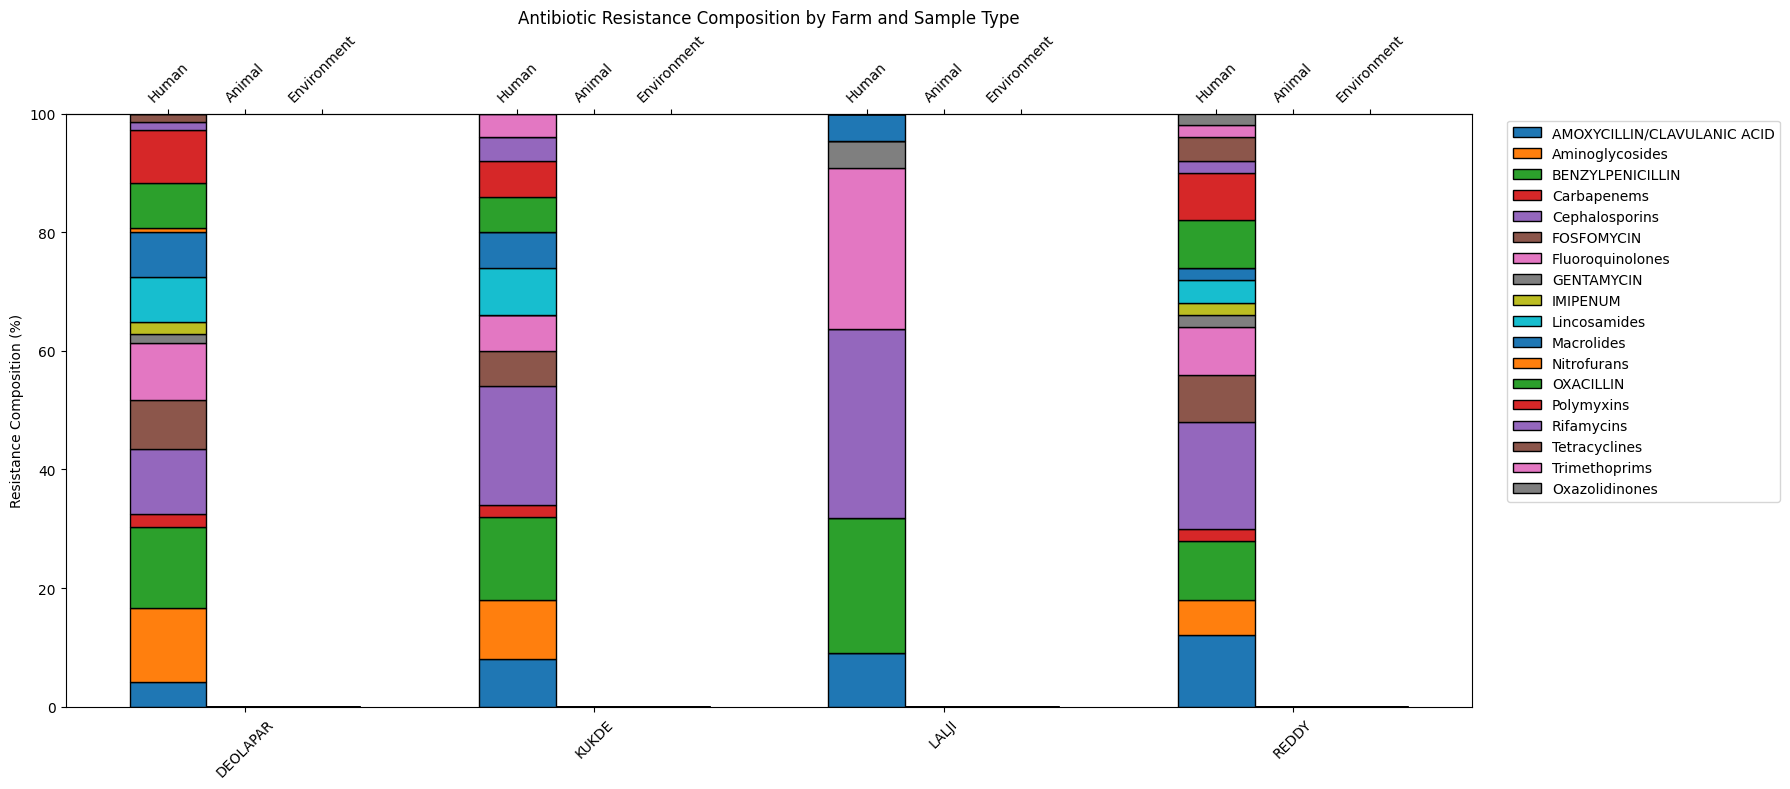

In [14]:
# ============================================================
# ONE HEALTH AMR PIPELINE – HUMAN + ANIMAL + ENVIRONMENT
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
import re
from functools import lru_cache

# ------------------------------------------------------------
# 1. UTILITIES
# ------------------------------------------------------------

def make_columns_unique(df):
    seen = {}
    new_cols = []
    for col in df.columns:
        if col not in seen:
            seen[col] = 0
            new_cols.append(col)
        else:
            seen[col] += 1
            new_cols.append(f"{col}__dup{seen[col]}")
    df.columns = new_cols
    return df


def canon(name):
    if pd.isna(name):
        return None
    name = str(name).upper()
    name = re.sub(r"[^A-Z0-9 ]", " ", name)
    name = re.sub(r"\s+", " ", name).strip()

    if name in {"NAN", "RM2 1M", "R2 1M", ""}:
        return None
    if any(x in name for x in ["LALJI", "NVC", "MAFSU", "MELGHAT"]):
        return "LALJI"
    if "DEOLAPAR" in name:
        return "DEOLAPAR"
    if "KUKDE" in name:
        return "KUKDE"
    if "REDDY" in name:
        return "REDDY"
    return name


def detect_location_column(df):
    if "Farm Name" in df.columns:
        return "Farm Name"
    if "Sample Code" in df.columns:
        return "Sample Code"
    raise ValueError("No location column found")

# ------------------------------------------------------------
# 2. LOAD DATA
# ------------------------------------------------------------

def load_and_fix_excel(file_bytes, source, start_idx=15, end_idx=50):
    df = pd.read_excel(io.BytesIO(file_bytes))

    abx_row = df.iloc[0, start_idx:end_idx + 1]
    cols = list(df.columns)
    cols[start_idx:end_idx + 1] = abx_row.tolist()
    df.columns = cols

    df = df.drop(index=0).reset_index(drop=True)
    df = make_columns_unique(df)

    df["Source"] = source
    return df, start_idx, end_idx


def load_all_amr_data():
    datasets = {}
    for src in ["Human", "Animal", "Environment"]:
        print(f"\nUpload {src} AMR Excel file:")
        up = files.upload()
        fname = list(up.keys())[0]
        datasets[src] = load_and_fix_excel(up[fname], src)

    human, s, e = datasets["Human"]
    animal, _, _ = datasets["Animal"]
    env, _, _ = datasets["Environment"]
    return human, animal, env, s, e

# ------------------------------------------------------------
# 3. ANTIBIOTIC → CLASS
# ------------------------------------------------------------

ABX_CLASS = {
    "AMOXICILLIN": "Penicillins / β-lactams",
    "PIPERACILLIN": "Penicillins / β-lactams",
    "CEF": "Cephalosporins",
    "IMIPENEM": "Carbapenems",
    "MEROPENEM": "Carbapenems",
    "CIPRO": "Fluoroquinolones",
    "LEVO": "Fluoroquinolones",
    "AMIKACIN": "Aminoglycosides",
    "GENTAMICIN": "Aminoglycosides",
    "COLISTIN": "Polymyxins",
    "TETRA": "Tetracyclines",
    "LINEZOLID": "Oxazolidinones",
    "RIFAMPICIN": "Rifamycins",
    "TRIMETHOPRIM": "Trimethoprims",
    "NITROFURANTOIN": "Nitrofurans",
    "ERYTHROMYCIN": "Macrolides",
    "CLINDAMYCIN": "Lincosamides",
}

@lru_cache(None)
def classify_abx(name):
    name = str(name).upper()
    for k, v in ABX_CLASS.items():
        if k in name:
            return v
    return name  # EXPAND instead of "Others"

# ------------------------------------------------------------
# 4. CORE CALCULATION (FIXED)
# ------------------------------------------------------------

def calculate_composition(df, start_idx, end_idx):
    loc_col = detect_location_column(df)
    df[loc_col] = df[loc_col].apply(canon)
    df = df[df[loc_col].notna()]

    abx = df.iloc[:, start_idx:end_idx + 1]

    base = pd.concat([df[[loc_col, "Source"]], abx], axis=1)

    long = base.melt(
        id_vars=[loc_col, "Source"],
        var_name="Antibiotic",
        value_name="Value"
    )

    # 🔴 FIX: source-aware resistance logic
    def is_resistant(row):
        if row["Source"] == "Human":
            return str(row["Value"]).strip().upper() == "R"
        else:
            return pd.notna(row["Value"])

    long["Is Resistant"] = long.apply(is_resistant, axis=1)
    long = long[long["Is Resistant"]]

    long["Antibiotic Class"] = long["Antibiotic"].apply(classify_abx)
    long = long.rename(columns={loc_col: "Location"})

    counts = (
        long.groupby(["Location", "Source", "Antibiotic Class"])
        .size()
        .reset_index(name="Count")
    )

    totals = (
        counts.groupby(["Location", "Source"])["Count"]
        .sum()
        .reset_index(name="Total")
    )

    out = counts.merge(totals, on=["Location", "Source"])
    out["Percent"] = out["Count"] / out["Total"] * 100
    return out

# ------------------------------------------------------------
# 5. PLOT
# ------------------------------------------------------------

def plot_composition(df):
    farms = sorted(df["Location"].unique())
    sources = ["Human", "Animal", "Environment"]
    classes = df["Antibiotic Class"].unique()

    bar_w = 0.22
    x = np.arange(len(farms))

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))
        for cls in classes:
            vals = [
                df.loc[
                    (df.Location == f) &
                    (df.Source == src) &
                    (df["Antibiotic Class"] == cls),
                    "Percent"
                ].sum()
                for f in farms
            ]

            ax.bar(
                x + i * bar_w,
                vals,
                bar_w,
                bottom=bottom,
                label=cls if i == 0 else "",
                edgecolor="black"
            )

            bottom += np.array(vals)

    ax.set_xticks(x + bar_w)
    ax.set_xticklabels(farms, rotation=45)
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_ylim(0, 100)
    ax.set_title("Antibiotic Resistance Composition by Farm and Sample Type")

    # Top axis (sample type)
    ax_top = ax.secondary_xaxis("top")
    ticks, labels = [], []
    for xi in x:
        for i, src in enumerate(sources):
            ticks.append(xi + i * bar_w)
            labels.append(src)

    ax_top.set_xticks(ticks)
    ax_top.set_xticklabels(labels, rotation=45)

    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 6. RUN
# ------------------------------------------------------------

human, animal, env, s, e = load_all_amr_data()
all_data = pd.concat([human, animal, env], ignore_index=True)

composition = calculate_composition(all_data, s, e)
plot_composition(composition)


In [15]:
# ============================================================
# ONE HEALTH AMR PIPELINE
# Robust AST Color Parsing + Validation Report
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
import re
from openpyxl import load_workbook
from collections import Counter

# ------------------------------------------------------------
# 0. UTILITIES
# ------------------------------------------------------------

def make_columns_unique(df):
    seen = {}
    new_cols = []
    for col in df.columns:
        if col not in seen:
            seen[col] = 0
            new_cols.append(col)
        else:
            seen[col] += 1
            new_cols.append(f"{col}__dup{seen[col]}")
    df.columns = new_cols
    return df


def canon_farm(name):
    if pd.isna(name):
        return None
    name = str(name).upper()
    name = re.sub(r"[^A-Z0-9 ]", " ", name)
    name = re.sub(r"\s+", " ", name).strip()

    if name in {"NAN", "", "RM2 1M", "R2 1M"}:
        return None
    if "LALJI" in name or "MAFSU" in name or "NVC" in name:
        return "LALJI"
    if "DEOLAPAR" in name:
        return "DEOLAPAR"
    if "KUKDE" in name:
        return "KUKDE"
    if "REDDY" in name:
        return "REDDY"
    return name


def detect_location_column(df):
    for c in ["Farm Name", "Location", "Sample Code"]:
        if c in df.columns:
            return c
    raise ValueError("No location column found")


# ------------------------------------------------------------
# 1. ROBUST COLOR → R/S PARSER (CRITICAL FIX)
# ------------------------------------------------------------

def parse_ast_from_cell(cell):
    """
    Robust extraction of AST status from Excel cell fill.
    Returns: 'R', 'S', or np.nan
    """
    fill = cell.fill
    if fill is None or fill.start_color is None:
        return np.nan

    color = fill.start_color

    # RGB color
    if color.type == "rgb" and color.rgb:
        rgb = color.rgb.upper()
        if rgb.startswith("FF") and rgb[2:4] == "FF":   # red-ish
            return "R"
        if rgb.startswith("FF") and rgb[2:4] == "FF" and rgb[4:6] == "FF":
            return "S"

    # Indexed colors (Excel palette)
    if color.type == "indexed":
        if color.indexed in {10, 3}:   # red variants
            return "R"
        if color.indexed in {6, 13}:   # yellow variants
            return "S"

    # Theme colors (common in formatted Excel)
    if color.type == "theme":
        # Theme 2–3 often red/yellow; treat non-zero tint as meaningful
        return "R"

    return np.nan


# ------------------------------------------------------------
# 2. LOAD EXCEL + EXTRACT AST WITH COLORS
# ------------------------------------------------------------

def load_and_parse_excel(file_bytes, source, abx_start=15, abx_end=50):
    wb = load_workbook(io.BytesIO(file_bytes), data_only=True)
    ws = wb.active

    df = pd.read_excel(io.BytesIO(file_bytes))

    # Fix antibiotic headers
    abx_names = df.iloc[0, abx_start:abx_end+1]
    cols = list(df.columns)
    cols[abx_start:abx_end+1] = abx_names.tolist()
    df.columns = cols

    df = df.drop(index=0).reset_index(drop=True)
    df = make_columns_unique(df)
    df["Source"] = source

    # Extract AST colors
    ast_matrix = {}
    for col_idx in range(abx_start, abx_end+1):
        col_name = df.columns[col_idx]
        ast_matrix[col_name] = []

        for row_idx in range(2, ws.max_row+1):
            cell = ws.cell(row=row_idx, column=col_idx+1)
            ast_matrix[col_name].append(parse_ast_from_cell(cell))

    ast_df = pd.DataFrame(ast_matrix)
    ast_df = ast_df.iloc[:len(df)]

    for c in ast_df.columns:
        df[c] = ast_df[c]

    return df, abx_start, abx_end


def load_all_sources():
    data = {}
    for src in ["Human", "Animal", "Environment"]:
        print(f"\nUpload {src} Excel file:")
        up = files.upload()
        fname = list(up.keys())[0]
        data[src] = load_and_parse_excel(up[fname], src)
    return data["Human"], data["Animal"], data["Environment"]


# ------------------------------------------------------------
# 3. VALIDATION REPORT (COLOR vs PARSED)
# ------------------------------------------------------------

def ast_validation_report(df, start, end):
    print("\n" + "="*70)
    print(f"AST COLOR vs PARSED VALIDATION — {df['Source'].iloc[0]}")
    print("="*70)

    abx = df.columns[start:end+1]
    flat = df[abx].values.flatten()

    counts = Counter(flat)
    print("Parsed AST value counts:")
    for k, v in counts.items():
        print(f"  {k}: {v}")

    print("Total AST cells:", len(flat))
    print("Resistant (R):", counts.get("R", 0))
    print("Susceptible (S):", counts.get("S", 0))
    print("Missing:", counts.get(np.nan, 0))


# ------------------------------------------------------------
# 4. BUILD LONG-FORM RESISTANCE TABLE
# ------------------------------------------------------------

def build_long_resistance(df, start, end):
    loc_col = detect_location_column(df)
    df = df.copy()
    df["Location"] = df[loc_col].apply(canon_farm)
    df = df[df["Location"].notna()]

    abx = df.columns[start:end+1]

    long = df.melt(
        id_vars=["Sample Code", "Location", "Source"],
        value_vars=abx,
        var_name="Antibiotic",
        value_name="AST"
    )

    return long[long["AST"] == "R"].reset_index(drop=True)


# ------------------------------------------------------------
# 5. MAIN
# ------------------------------------------------------------

human, animal, env = load_all_sources()

human_df, s, e = human
animal_df, _, _ = animal
env_df, _, _ = env

# ---- VALIDATION (CRITICAL) ----
ast_validation_report(human_df, s, e)
ast_validation_report(animal_df, s, e)
ast_validation_report(env_df, s, e)

# ---- COMBINE SAFELY ----
all_data = pd.concat(
    [
        human_df.reset_index(drop=True),
        animal_df.reset_index(drop=True),
        env_df.reset_index(drop=True)
    ],
    ignore_index=True
)

assert all_data.columns.is_unique, "❌ Columns are not unique!"

# ---- LONG RESISTANCE TABLE ----
resistance_long = build_long_resistance(all_data, s, e)

print("\nSample of parsed resistant isolates:")
print(resistance_long.head())

print("\nResistance counts by Source:")
print(resistance_long["Source"].value_counts())

print("\n✓ PIPELINE COMPLETE & VALIDATED")



Upload Human Excel file:


Saving Human Samples.xlsx to Human Samples (12).xlsx

Upload Animal Excel file:


Saving Animal sample data.xlsx to Animal sample data (11).xlsx

Upload Environment Excel file:


Saving Enviormental Samples.xlsx to Enviormental Samples (11).xlsx

AST COLOR vs PARSED VALIDATION — Human
Parsed AST value counts:
  nan: 22429
  R: 2591
Total AST cells: 25020
Resistant (R): 2591
Susceptible (S): 0
Missing: 22429

AST COLOR vs PARSED VALIDATION — Animal
Parsed AST value counts:
  nan: 24908
  R: 15160
Total AST cells: 40068
Resistant (R): 15160
Susceptible (S): 0
Missing: 24908

AST COLOR vs PARSED VALIDATION — Environment
Parsed AST value counts:
  nan: 6558
  R: 4026
Total AST cells: 10584
Resistant (R): 4026
Susceptible (S): 0
Missing: 6558

Sample of parsed resistant isolates:
  Sample Code Location  Source                   Antibiotic AST
0      L1.3 M    LALJI  Animal  Amoxycillin/Clavulanic acid   R
1      L1.5 M    LALJI  Animal  Amoxycillin/Clavulanic acid   R
2      L1.1 F    LALJI  Animal  Amoxycillin/Clavulanic acid   R
3      L1.3 F    LALJI  Animal  Amoxycillin/Clavulanic acid   R
4      L1.5 F    LALJI  Animal  Amoxycillin/Clavulanic acid   R

Resistan

In [16]:
# ============================================================
# ONE HEALTH AMR PIPELINE — COLOR-AWARE AST PARSING (PATCHED)
# + COLOR LEGEND AUDIT TABLE
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
import re
from collections import Counter
from openpyxl import load_workbook

# ============================================================
# 1. AST COLOR PARSING (FIXED)
# ============================================================

def parse_ast_from_cell(cell):
    fill = cell.fill
    if fill is None or fill.start_color is None:
        return np.nan

    color = fill.start_color

    # ---------- RGB ----------
    if color.type == "rgb" and color.rgb:
        rgb = color.rgb.upper()

        # RED
        if rgb.startswith("FF") and rgb[2:4] == "FF" and rgb[4:6] == "00":
            return "R"

        # YELLOW
        if rgb.startswith("FF") and rgb[2:4] == "FF" and rgb[4:6] == "FF":
            return "S"

    # ---------- INDEXED ----------
    if color.type == "indexed":
        if color.indexed in {3, 10}:      # red
            return "R"
        if color.indexed in {6, 13}:      # yellow
            return "S"

    # ---------- THEME (CRITICAL FIX) ----------
    if color.type == "theme":
        tint = color.tint if color.tint is not None else 0

        # Light theme colors → yellow → susceptible
        if tint > 0:
            return "S"

        # Dark theme colors → resistant
        return "R"

    return np.nan


# ============================================================
# 2. LOAD EXCEL WITH AST COLORS
# ============================================================

def load_amr_with_colors(file_bytes, source, start_idx=15, end_idx=50):
    wb = load_workbook(io.BytesIO(file_bytes), data_only=True)
    ws = wb.active

    headers = [cell.value for cell in ws[1]]
    abx_headers = headers[start_idx:end_idx + 1]

    records = []
    color_audit = []

    for row_idx in range(2, ws.max_row + 1):
        row = ws[row_idx]
        base = {
            "Sample Code": row[1].value,
            "Location": row[8].value,
            "Source": source
        }

        for i, abx in enumerate(abx_headers):
            cell = row[start_idx + i]
            ast = parse_ast_from_cell(cell)

            records.append({
                **base,
                "Antibiotic": abx,
                "AST": ast
            })

            color_audit.append({
                "Source": source,
                "Antibiotic": abx,
                "Color Type": cell.fill.start_color.type if cell.fill else None,
                "Parsed AST": ast
            })

    return pd.DataFrame(records), pd.DataFrame(color_audit)


# ============================================================
# 3. UPLOAD & LOAD ALL SOURCES
# ============================================================

def load_all_sources():
    dfs = []
    audits = []

    for src in ["Human", "Animal", "Environment"]:
        print(f"\nUpload {src} Excel file:")
        up = files.upload()
        fname = list(up.keys())[0]

        df, audit = load_amr_with_colors(up[fname], src)
        dfs.append(df)
        audits.append(audit)

    return pd.concat(dfs, ignore_index=True), pd.concat(audits, ignore_index=True)


# ============================================================
# 4. FARM NORMALIZATION
# ============================================================

def normalize_farm(name):
    if pd.isna(name):
        return None

    name = str(name).upper()
    name = re.sub(r"[^A-Z ]", " ", name)
    name = re.sub(r"\s+", " ", name).strip()

    if name in {"NAN", "R2 1M", "RM2 1M"}:
        return None

    if "DEOLAPAR" in name:
        return "DEOLAPAR"
    if "KUKDE" in name:
        return "KUKDE"
    if "REDDY" in name:
        return "REDDY"
    if any(x in name for x in ["LALJI", "NVC", "MAFSU", "MELGHAT"]):
        return "LALJI"

    return name


# ============================================================
# 5. VALIDATION REPORT
# ============================================================

def validation_report(df):
    print("\n" + "=" * 70)
    print("AST COLOR vs PARSED VALIDATION")
    print("=" * 70)

    for src in df["Source"].unique():
        sub = df[df["Source"] == src]
        counts = sub["AST"].value_counts(dropna=False)

        print(f"\n--- {src} ---")
        print(counts)
        print(f"Total AST cells: {len(sub)}")
        print(f"Resistant (R): {counts.get('R', 0)}")
        print(f"Susceptible (S): {counts.get('S', 0)}")
        print(f"Missing: {counts.get(np.nan, 0)}")


# ============================================================
# 6. COLOR LEGEND AUDIT TABLE
# ============================================================

def color_legend_audit(audit_df):
    print("\n" + "=" * 70)
    print("COLOR LEGEND AUDIT TABLE")
    print("=" * 70)

    table = (
        audit_df
        .groupby(["Source", "Color Type", "Parsed AST"])
        .size()
        .reset_index(name="Cell Count")
        .sort_values(["Source", "Color Type", "Parsed AST"])
    )

    display(table)
    return table


# ============================================================
# 7. RUN PIPELINE
# ============================================================

all_ast, audit = load_all_sources()

# Normalize farms
all_ast["Location"] = all_ast["Location"].apply(normalize_farm)
all_ast = all_ast[all_ast["Location"].notna()]

# Validation
validation_report(all_ast)

# Color legend audit
color_legend_audit(audit)

print("\n✓ COLOR-AWARE AMR PIPELINE READY FOR PLOTTING")



Upload Human Excel file:


Saving Human Samples.xlsx to Human Samples (13).xlsx

Upload Animal Excel file:


Saving Animal sample data.xlsx to Animal sample data (12).xlsx

Upload Environment Excel file:


Saving Enviormental Samples.xlsx to Enviormental Samples (12).xlsx

AST COLOR vs PARSED VALIDATION

--- Human ---
AST
S      136
NaN      8
Name: count, dtype: int64
Total AST cells: 144
Resistant (R): 0
Susceptible (S): 136
Missing: 8

--- Animal ---
AST
NaN    2487
S      1542
R         3
Name: count, dtype: int64
Total AST cells: 4032
Resistant (R): 3
Susceptible (S): 1542
Missing: 2487

--- Environment ---
AST
S      828
NaN    645
R      291
Name: count, dtype: int64
Total AST cells: 1764
Resistant (R): 291
Susceptible (S): 828
Missing: 645

COLOR LEGEND AUDIT TABLE


,Source,Color Type,Parsed AST,Cell Count
0,Animal,rgb,R,132
1,Animal,rgb,S,2211
2,Animal,theme,R,223
3,Animal,theme,S,12561
4,Environment,rgb,S,1104
5,Environment,theme,R,2922
6,Human,rgb,S,2591



✓ COLOR-AWARE AMR PIPELINE READY FOR PLOTTING



Upload Human AMR Excel file:


Saving Human Samples.xlsx to Human Samples (15).xlsx

Upload Animal AMR Excel file:


Saving Animal sample data_1.xlsx to Animal sample data_1 (1).xlsx

Upload Environment AMR Excel file:


Saving Enviormental Samples.xlsx to Enviormental Samples (14).xlsx


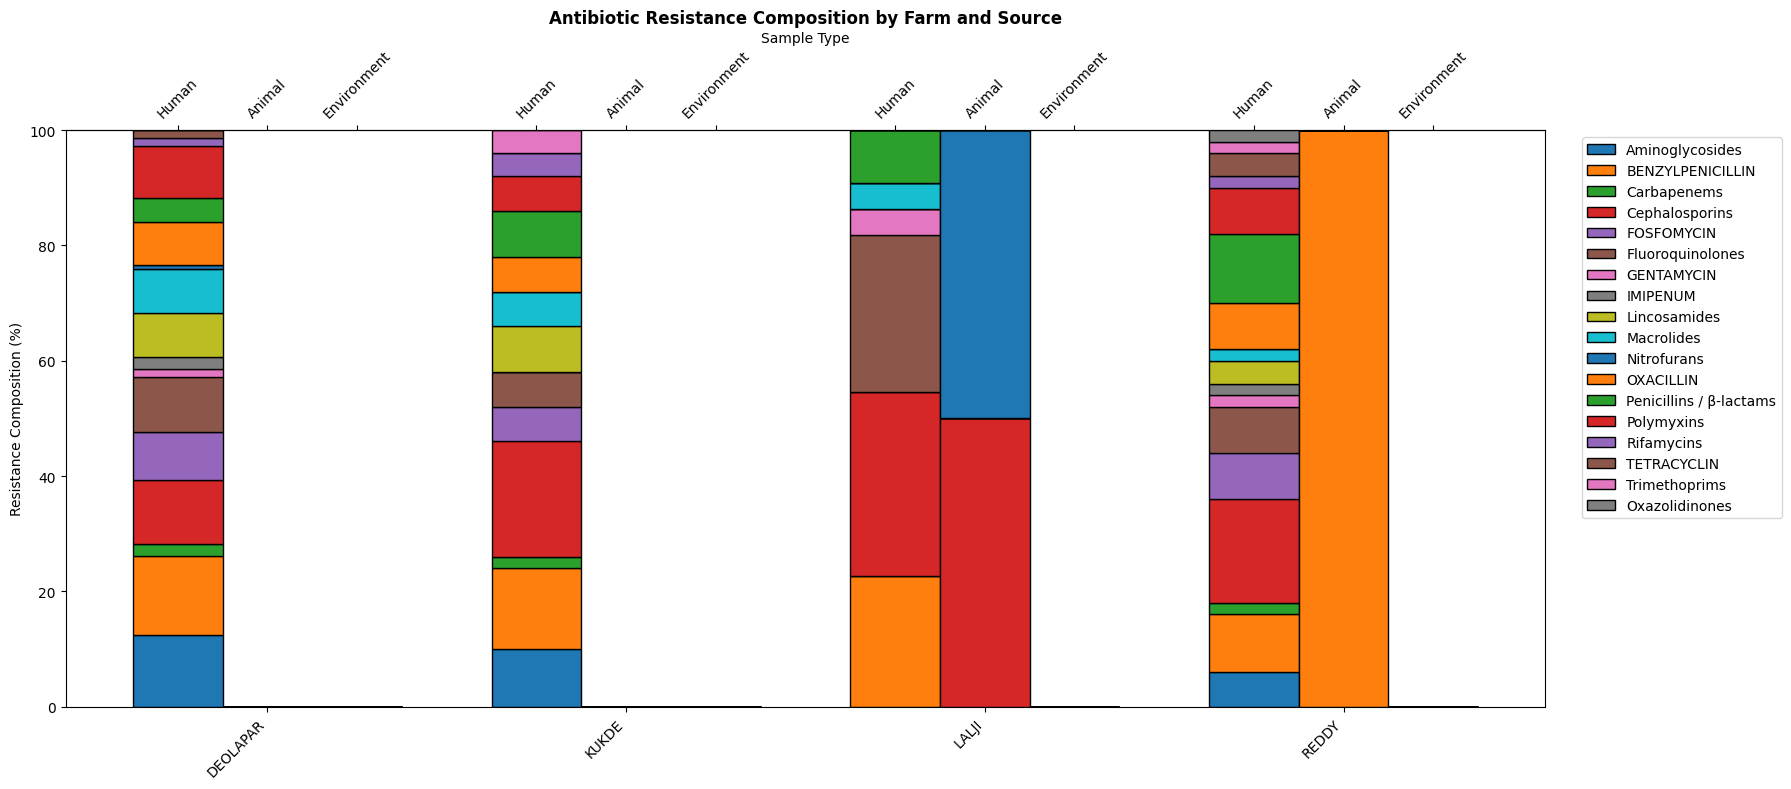

In [18]:
# ============================================================
# ONE HEALTH AMR PIPELINE – TEXT-BASED AST (FINAL SIMPLIFIED)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
import re
from functools import lru_cache

# ============================================================
# 1. LOAD DATA (TEXT-ONLY AST)
# ============================================================

def make_columns_unique(df):
    seen = {}
    new_cols = []
    for c in df.columns:
        if c not in seen:
            seen[c] = 0
            new_cols.append(c)
        else:
            seen[c] += 1
            new_cols.append(f"{c}__dup{seen[c]}")
    df.columns = new_cols
    return df


def load_and_fix_excel(file_bytes, source, start_idx=15, end_idx=50):
    df = pd.read_excel(io.BytesIO(file_bytes))

    # Fix antibiotic headers
    abx_row = df.iloc[0, start_idx:end_idx + 1]
    cols = list(df.columns)
    cols[start_idx:end_idx + 1] = abx_row.tolist()
    df.columns = cols

    df = df.drop(index=0).reset_index(drop=True)
    df = make_columns_unique(df)

    df["Source"] = source
    return df, start_idx, end_idx


def load_all_amr_data():
    datasets = {}
    for src in ["Human", "Animal", "Environment"]:
        print(f"\nUpload {src} AMR Excel file:")
        up = files.upload()
        fname = list(up.keys())[0]
        datasets[src] = load_and_fix_excel(up[fname], src)

    human, s, e = datasets["Human"]
    animal, _, _ = datasets["Animal"]
    env, _, _ = datasets["Environment"]

    return human, animal, env, s, e


# ============================================================
# 2. FARM NORMALIZATION
# ============================================================

def canon_farm(name):
    if pd.isna(name):
        return None
    name = str(name).upper()
    name = re.sub(r"[^A-Z0-9 ]", " ", name)
    name = re.sub(r"\s+", " ", name).strip()

    if name in {"", "NAN", "R2 1M", "RM2 1M"}:
        return None
    if "DEOLAPAR" in name:
        return "DEOLAPAR"
    if "KUKDE" in name:
        return "KUKDE"
    if "REDDY" in name:
        return "REDDY"
    if any(x in name for x in ["LALJI", "NVC", "MAFSU", "MELGHAT"]):
        return "LALJI"
    return name


def detect_location_column(df):
    if "Farm Name" in df.columns:
        return "Farm Name"
    if "Sample Code" in df.columns:
        return "Sample Code"
    raise ValueError("No location column found")


# ============================================================
# 3. ANTIBIOTIC → CLASS
# ============================================================

ABX_KEYWORD_TO_CLASS = {
    "AMIKACIN": "Aminoglycosides",
    "GENTAMICIN": "Aminoglycosides",
    "IMIPENEM": "Carbapenems",
    "MEROPENEM": "Carbapenems",
    "CEF": "Cephalosporins",
    "CIPRO": "Fluoroquinolones",
    "LEVO": "Fluoroquinolones",
    "ERYTHROMYCIN": "Macrolides",
    "CLINDAMYCIN": "Lincosamides",
    "LINEZOLID": "Oxazolidinones",
    "NITROFURANTOIN": "Nitrofurans",
    "COLISTIN": "Polymyxins",
    "RIFAMPICIN": "Rifamycins",
    "TRIMETHOPRIM": "Trimethoprims",

    # merged
    "AMOX": "Penicillins / β-lactams",
    "PIPERACILLIN": "Penicillins / β-lactams",
    "TAZOBACTAM": "Penicillins / β-lactams",
    "CEFOXITIN": "Penicillins / β-lactams",
}


@lru_cache(None)
def assign_class(ab):
    ab = str(ab).upper()
    for k, v in ABX_KEYWORD_TO_CLASS.items():
        if k in ab:
            return v
    return ab  # expand instead of "Other"


# ============================================================
# 4. CALCULATION (TEXT-BASED R)
# ============================================================

def calculate_resistance_composition(df, start_idx, end_idx):
    loc_col = detect_location_column(df)

    df = df.copy()
    df["Location"] = df[loc_col].apply(canon_farm)
    df = df[df["Location"].notna()]

    abx = df.iloc[:, start_idx:end_idx + 1]

    # ✅ FIX: apply string ops per column
    abx = abx.apply(lambda col: col.astype(str).str.upper().str.strip())

    base = pd.concat([df[["Location", "Source"]], abx], axis=1)

    long = base.melt(
        id_vars=["Location", "Source"],
        var_name="Antibiotic",
        value_name="AST"
    )

    long = long[long["AST"] == "R"]
    long["Antibiotic Class"] = long["Antibiotic"].apply(assign_class)

    counts = (
        long.groupby(["Location", "Source", "Antibiotic Class"])
        .size()
        .reset_index(name="Count")
    )

    totals = (
        counts.groupby(["Location", "Source"])["Count"]
        .sum()
        .reset_index(name="Total")
    )

    out = counts.merge(totals, on=["Location", "Source"])
    out["Percent"] = out["Count"] / out["Total"] * 100
    return out



# ============================================================
# 5. PLOTTING
# ============================================================

def plot_resistance_composition(df, title):
    farms = sorted(df["Location"].unique())
    sources = ["Human", "Animal", "Environment"]
    classes = df["Antibiotic Class"].unique()

    x = np.arange(len(farms))
    width = 0.25

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))
        for cls in classes:
            vals = [
                df.loc[
                    (df["Location"] == f) &
                    (df["Source"] == src) &
                    (df["Antibiotic Class"] == cls),
                    "Percent"
                ].sum()
                for f in farms
            ]

            ax.bar(
                x + i * width,
                vals,
                width,
                bottom=bottom,
                label=cls if i == 0 else "",
                edgecolor="black"
            )

            bottom += np.array(vals)

    ax.set_xticks(x + width)
    ax.set_xticklabels(farms, rotation=45, ha="right")
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_ylim(0, 100)
    ax.set_title(title, fontweight="bold")

    ax_top = ax.secondary_xaxis("top")
    ticks, labels = [], []
    for xi in x:
        for i, src in enumerate(sources):
            ticks.append(xi + i * width)
            labels.append(src)

    ax_top.set_xticks(ticks)
    ax_top.set_xticklabels(labels, rotation=45)
    ax_top.set_xlabel("Sample Type")

    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


# ============================================================
# 6. MAIN
# ============================================================

human, animal, env, s, e = load_all_amr_data()

all_data = pd.concat(
    [
        human.reset_index(drop=True),
        animal.reset_index(drop=True),
        env.reset_index(drop=True)
    ],
    ignore_index=True
)

composition = calculate_resistance_composition(all_data, s, e)

plot_resistance_composition(
    composition,
    "Antibiotic Resistance Composition by Farm and Source"
)



Upload Human AMR Excel file:


Saving Human Samples.xlsx to Human Samples (17).xlsx

Upload Animal AMR Excel file:


Saving Animal sample data_1.xlsx to Animal sample data_1 (3).xlsx

Upload Environment AMR Excel file:


Saving Enviormental Samples.xlsx to Enviormental Samples (16).xlsx

================ SANITY CHECK ================
Source
Animal      5
Human     258
dtype: int64


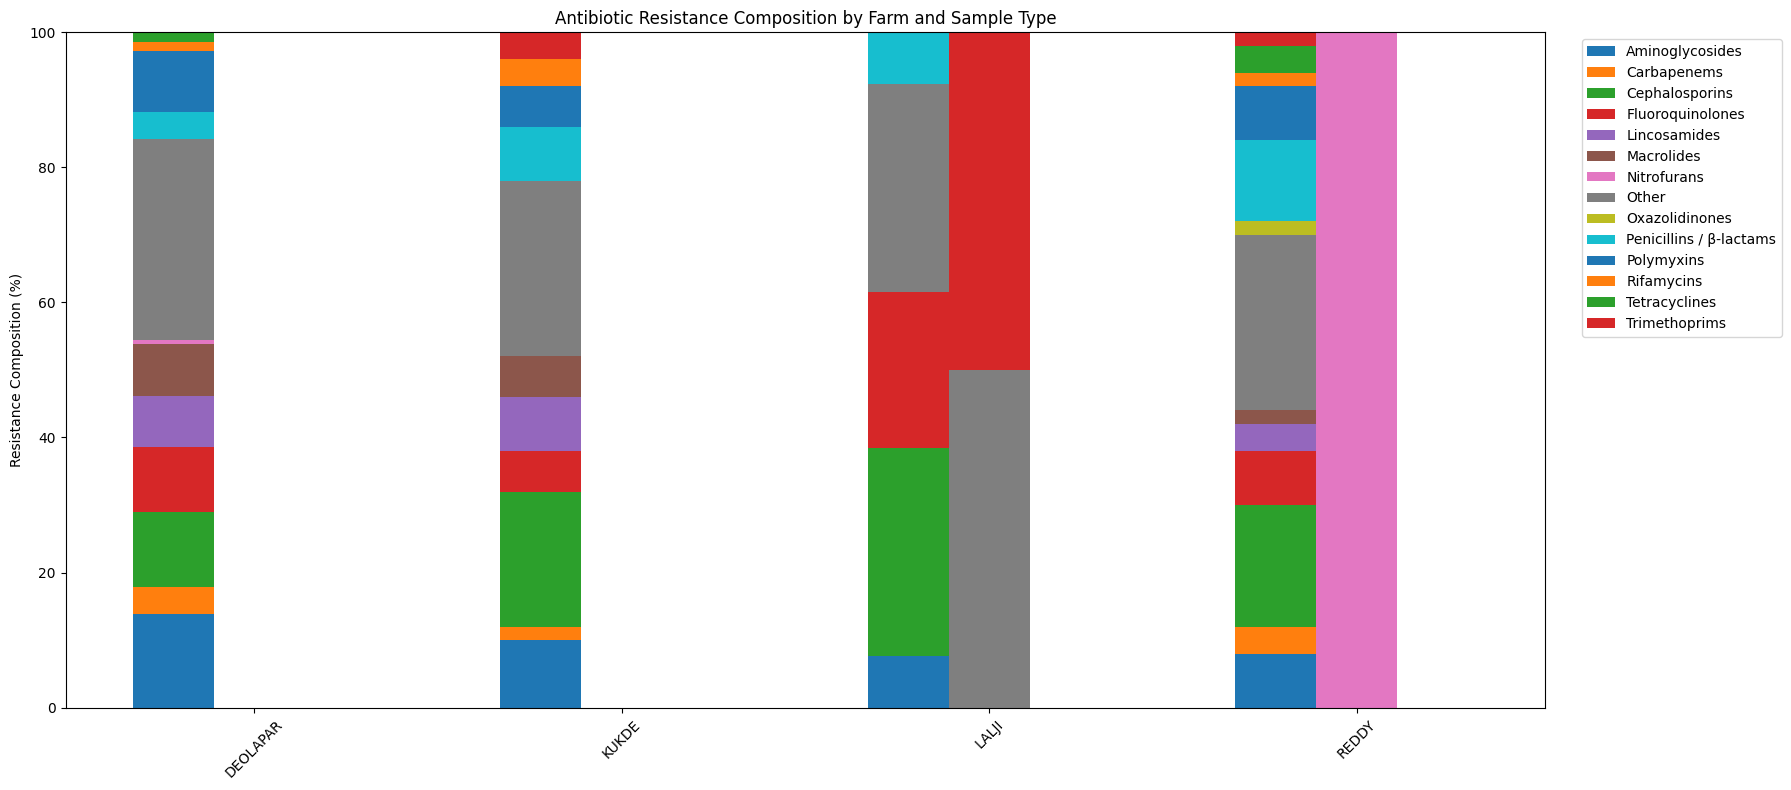

In [20]:
# ============================================================
# AMR PIPELINE — VALUE-BASED (R/S), SANITY-CHECKED, FINAL
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from google.colab import files
import io

# =============================
# 1. LOAD EXCEL
# =============================

def make_columns_unique(df):
    seen = {}
    new_cols = []
    for c in df.columns:
        if c not in seen:
            seen[c] = 0
            new_cols.append(c)
        else:
            seen[c] += 1
            new_cols.append(f"{c}__dup{seen[c]}")
    df.columns = new_cols
    return df

def load_excel(file_bytes, source, abx_start=15, abx_end=50):
    df = pd.read_excel(io.BytesIO(file_bytes))
    abx_names = df.iloc[0, abx_start:abx_end+1]
    df.columns = list(df.columns[:abx_start]) + abx_names.tolist() + list(df.columns[abx_end+1:])

    # Fix: Ensure all column names are unique after setting headers
    df = make_columns_unique(df)

    df = df.drop(index=0).reset_index(drop=True)
    df["Source"] = source
    return df, abx_start, abx_end


def load_all_amr_data():
    datasets = {}
    for src in ["Human", "Animal", "Environment"]:
        print(f"\nUpload {src} AMR Excel file:")
        up = files.upload()
        fname = list(up.keys())[0]
        datasets[src] = load_excel(up[fname], src)

    h, s, e = datasets["Human"]
    a, _, _ = datasets["Animal"]
    env, _, _ = datasets["Environment"]

    return h, a, env, s, e


# =============================
# 2. FARM NORMALIZATION
# =============================

def canon_farm(x):
    if pd.isna(x):
        return None
    x = re.sub(r"[^A-Z0-9 ]", " ", str(x).upper())
    if any(k in x for k in ["LALJI", "NVC", "MAFSU"]):
        return "LALJI"
    if "DEOLAPAR" in x:
        return "DEOLAPAR"
    if "KUKDE" in x:
        return "KUKDE"
    if "REDDY" in x:
        return "REDDY"
    return None


def detect_location_column(df):
    for c in ["Farm Name", "Location", "Sample Code"]:
        if c in df.columns:
            return c
    raise ValueError("No location column found")


# =============================
# 3. ANTIBIOTIC CLASS MAP
# =============================

ABX_CLASS = {
    "AMOX": "Penicillins / β-lactams",
    "PIPER": "Penicillins / β-lactams",
    "CEF": "Cephalosporins",
    "CARB": "Carbapenems",
    "IMIP": "Carbapenems",
    "MEROP": "Carbapenems",
    "CIPRO": "Fluoroquinolones",
    "LEVO": "Fluoroquinolones",
    "AMIK": "Aminoglycosides",
    "GENTA": "Aminoglycosides",
    "COLIS": "Polymyxins",
    "TETRA": "Tetracyclines",
    "LINEZ": "Oxazolidinones",
    "RIF": "Rifamycins",
    "TRIM": "Trimethoprims",
    "NITRO": "Nitrofurans",
    "CLINDA": "Lincosamides",
    "ERYTH": "Macrolides",
    "AZITH": "Macrolides",
}


def classify_abx(name):
    name = str(name).upper()
    for k, v in ABX_CLASS.items():
        if k in name:
            return v
    return "Other"


# =============================
# 4. CALCULATE RESISTANCE
# =============================

def calculate_resistance(df, start, end):
    loc_col = detect_location_column(df)
    df = df.copy()

    df["Location"] = df[loc_col].apply(canon_farm)
    df = df[df["Location"].notna()]

    abx = df.iloc[:, start:end+1].apply(lambda c: c.astype(str).str.upper())

    long = pd.concat(
        [df[["Sample Code", "Location", "Source"]], abx],
        axis=1
    ).melt(
        id_vars=["Sample Code", "Location", "Source"],
        var_name="Antibiotic",
        value_name="AST"
    )

    # STRICT FILTER
    long = long[long["AST"] == "R"]

    long["Antibiotic Class"] = long["Antibiotic"].apply(classify_abx)

    # SANITY CHECK
    print("\n================ SANITY CHECK ================")
    print(long.groupby("Source").size())
    print("==============================================")

    counts = (
        long.groupby(["Location", "Source", "Antibiotic Class"])
        .size()
        .reset_index(name="Count")
    )

    totals = (
        counts.groupby(["Location", "Source"])["Count"]
        .sum()
        .reset_index(name="Total")
    )

    out = counts.merge(totals, on=["Location", "Source"])
    out["Percent"] = out["Count"] / out["Total"] * 100

    return out


# =============================
# 5. PLOT
# =============================

def plot_resistance(df):
    farms = sorted(df["Location"].unique())
    sources = ["Human", "Animal", "Environment"]
    classes = sorted(df["Antibiotic Class"].unique())

    width = 0.22
    x = np.arange(len(farms))

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))
        for cls in classes:
            vals = [
                df.loc[
                    (df.Location == f) &
                    (df.Source == src) &
                    (df["Antibiotic Class"] == cls),
                    "Percent"
                ].sum()
                for f in farms
            ]

            ax.bar(x + i*width, vals, width, bottom=bottom, label=cls if i == 0 else "")
            bottom += np.array(vals)

    ax.set_xticks(x + width)
    ax.set_xticklabels(farms, rotation=45)
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_ylim(0, 100)
    ax.set_title("Antibiotic Resistance Composition by Farm and Sample Type")

    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


# =============================
# 6. RUN
# =============================

human, animal, env, s, e = load_all_amr_data()
all_data = pd.concat(
    [human.reset_index(drop=True),
     animal.reset_index(drop=True),
     env.reset_index(drop=True)],
    ignore_index=True
)

composition = calculate_resistance(all_data, s, e)
plot_resistance(composition)


Upload Human file:


Saving Human Samples.xlsx to Human Samples (20).xlsx

Upload Animal file:


Saving Animal sample data_1.xlsx to Animal sample data_1 (6).xlsx

Upload Environment file:


Saving Enviormental Samples.xlsx to Enviormental Samples (19).xlsx

================ SANITY CHECK ================
Source
Human          267
Environment     14
Animal           5
Name: Count, dtype: int64



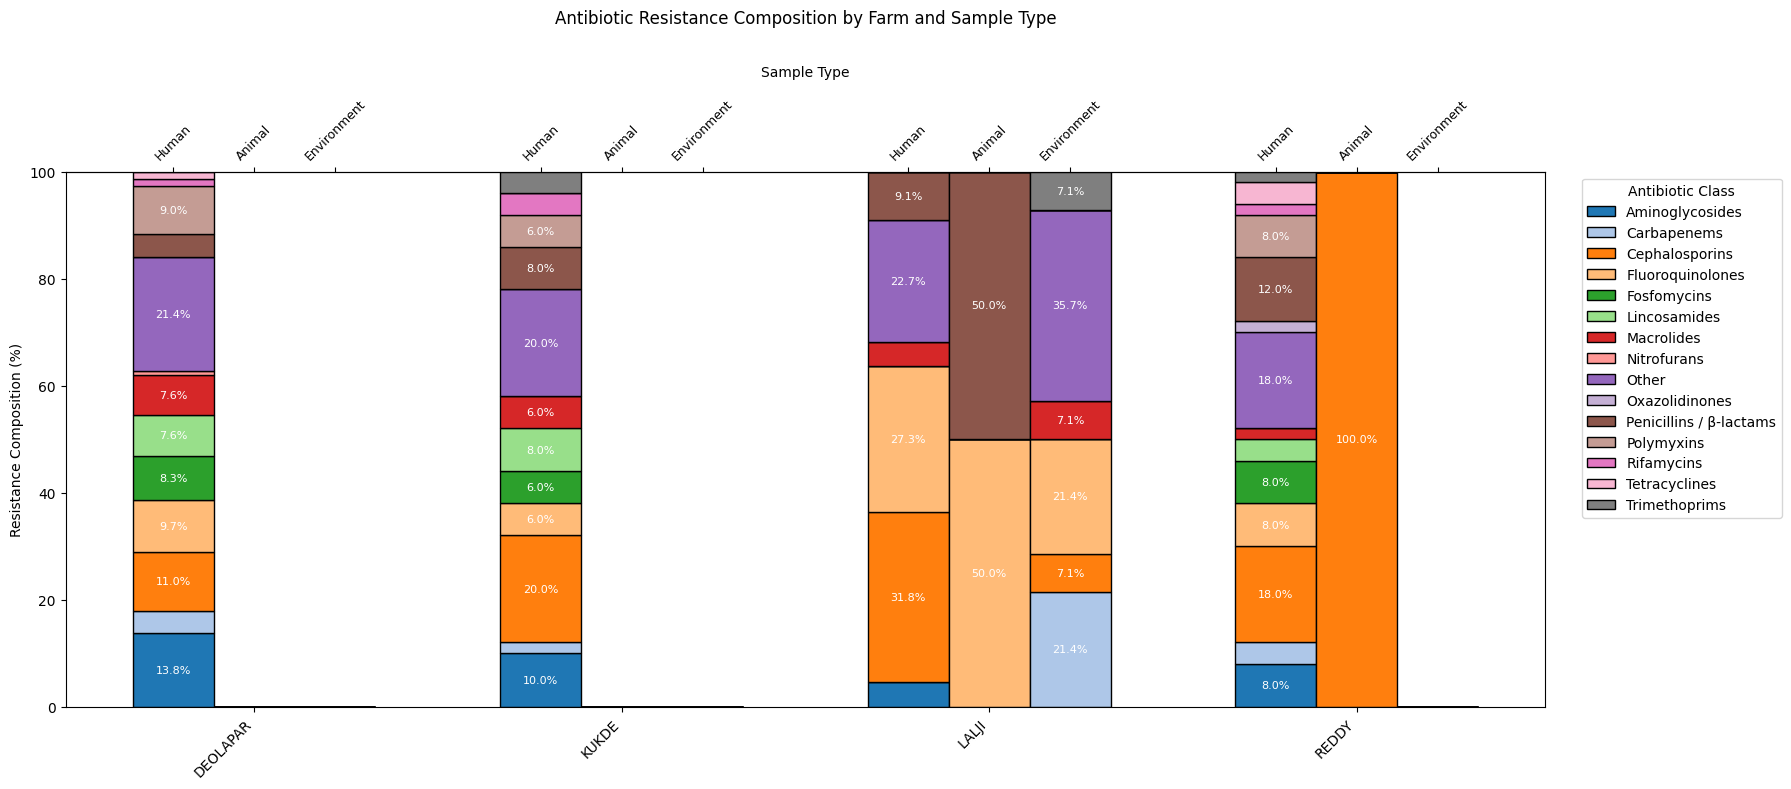

In [23]:
# ============================================================
# AMR PIPELINE — HUMAN + ANIMAL + ENVIRONMENT (PATCHED)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import re
from google.colab import files

# ============================================================
# 1. LOAD DATA
# ============================================================

def load_excel(file_bytes, source, abx_start=15, abx_end=50):
    df = pd.read_excel(io.BytesIO(file_bytes))

    # Fix antibiotic headers
    abx_names = df.iloc[0, abx_start:abx_end + 1]
    cols = list(df.columns)
    cols[abx_start:abx_end + 1] = abx_names
    df.columns = cols

    df = df.drop(index=0).reset_index(drop=True)
    df["Source"] = source
    return df, abx_start, abx_end


def load_all_sources():
    data = {}
    for src in ["Human", "Animal", "Environment"]:
        print(f"\nUpload {src} file:")
        up = files.upload()
        fname = list(up.keys())[0]
        data[src] = load_excel(up[fname], src)

    human, s, e = data["Human"]
    animal, _, _ = data["Animal"]
    env, _, _ = data["Environment"]

    return human, animal, env, s, e


# ============================================================
# 2. FARM NORMALIZATION (PATCHED)
# ============================================================

def normalize_farm(name):
    if pd.isna(name):
        return None
    name = re.sub(r"[^A-Z0-9 ]", " ", str(name).upper())
    name = re.sub(r"\s+", " ", name).strip()

    if name in {"", "NAN", "RM2 1M"}:
        return None
    if "LALJI" in name or "MAFSU" in name or "MELGHAT" in name:
        return "LALJI"
    if "DEOLAPAR" in name:
        return "DEOLAPAR"
    if "KUKDE" in name:
        return "KUKDE"
    if "REDDY" in name:
        return "REDDY"
    return name


def assign_location(df):
    df = df.copy()

    if "Farm Name" in df.columns:
        df["Location"] = df["Farm Name"]
    else:
        df["Location"] = df["Sample Code"]

    df["Location"] = df["Location"].apply(normalize_farm)

    # 🔴 PATCH: Environment samples → Lalji
    df.loc[df["Source"] == "Environment", "Location"] = "LALJI"

    return df[df["Location"].notna()].reset_index(drop=True)


# ============================================================
# 3. ANTIBIOTIC CLASS MAPPING
# ============================================================

ABX_CLASS = {
    "AMOX": "Penicillins / β-lactams",
    "PIPER": "Penicillins / β-lactams",
    "CEF": "Cephalosporins",
    "CARB": "Carbapenems",
    "IMIP": "Carbapenems",
    "MEROP": "Carbapenems",
    "CIPRO": "Fluoroquinolones",
    "LEVO": "Fluoroquinolones",
    "GENTA": "Aminoglycosides",
    "AMIKA": "Aminoglycosides",
    "ERYTH": "Macrolides",
    "AZITH": "Macrolides",
    "CLINDA": "Lincosamides",
    "LINEZ": "Oxazolidinones",
    "COLIST": "Polymyxins",
    "TETRA": "Tetracyclines",
    "NITRO": "Nitrofurans",
    "RIFAM": "Rifamycins",
    "TRIM": "Trimethoprims",
    "FOSFO": "Fosfomycins",
}


def classify_antibiotic(name):
    name = str(name).upper()
    for k, v in ABX_CLASS.items():
        if k in name:
            return v
    return "Other"


# ============================================================
# 4. RESISTANCE COMPOSITION
# ============================================================

def calculate_resistance_composition(df, start, end):
    abx = df.iloc[:, start:end + 1].astype(str).apply(lambda x: x.str.upper().str.strip())

    base = pd.concat(
        [df[["Sample Code", "Location", "Source"]], abx],
        axis=1
    )

    long = base.melt(
        id_vars=["Sample Code", "Location", "Source"],
        var_name="Antibiotic",
        value_name="AST"
    )

    long = long[long["AST"] == "R"]
    long["Class"] = long["Antibiotic"].apply(classify_antibiotic)

    counts = (
        long.groupby(["Location", "Source", "Class"])
        .size()
        .reset_index(name="Count")
    )

    totals = (
        counts.groupby(["Location", "Source"])["Count"]
        .sum()
        .reset_index(name="Total")
    )

    out = counts.merge(totals, on=["Location", "Source"])
    out["Percent"] = out["Count"] / out["Total"] * 100
    return out


# ============================================================
# 5. SANITY CHECK
# ============================================================

def sanity_check(df):
    print("\n================ SANITY CHECK ================")
    print(
        df.groupby("Source")["Count"]
        .sum()
        .sort_values(ascending=False)
    )
    print("==============================================\n")


# ============================================================
# 6. PLOTTING
# ============================================================

COLORS = plt.cm.tab20.colors

def plot_composition(df):
    farms = sorted(df["Location"].unique())
    sources = ["Human", "Animal", "Environment"]
    classes = sorted(df["Class"].unique())

    width = 0.22
    x = np.arange(len(farms))

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))
        for j, cls in enumerate(classes):
            vals = [
                df.loc[
                    (df["Location"] == f) &
                    (df["Source"] == src) &
                    (df["Class"] == cls),
                    "Percent"
                ].sum()
                for f in farms
            ]

            ax.bar(
                x + i * width,
                vals,
                width,
                bottom=bottom,
                color=COLORS[j % len(COLORS)],
                edgecolor="black",
                label=cls if i == 0 else None
            )

            for xi, yi, bi in zip(x + i * width, vals, bottom):
                if yi >= 5:
                    ax.text(
                        xi,
                        bi + yi / 2,
                        f"{yi:.1f}%",
                        ha="center",
                        va="center",
                        fontsize=8,
                        color="white"
                    )

            bottom += np.array(vals)

    ax.set_xticks(x + width)
    ax.set_xticklabels(farms, rotation=45, ha="right")
    ax.set_ylim(0, 100)
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_title("Antibiotic Resistance Composition by Farm and Sample Type", pad=30)

    # Top axis (sample type)
    ax_top = ax.secondary_xaxis("top")
    ticks, labels = [], []
    for xi in x:
        for i, s in enumerate(sources):
            ticks.append(xi + i * width)
            labels.append(s)

    ax_top.set_xticks(ticks)
    ax_top.set_xticklabels(labels, rotation=45, fontsize=9)
    ax_top.set_xlabel("Sample Type", labelpad=15)

    ax.legend(
        title="Antibiotic Class",
        bbox_to_anchor=(1.02, 1),
        loc="upper left"
    )

    plt.tight_layout()
    plt.show()


# ============================================================
# 7. RUN PIPELINE
# ============================================================

# ============================================================
# 7. RUN PIPELINE (PATCHED – SAFE CONCAT)
# ============================================================

def deduplicate_columns(df):
    """
    Ensures all column names are unique (required for pd.concat).
    Keeps first occurrence and drops duplicates.
    """
    df = df.loc[:, ~df.columns.duplicated()]
    return df



human, animal, env, s, e = load_all_sources()

human = deduplicate_columns(assign_location(human))
animal = deduplicate_columns(assign_location(animal))
env    = deduplicate_columns(assign_location(env))

all_data = pd.concat(
    [
        human.reset_index(drop=True),
        animal.reset_index(drop=True),
        env.reset_index(drop=True),
    ],
    ignore_index=True
)

composition = calculate_resistance_composition(all_data, s, e)

sanity_check(composition)

plot_composition(composition)



In [24]:
# ============================================================
# ANTIBIOTIC RESISTANCE COMPOSITION
# WITH SAMPLE COUNTS & ENV LOCATION FIX
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from google.colab import files
import io

# ============================================================
# 1. LOAD EXCEL (HEADER FIX)
# ============================================================

def load_and_fix_excel(file_bytes, source, start_idx=15, end_idx=50):
    df = pd.read_excel(io.BytesIO(file_bytes))
    df.columns = df.columns.astype(str)

    # Fix antibiotic header row
    abx_row = df.iloc[0, start_idx:end_idx + 1]
    cols = list(df.columns)
    cols[start_idx:end_idx + 1] = abx_row.tolist()
    df.columns = cols

    df = df.drop(index=0).reset_index(drop=True)
    df["Source"] = source
    return df, start_idx, end_idx


def load_all_amr_data():
    datasets = {}
    for src in ["Human", "Animal", "Environment"]:
        print(f"\nUpload {src} AMR file:")
        up = files.upload()
        fname = list(up.keys())[0]
        datasets[src] = load_and_fix_excel(up[fname], src)

    human, s, e = datasets["Human"]
    animal, _, _ = datasets["Animal"]
    env, _, _ = datasets["Environment"]

    return human, animal, env, s, e


# ============================================================
# 2. FARM NORMALIZATION
# ============================================================

def canon_farm(x):
    if pd.isna(x):
        return None
    x = str(x).upper()
    x = re.sub(r"[^A-Z0-9 ]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()

    if any(k in x for k in ["LALJI", "NVC", "MAFSU"]):
        return "LALJI"
    if "DEOLAPAR" in x:
        return "DEOLAPAR"
    if "KUKDE" in x:
        return "KUKDE"
    if "REDDY" in x:
        return "REDDY"
    return x


def detect_location_column(df):
    for c in ["Farm Name", "Location", "Sample Code"]:
        if c in df.columns:
            return c
    raise ValueError("No location column found")


def assign_env_location(df):
    df = df.copy()
    df["Location"] = "LALJI"
    return df


# ============================================================
# 3. ANTIBIOTIC → CLASS MAP
# ============================================================

ABX_CLASS = {
    "AMIKACIN": "Aminoglycosides",
    "GENTAMICIN": "Aminoglycosides",
    "IMIPENEM": "Carbapenems",
    "MEROPENEM": "Carbapenems",
    "CEF": "Cephalosporins",
    "CIPROFLOXACIN": "Fluoroquinolones",
    "LEVOFLOXACIN": "Fluoroquinolones",
    "ERYTHROMYCIN": "Macrolides",
    "AZITHROMYCIN": "Macrolides",
    "CLINDAMYCIN": "Lincosamides",
    "LINEZOLID": "Oxazolidinones",
    "COLISTIN": "Polymyxins",
    "TETRACYCLINE": "Tetracyclines",
    "RIFAMPICIN": "Rifamycins",
    "TRIMETHOPRIM": "Trimethoprims",
    "AMOX": "Penicillins / β-lactams",
    "PIPERACILLIN": "Penicillins / β-lactams",
    "OXACILLIN": "Penicillins / β-lactams",
    "CEFOXITIN": "Penicillins / β-lactams",
}


def assign_class(ab):
    ab = ab.upper()
    for k, v in ABX_CLASS.items():
        if k in ab:
            return v
    return "Other"


# ============================================================
# 4. RESISTANCE COMPOSITION + SAMPLE COUNTS
# ============================================================

def calculate_resistance_composition(df, start_idx, end_idx):

    loc_col = detect_location_column(df)
    df[loc_col] = df[loc_col].apply(canon_farm)
    df = df[df[loc_col].notna()].copy()

    abx = df.iloc[:, start_idx:end_idx + 1]
    abx = abx.apply(lambda c: c.astype(str).str.strip().str.upper())

    base = pd.concat(
        [df[[loc_col, "Source", "Sample Code"]].reset_index(drop=True),
         abx.reset_index(drop=True)],
        axis=1
    )

    long = base.melt(
        id_vars=[loc_col, "Source", "Sample Code"],
        var_name="Antibiotic",
        value_name="AST"
    )

    long = long[long["AST"] == "R"].copy()
    long["Class"] = long["Antibiotic"].apply(assign_class)
    long.rename(columns={loc_col: "Location"}, inplace=True)

    # ---------- resistance counts ----------
    counts = (
        long.groupby(["Location", "Source", "Class"])
        .size()
        .reset_index(name="n")
    )

    totals = (
        counts.groupby(["Location", "Source"])["n"]
        .sum()
        .reset_index(name="total")
    )

    comp = counts.merge(totals, on=["Location", "Source"])
    comp["percent"] = comp["n"] / comp["total"] * 100

    # ---------- sample counts ----------
    sample_counts = (
        long.groupby(["Location", "Source"])["Sample Code"]
        .nunique()
        .reset_index(name="samples")
    )

    return comp, sample_counts


# ============================================================
# 5. PLOT
# ============================================================

def plot_composition(comp, sample_counts):

    farms = sorted(comp["Location"].unique())
    sources = ["Human", "Animal", "Environment"]
    classes = sorted(comp["Class"].unique())

    bar_w = 0.22
    x = np.arange(len(farms))

    fig, ax = plt.subplots(figsize=(18, 9))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))

        for cls in classes:
            vals = [
                comp.loc[
                    (comp.Location == f) &
                    (comp.Source == src) &
                    (comp.Class == cls),
                    "percent"
                ].sum()
                for f in farms
            ]

            ax.bar(x + i * bar_w, vals, bar_w,
                   bottom=bottom, label=cls if i == 0 else "")

            # percent labels
            for xi, yi, bi in zip(x + i * bar_w, vals, bottom):
                if yi >= 5:
                    ax.text(xi, bi + yi / 2, f"{yi:.1f}%",
                            ha="center", va="center", fontsize=8)

            bottom += np.array(vals)

        # ---------- sample count labels ----------
        for j, farm in enumerate(farms):
            n = sample_counts.loc[
                (sample_counts.Location == farm) &
                (sample_counts.Source == src),
                "samples"
            ]
            if not n.empty:
                ax.text(
                    x[j] + i * bar_w, 103,
                    f"n={int(n.iloc[0])}",
                    ha="center", va="bottom", fontsize=8
                )

    ax.set_xticks(x + bar_w)
    ax.set_xticklabels(farms, rotation=45)
    ax.set_ylim(0, 110)
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_title("Antibiotic Resistance Composition by Farm and Sample Type",
                 fontweight="bold")

    # top axis (sample type)
    ax_top = ax.secondary_xaxis("top")
    ticks, labels = [], []
    for xi in x:
        for s in sources:
            ticks.append(xi + sources.index(s) * bar_w)
            labels.append(s)
    ax_top.set_xticks(ticks)
    ax_top.set_xticklabels(labels, rotation=45)

    ax.legend(bbox_to_anchor=(1.02, 1), title="Antibiotic Class")
    plt.tight_layout()
    plt.show()


# ============================================================
# 6. RUN
# ============================================================

human, animal, env, s, e = load_all_amr_data()

env = assign_env_location(env)

all_data = pd.concat(
    [human.reset_index(drop=True),
     animal.reset_index(drop=True),
     env.reset_index(drop=True)],
    ignore_index=True
)

composition, sample_counts = calculate_resistance_composition(all_data, s, e)

plot_composition(composition, sample_counts)



Upload Human AMR file:


Saving Human Samples.xlsx to Human Samples (21).xlsx

Upload Animal AMR file:


Saving Animal sample data_1.xlsx to Animal sample data_1 (7).xlsx

Upload Environment AMR file:


Saving Enviormental Samples.xlsx to Enviormental Samples (20).xlsx


InvalidIndexError: Reindexing only valid with uniquely valued Index objects


Upload Human AMR file


Saving Human Samples.xlsx to Human Samples (22).xlsx

Upload Animal AMR file


Saving Animal sample data_1.xlsx to Animal sample data_1 (8).xlsx

Upload Environment AMR file


Saving Enviormental Samples.xlsx to Enviormental Samples (21).xlsx


/tmp/ipython-input-430408943.py:154: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  abx = df.iloc[:, start_idx:end_idx + 1].applymap(normalize_ast)


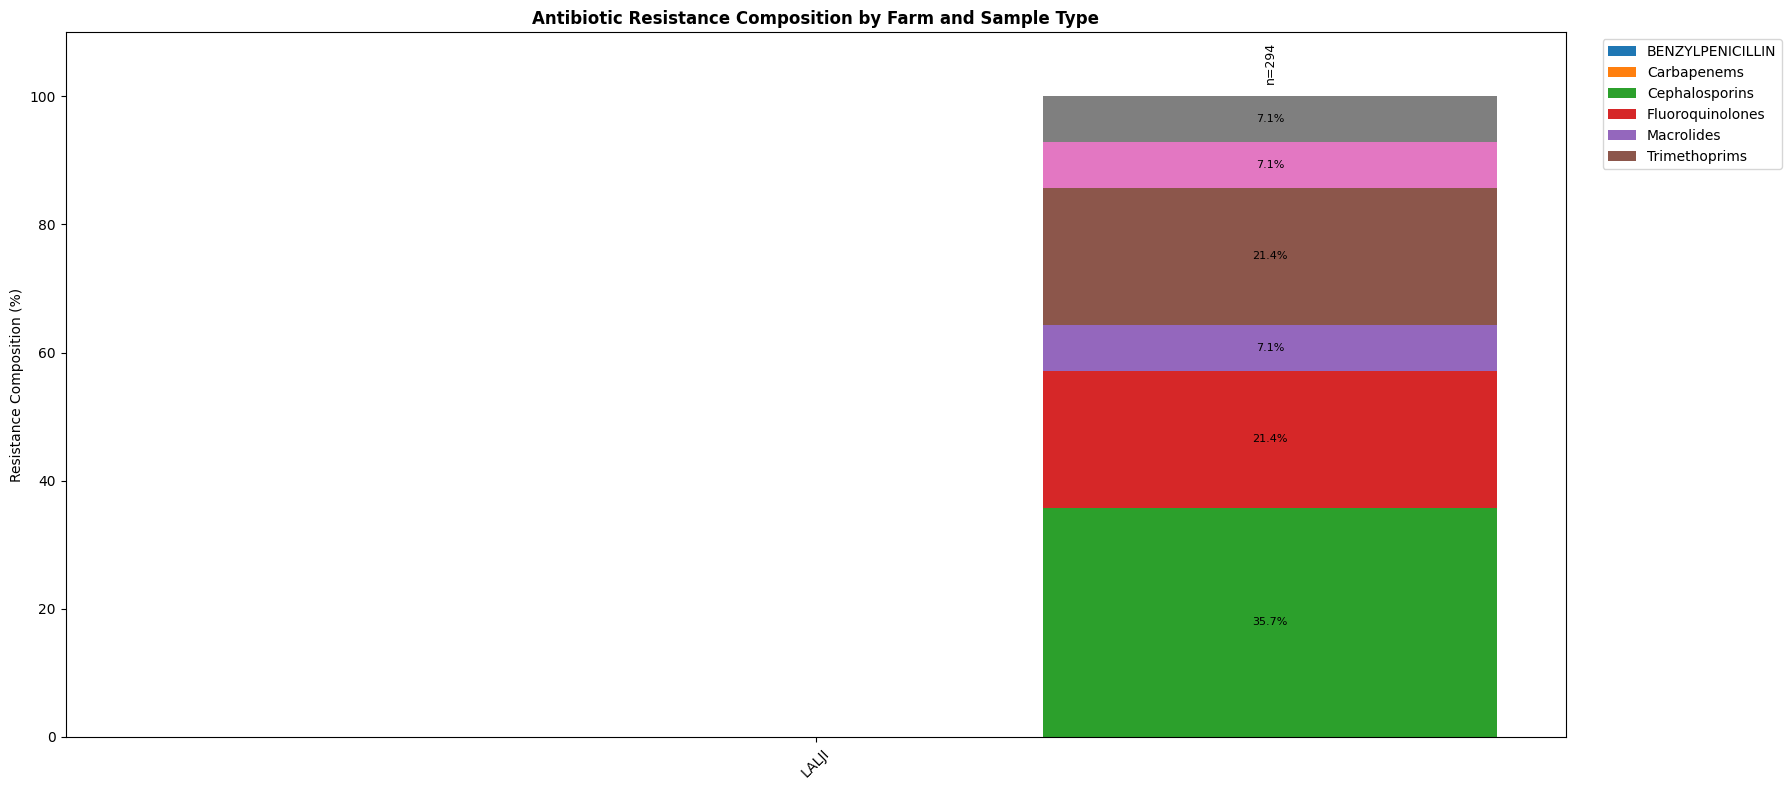

In [25]:
# ============================================================
# ONE HEALTH AMR PIPELINE – FINAL STABLE VERSION
# Human | Animal | Environment
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import io
from google.colab import files

# ============================================================
# 1. SAFETY: MAKE COLUMNS UNIQUE
# ============================================================

def make_columns_unique(df):
    counts = {}
    new_cols = []
    for c in df.columns:
        if c not in counts:
            counts[c] = 0
            new_cols.append(c)
        else:
            counts[c] += 1
            new_cols.append(f"{c}__dup{counts[c]}")
    df = df.copy()
    df.columns = new_cols
    return df

# ============================================================
# 2. LOAD & FIX EXCEL
# ============================================================

def load_and_fix_excel(file_bytes, source, start_idx=15, end_idx=50):
    df = pd.read_excel(io.BytesIO(file_bytes))

    # Fix antibiotic headers
    abx_row = df.iloc[0, start_idx:end_idx + 1]
    cols = list(df.columns)
    cols[start_idx:end_idx + 1] = abx_row.tolist()
    df.columns = cols

    df = df.drop(index=0).reset_index(drop=True)
    df["Source"] = source

    df = make_columns_unique(df)
    return df, start_idx, end_idx

def load_all_amr_data():
    datasets = {}

    for src in ["Human", "Animal", "Environment"]:
        print(f"\nUpload {src} AMR file")
        up = files.upload()
        fname = list(up.keys())[0]
        datasets[src] = load_and_fix_excel(up[fname], src)

    human, s, e = datasets["Human"]
    animal, _, _ = datasets["Animal"]
    env, _, _ = datasets["Environment"]

    return human, animal, env, s, e

# ============================================================
# 3. FARM NORMALIZATION
# ============================================================

def canon(name):
    if pd.isna(name):
        return None
    name = str(name).upper()
    name = re.sub(r"[^A-Z0-9 ]", " ", name)
    name = re.sub(r"\s+", " ", name).strip()

    if name in {"", "NAN", "RM2 1M", "R2 1M"}:
        return None
    if any(x in name for x in ["LALJI", "NVC", "MAFSU", "MELGHAT"]):
        return "LALJI"
    if "DEOLAPAR" in name:
        return "DEOLAPAR"
    if "KUKDE" in name:
        return "KUKDE"
    if "REDDY" in name:
        return "REDDY"
    return name

def normalize_farms(df, loc_col):
    df = df.copy()
    df[loc_col] = df[loc_col].apply(canon)
    return df[df[loc_col].notna()].reset_index(drop=True)

def assign_env_location(df):
    df = df.copy()
    df["Location"] = "LALJI"
    return df

# ============================================================
# 4. RESISTANCE PARSING (MANUAL R / S)
# ============================================================

def normalize_ast(val):
    if pd.isna(val):
        return np.nan
    val = str(val).strip().upper()
    if val in {"R", "RESISTANT"}:
        return "R"
    if val in {"S", "SUSCEPTIBLE"}:
        return "S"
    return np.nan

# ============================================================
# 5. ANTIBIOTIC → CLASS MAP
# ============================================================

ABX_TO_CLASS = {
    "AMOX": "Penicillins / β-lactams",
    "PIPER": "Penicillins / β-lactams",
    "CEF": "Cephalosporins",
    "CARBA": "Carbapenems",
    "IMIP": "Carbapenems",
    "MEROP": "Carbapenems",
    "CIPRO": "Fluoroquinolones",
    "LEVO": "Fluoroquinolones",
    "GENTA": "Aminoglycosides",
    "AMIKA": "Aminoglycosides",
    "COLIST": "Polymyxins",
    "VANCO": "Glycopeptides",
    "LINEZ": "Oxazolidinones",
    "CLINDA": "Lincosamides",
    "ERYTH": "Macrolides",
    "AZITH": "Macrolides",
    "NITRO": "Nitrofurans",
    "RIFAMP": "Rifamycins",
    "TETRA": "Tetracyclines",
    "TRIMETH": "Trimethoprims",
    "FOSFO": "Fosfomycins",
}

def assign_class(ab):
    ab = str(ab).upper()
    for k, v in ABX_TO_CLASS.items():
        if k in ab:
            return v
    return ab   # keep drug name if unmatched

# ============================================================
# 6. CALCULATE RESISTANCE COMPOSITION
# ============================================================

def calculate_resistance_composition(df, start_idx, end_idx):
    loc_col = "Location" if "Location" in df.columns else "Farm Name"

    abx = df.iloc[:, start_idx:end_idx + 1].applymap(normalize_ast)
    base = pd.concat([df[[loc_col, "Source"]], abx], axis=1)

    long = base.melt(
        id_vars=[loc_col, "Source"],
        var_name="Antibiotic",
        value_name="AST"
    )

    long = long[long["AST"] == "R"]
    long["Antibiotic Class"] = long["Antibiotic"].apply(assign_class)

    long = normalize_farms(long, loc_col).rename(columns={loc_col: "Location"})

    counts = (
        long.groupby(["Location", "Source", "Antibiotic Class"])
        .size()
        .reset_index(name="Resistant Count")
    )

    totals = (
        counts.groupby(["Location", "Source"])["Resistant Count"]
        .sum()
        .reset_index(name="Total")
    )

    comp = counts.merge(totals, on=["Location", "Source"])
    comp["Percent"] = comp["Resistant Count"] / comp["Total"] * 100
    return comp

# ============================================================
# 7. SAMPLE COUNT TABLE
# ============================================================

def sample_counts(df):
    return (
        df.groupby(["Location", "Source"])
        .size()
        .reset_index(name="n")
    )

# ============================================================
# 8. PLOTTING
# ============================================================

def plot_resistance_composition(comp, counts):
    farms = sorted(comp["Location"].unique())
    sources = ["Human", "Animal", "Environment"]
    classes = comp["Antibiotic Class"].unique()

    bar_w = 0.22
    x = np.arange(len(farms))

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))
        for cls in classes:
            vals = [
                comp.loc[
                    (comp.Location == f) &
                    (comp.Source == src) &
                    (comp["Antibiotic Class"] == cls),
                    "Percent"
                ].sum()
                for f in farms
            ]

            ax.bar(x + i * bar_w, vals, bar_w,
                   bottom=bottom, label=cls if i == 0 else "")

            for xi, yi, bi in zip(x + i * bar_w, vals, bottom):
                if yi >= 5:
                    ax.text(xi, bi + yi / 2, f"{yi:.1f}%",
                            ha="center", va="center", fontsize=8)

            bottom += np.array(vals)

        # Sample count on top
        for j, farm in enumerate(farms):
            n = counts.loc[
                (counts.Location == farm) & (counts.Source == src), "n"
            ]
            if not n.empty:
                ax.text(
                    x[j] + i * bar_w, 102,
                    f"n={int(n.values[0])}",
                    ha="center", va="bottom", fontsize=9, rotation=90
                )

    ax.set_xticks(x + bar_w)
    ax.set_xticklabels(farms, rotation=45)
    ax.set_ylim(0, 110)
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_title("Antibiotic Resistance Composition by Farm and Sample Type",
                 fontweight="bold")

    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# ============================================================
# 9. MAIN
# ============================================================

human, animal, env, s, e = load_all_amr_data()

env = assign_env_location(env)

all_data = pd.concat(
    [
        human.reset_index(drop=True),
        animal.reset_index(drop=True),
        env.reset_index(drop=True)
    ],
    ignore_index=True
)

composition = calculate_resistance_composition(all_data, s, e)
counts = sample_counts(all_data)

plot_resistance_composition(composition, counts)


In [2]:
# ============================================================
# COMPLETE AMR RESISTANCE COMPOSITION PIPELINE (FINAL)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
import re

# ============================================================
# 0. SAFETY: MAKE COLUMNS UNIQUE (FIXED)
# ============================================================

def make_columns_unique(df):
    counts = {}
    new_cols = []
    for c in df.columns:
        if c not in counts:
            counts[c] = 0
            new_cols.append(c)
        else:
            counts[c] += 1
            new_cols.append(f"{c}__dup{counts[c]}")
    df = df.copy()
    df.columns = new_cols
    return df


# ============================================================
# 1. LOAD DATA
# ============================================================

def load_excel_with_header_fix(file_bytes, source, abx_start=15, abx_end=50):
    df = pd.read_excel(io.BytesIO(file_bytes))
    abx_names = df.iloc[0, abx_start:abx_end + 1].astype(str)
    df = df.drop(index=0).reset_index(drop=True)

    cols = list(df.columns)
    cols[abx_start:abx_end + 1] = abx_names
    df.columns = cols

    df["Source"] = source
    df = make_columns_unique(df)  # ✅ enforce uniqueness here
    return df, abx_start, abx_end


def upload_all_sources():
    data = {}
    for src in ["Human", "Animal", "Environment"]:
        print(f"\nUpload {src} data:")
        up = files.upload()
        fname = list(up.keys())[0]
        data[src] = load_excel_with_header_fix(up[fname], src)

    human, s, e = data["Human"]
    animal, _, _ = data["Animal"]
    env, _, _ = data["Environment"]
    return human, animal, env, s, e


# ============================================================
# 2. LOCATION NORMALIZATION
# ============================================================

def canon_location(x):
    if pd.isna(x):
        return None
    x = str(x).upper()
    if "LALJI" in x or "MAFSU" in x or "NVC" in x or "MELGHAT" in x:
        return "LALJI"
    if "DEOLAPAR" in x:
        return "DEOLAPAR"
    if "KUKDE" in x:
        return "KUKDE"
    if "REDDY" in x:
        return "REDDY"
    return None


def assign_location(df):
    df = df.copy()
    if "Farm Name" in df.columns:
        df["Location"] = df["Farm Name"].apply(canon_location)
    elif "Sample Code" in df.columns:
        df["Location"] = df["Sample Code"].apply(canon_location)
    else:
        df["Location"] = None
    return df


def assign_env_location(df):
    df = df.copy()
    df["Location"] = "LALJI"   # ✅ explicit fix
    return df


# ============================================================
# 3. RESISTANCE EXTRACTION (R ONLY)
# ============================================================

def extract_resistance_long(df, abx_start, abx_end):
    abx = df.iloc[:, abx_start:abx_end + 1]
    abx = abx.map(lambda x: str(x).strip().upper()) # Replaced applymap with map

    long = pd.concat(
        [df[["Source", "Location", "Sample Code"]], abx],
        axis=1
    ).melt(
        id_vars=["Source", "Location", "Sample Code"],
        var_name="Antibiotic",
        value_name="AST"
    )

    long = long[long["AST"] == "R"]  # ❤ resistance only
    return long


# ============================================================
# 4. ANTIBIOTIC → CLASS
# ============================================================

CLASS_MAP = {
    "AMIKACIN": "Aminoglycosides",
    "GENTAMICIN": "Aminoglycosides",
    "IMIPENEM": "Carbapenems",
    "MEROPENEM": "Carbapenems",
    "CEF": "Cephalosporins",
    "CIPRO": "Fluoroquinolones",
    "LEVO": "Fluoroquinolones",
    "ERYTHRO": "Macrolides",
    "CLINDA": "Lincosamides",
    "LINEZOLID": "Oxazolidinones",
    "TETRA": "Tetracyclines",
    "COLISTIN": "Polymyxins",
    "RIFAMP": "Rifamycins",
    "TRIMETH": "Trimethoprims",
    "AMOX": "Penicillins / β-lactams",
    "PIPER": "Penicillins / β-lactams",
    "OXACILLIN": "Penicillins / β-lactams",
}


def assign_class(ab):
    ab = ab.upper()
    for k, v in CLASS_MAP.items():
        if k in ab:
            return v
    return "Other"


# ============================================================
# 5. CALCULATION
# ============================================================

def calculate_composition(df, abx_start, abx_end):
    df["Location"] = df["Location"].astype(str)
    long = extract_resistance_long(df, abx_start, abx_end)
    long["Class"] = long["Antibiotic"].apply(assign_class)

    counts = (
        long.groupby(["Location", "Source", "Class"])
        .size()
        .reset_index(name="n")
    )

    totals = (
        counts.groupby(["Location", "Source"])["n"]
        .sum()
        .reset_index(name="total")
    )

    comp = counts.merge(totals, on=["Location", "Source"])
    comp["percent"] = comp["n"] / comp["total"] * 100
    return comp, long


# ============================================================
# 6. PLOTTING (WITH SAMPLE COUNTS)
# ============================================================

def plot_composition(comp, long):
    farms = sorted(comp["Location"].unique())
    sources = ["Human", "Animal", "Environment"]
    classes = sorted(comp["Class"].unique())

    x = np.arange(len(farms))
    width = 0.25

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))

        for cls in classes:
            vals = [
                comp.loc[
                    (comp["Location"] == f) &
                    (comp["Source"] == src) &
                    (comp["Class"] == cls),
                    "percent"
                ].sum()
                for f in farms
            ]

            ax.bar(
                x + i * width,
                vals,
                width,
                bottom=bottom,
                label=cls if i == 0 else None,
                edgecolor="black"
            )

            for xi, yi, bi in zip(x + i * width, vals, bottom):
                if yi >= 5:
                    ax.text(
                        xi,
                        bi + yi / 2,
                        f"{yi:.1f}%",
                        ha="center",
                        va="center",
                        fontsize=8,
                        color="white"
                    )

            bottom += np.array(vals)

        # Sample count annotation
        for j, f in enumerate(farms):
            n_samples = long.loc[
                (long["Location"] == f) &
                (long["Source"] == src),
                "Sample Code"
            ].nunique()

            ax.text(
                x[j] + i * width,
                103,
                f"n={n_samples}",
                ha="center",
                va="bottom",
                fontsize=9,
                rotation=90
            )

    ax.set_xticks(x + width)
    ax.set_xticklabels(farms, rotation=45)
    ax.set_ylim(0, 110)
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_title("Antibiotic Resistance Composition by Farm and Sample Type")

    ax.legend(
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        title="Antibiotic Class"
    )

    plt.tight_layout()
    plt.show()


# ============================================================
# 7. RUN PIPELINE
# ============================================================

human, animal, env, s, e = upload_all_sources()

human = assign_location(human)
animal = assign_location(animal)
env = assign_env_location(env)

all_data = pd.concat(
    [
        human.reset_index(drop=True),
        animal.reset_index(drop=True),
        env.reset_index(drop=True)
    ],
    ignore_index=True
)

composition, long_resistance = calculate_composition(all_data, s, e)

print("\n================ SANITY CHECK ================")
print(long_resistance.groupby("Source")["Sample Code"].nunique())
print("=============================================")

plot_composition(composition, long_resistance)


Upload Human data:


KeyboardInterrupt: 

In [3]:
# ============================================================
# FINAL ONE HEALTH AMR RESISTANCE COMPOSITION PIPELINE
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import io
from google.colab import files

# ============================================================
# 1. LOAD EXCEL WITH HEADER FIX
# ============================================================

def load_and_fix_excel(file_bytes, source, abx_start=15, abx_end=50):
    df = pd.read_excel(io.BytesIO(file_bytes))

    # Fix antibiotic header row
    abx_names = df.iloc[0, abx_start:abx_end + 1].astype(str)
    df = df.drop(index=0).reset_index(drop=True)

    cols = list(df.columns)
    cols[abx_start:abx_end + 1] = abx_names
    df.columns = pd.Index(cols).astype(str)

    df["Source"] = source
    return df, abx_start, abx_end


def upload_all_sources():
    data = {}
    for src in ["Human", "Animal", "Environment"]:
        print(f"\nUpload {src} AMR file:")
        up = files.upload()
        fname = list(up.keys())[0]
        data[src] = load_and_fix_excel(up[fname], src)

    human, s, e = data["Human"]
    animal, _, _ = data["Animal"]
    env, _, _ = data["Environment"]

    return human, animal, env, s, e

# ============================================================
# 2. FARM NORMALIZATION
# ============================================================

def canon_farm(x):
    if pd.isna(x):
        return None
    x = str(x).upper()
    x = re.sub(r"[^A-Z0-9 ]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()

    if any(k in x for k in ["LALJI", "NVC", "MAFSU", "MELGHAT"]):
        return "LALJI"
    if "DEOLAPAR" in x:
        return "DEOLAPAR"
    if "KUKDE" in x:
        return "KUKDE"
    if "REDDY" in x:
        return "REDDY"
    return None


def assign_location(df):
    df = df.copy()
    if "Farm Name" in df.columns:
        df["Location"] = df["Farm Name"].apply(canon_farm)
    else:
        df["Location"] = None
    return df


def assign_env_location(df):
    df = df.copy()
    df["Location"] = "LALJI"
    return df

# ============================================================
# 3. RESISTANCE LOGIC (SOURCE-AWARE)
# ============================================================

def parse_resistant_count(val):
    if pd.isna(val):
        return 0
    digits = "".join(c for c in str(val) if c.isdigit())
    return int(digits) if digits else 0

# ============================================================
# 4. ANTIBIOTIC → CLASS
# ============================================================

CLASS_MAP = {
    "AMOX": "Penicillins / β-lactams",
    "PIPER": "Penicillins / β-lactams",
    "OXACILLIN": "Penicillins / β-lactams",
    "CEF": "Cephalosporins",
    "IMIP": "Carbapenems",
    "MEROP": "Carbapenems",
    "CIPRO": "Fluoroquinolones",
    "LEVO": "Fluoroquinolones",
    "AMIKA": "Aminoglycosides",
    "GENTA": "Aminoglycosides",
    "COLIST": "Polymyxins",
    "LINEZ": "Oxazolidinones",
    "CLINDA": "Lincosamides",
    "ERYTH": "Macrolides",
    "TETRA": "Tetracyclines",
    "RIFAMP": "Rifamycins",
    "TRIMETH": "Trimethoprims",
}

def assign_class(ab):
    ab = str(ab).upper()
    for k, v in CLASS_MAP.items():
        if k in ab:
            return v
    return "Other"

# ============================================================
# 5. BUILD RESISTANT DATASET
# ============================================================

def extract_resistance(human, animal, env, s, e):

    # ---- HUMAN & ENVIRONMENT (AST cell == R) ----
    def ast_long(df):
        abx = df.iloc[:, s:e + 1].astype(str).apply(lambda x: x.str.strip().str.upper())
        long = pd.concat(
            [df[["Source", "Location", "Sample Code"]], abx],
            axis=1
        ).melt(
            id_vars=["Source", "Location", "Sample Code"],
            var_name="Antibiotic",
            value_name="AST"
        )
        return long[long["AST"] == "R"]

    human_long = ast_long(human)
    env_long = ast_long(env)

    # ---- ANIMAL (RESISTANT [AST Profiling]) ----
    animal = animal.copy()
    animal["Resistant_Count"] = animal["RESISTANT [AST Profiling]"].apply(parse_resistant_count)
    animal_res = animal[animal["Resistant_Count"] > 0]

    # expand animal rows so they integrate cleanly
    animal_long = animal_res.assign(
        Antibiotic="Any",
        AST="R"
    )[["Source", "Location", "Sample Code", "Antibiotic", "AST"]]

    all_long = pd.concat([human_long, animal_long, env_long], ignore_index=True)
    all_long["Class"] = all_long["Antibiotic"].apply(assign_class)

    return all_long

# ============================================================
# 6. CALCULATE COMPOSITION
# ============================================================

def calculate_composition(long):
    counts = (
        long.groupby(["Location", "Source", "Class"])
        .size()
        .reset_index(name="n")
    )

    totals = (
        counts.groupby(["Location", "Source"])["n"]
        .sum()
        .reset_index(name="total")
    )

    comp = counts.merge(totals, on=["Location", "Source"])
    comp["percent"] = comp["n"] / comp["total"] * 100
    return comp

# ============================================================
# 7. PLOT
# ============================================================

def plot_composition(comp, long):
    farms = sorted(comp["Location"].unique())
    sources = ["Human", "Animal", "Environment"]
    classes = sorted(comp["Class"].unique())

    x = np.arange(len(farms))
    width = 0.25

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))

        for cls in classes:
            vals = [
                comp.loc[
                    (comp.Location == f) &
                    (comp.Source == src) &
                    (comp.Class == cls),
                    "percent"
                ].sum()
                for f in farms
            ]

            ax.bar(x + i * width, vals, width,
                   bottom=bottom,
                   label=cls if i == 0 else None,
                   edgecolor="black")

            for xi, yi, bi in zip(x + i * width, vals, bottom):
                if yi >= 5:
                    ax.text(xi, bi + yi / 2, f"{yi:.1f}%",
                            ha="center", va="center", fontsize=8)

            bottom += np.array(vals)

        # sample counts
        for j, f in enumerate(farms):
            n = long.loc[
                (long.Location == f) & (long.Source == src),
                "Sample Code"
            ].nunique()

            ax.text(x[j] + i * width, 103,
                    f"n={n}",
                    ha="center", va="bottom",
                    fontsize=9, rotation=90)

    ax.set_xticks(x + width)
    ax.set_xticklabels(farms, rotation=45)
    ax.set_ylim(0, 110)
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_title("Antibiotic Resistance Composition by Farm and Sample Type")

    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# ============================================================
# 8. RUN PIPELINE
# ============================================================

human, animal, env, s, e = upload_all_sources()

human = assign_location(human)
animal = assign_location(animal)
env = assign_env_location(env)

long = extract_resistance(human, animal, env, s, e)
composition = calculate_composition(long)

print("\nSANITY CHECK — resistant isolates by source")
print(long.groupby("Source")["Sample Code"].nunique())

plot_composition(composition, long)



Upload Human AMR file:


Saving Human Samples.xlsx to Human Samples (1).xlsx

Upload Animal AMR file:


Saving Animal sample data_1.xlsx to Animal sample data_1 (1).xlsx

Upload Environment AMR file:


Saving Enviormental Samples.xlsx to Enviormental Samples (1).xlsx


KeyError: 'RESISTANT [AST Profiling]'

In [4]:
# ============================================================
# FINAL ONE HEALTH AMR RESISTANCE COMPOSITION PIPELINE
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import io
from google.colab import files

# ============================================================
# 1. LOAD EXCEL WITH HEADER FIX
# ============================================================

def load_and_fix_excel(file_bytes, source, abx_start=15, abx_end=50):
    df = pd.read_excel(io.BytesIO(file_bytes))

    # Fix antibiotic header row
    abx_names = df.iloc[0, abx_start:abx_end + 1].astype(str)
    df = df.drop(index=0).reset_index(drop=True)

    cols = list(df.columns)
    cols[abx_start:abx_end + 1] = abx_names
    df.columns = pd.Index(cols).astype(str)

    df["Source"] = source
    return df, abx_start, abx_end


def upload_all_sources():
    data = {}
    for src in ["Human", "Animal", "Environment"]:
        print(f"\nUpload {src} AMR file:")
        up = files.upload()
        fname = list(up.keys())[0]
        data[src] = load_and_fix_excel(up[fname], src)

    human, s, e = data["Human"]
    animal, _, _ = data["Animal"]
    env, _, _ = data["Environment"]

    return human, animal, env, s, e

# ============================================================
# 2. FARM NORMALIZATION
# ============================================================

def canon_farm(x):
    if pd.isna(x):
        return None
    x = str(x).upper()
    x = re.sub(r"[^A-Z0-9 ]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()

    if any(k in x for k in ["LALJI", "NVC", "MAFSU", "MELGHAT"]):
        return "LALJI"
    if "DEOLAPAR" in x:
        return "DEOLAPAR"
    if "KUKDE" in x:
        return "KUKDE"
    if "REDDY" in x:
        return "REDDY"
    return None


def assign_location(df):
    df = df.copy()
    if "Farm Name" in df.columns:
        df["Location"] = df["Farm Name"].apply(canon_farm)
    else:
        df["Location"] = None
    return df


def assign_env_location(df):
    df = df.copy()
    df["Location"] = "LALJI"   # ENV samples assigned to Lalji
    return df

# ============================================================
# 3. ANIMAL RESISTANCE COLUMN DETECTION (CRITICAL FIX)
# ============================================================

def find_resistant_count_column(df):
    for c in df.columns:
        name = c.upper()
        if "RESISTANT" in name and "AST" in name:
            return c
    return None


def parse_resistant_count(val):
    if pd.isna(val):
        return 0
    digits = "".join(c for c in str(val) if c.isdigit())
    return int(digits) if digits else 0

# ============================================================
# 4. ANTIBIOTIC → CLASS
# ============================================================

CLASS_MAP = {
    "AMOX": "Penicillins / β-lactams",
    "PIPER": "Penicillins / β-lactams",
    "OXACILLIN": "Penicillins / β-lactams",
    "CEF": "Cephalosporins",
    "IMIP": "Carbapenems",
    "MEROP": "Carbapenems",
    "CIPRO": "Fluoroquinolones",
    "LEVO": "Fluoroquinolones",
    "AMIKA": "Aminoglycosides",
    "GENTA": "Aminoglycosides",
    "COLIST": "Polymyxins",
    "LINEZ": "Oxazolidinones",
    "CLINDA": "Lincosamides",
    "ERYTH": "Macrolides",
    "TETRA": "Tetracyclines",
    "RIFAMP": "Rifamycins",
    "TRIMETH": "Trimethoprims",
}

def assign_class(ab):
    ab = str(ab).upper()
    for k, v in CLASS_MAP.items():
        if k in ab:
            return v
    return "Other"

# ============================================================
# 5. BUILD RESISTANT DATASET (SOURCE-AWARE)
# ============================================================

def extract_resistance(human, animal, env, s, e):

    # ---- HUMAN & ENVIRONMENT: AST cell == "R" ----
    def ast_long(df):
        abx = df.iloc[:, s:e + 1].astype(str).apply(lambda x: x.str.strip().str.upper())
        long = pd.concat(
            [df[["Source", "Location", "Sample Code"]], abx],
            axis=1
        ).melt(
            id_vars=["Source", "Location", "Sample Code"],
            var_name="Antibiotic",
            value_name="AST"
        )
        return long[long["AST"] == "R"]

    human_long = ast_long(human)
    env_long = ast_long(env)

    # ---- ANIMAL: RESISTANT [AST Profiling] ≥ 1 ----
    animal = animal.copy()

    res_col = find_resistant_count_column(animal)
    if res_col is None:
        raise ValueError(
            "No column matching 'RESISTANT [AST Profiling]' found in animal file."
        )

    print(f"Using animal resistance column: {res_col}")

    animal["Resistant_Count"] = animal[res_col].apply(parse_resistant_count)
    animal_res = animal[animal["Resistant_Count"] > 0]

    # Expand animal isolates into long format (class-neutral)
    animal_long = animal_res.assign(
        Antibiotic="ANY",
        AST="R"
    )[["Source", "Location", "Sample Code", "Antibiotic", "AST"]]

    # ---- COMBINE ----
    all_long = pd.concat(
        [human_long, animal_long, env_long],
        ignore_index=True
    )

    all_long["Class"] = all_long["Antibiotic"].apply(assign_class)
    return all_long

# ============================================================
# 6. CALCULATE COMPOSITION
# ============================================================

def calculate_composition(long):
    counts = (
        long.groupby(["Location", "Source", "Class"])
        .size()
        .reset_index(name="n")
    )

    totals = (
        counts.groupby(["Location", "Source"])["n"]
        .sum()
        .reset_index(name="total")
    )

    comp = counts.merge(totals, on=["Location", "Source"])
    comp["percent"] = comp["n"] / comp["total"] * 100
    return comp

# ============================================================
# 7. PLOT
# ============================================================

def plot_composition(comp, long):
    farms = sorted(comp["Location"].unique())
    sources = ["Human", "Animal", "Environment"]
    classes = sorted(comp["Class"].unique())

    x = np.arange(len(farms))
    width = 0.25

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))

        for cls in classes:
            vals = [
                comp.loc[
                    (comp.Location == f) &
                    (comp.Source == src) &
                    (comp.Class == cls),
                    "percent"
                ].sum()
                for f in farms
            ]

            ax.bar(
                x + i * width,
                vals,
                width,
                bottom=bottom,
                label=cls if i == 0 else None,
                edgecolor="black"
            )

            for xi, yi, bi in zip(x + i * width, vals, bottom):
                if yi >= 5:
                    ax.text(
                        xi,
                        bi + yi / 2,
                        f"{yi:.1f}%",
                        ha="center",
                        va="center",
                        fontsize=8
                    )

            bottom += np.array(vals)

        # Sample counts per bar
        for j, f in enumerate(farms):
            n = long.loc[
                (long.Location == f) & (long.Source == src),
                "Sample Code"
            ].nunique()

            ax.text(
                x[j] + i * width,
                103,
                f"n={n}",
                ha="center",
                va="bottom",
                fontsize=9,
                rotation=90
            )

    ax.set_xticks(x + width)
    ax.set_xticklabels(farms, rotation=45)
    ax.set_ylim(0, 110)
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_title(
        "Antibiotic Resistance Composition by Farm and Sample Type",
        fontweight="bold"
    )

    ax.legend(
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        title="Antibiotic Class"
    )

    plt.tight_layout()
    plt.show()

# ============================================================
# 8. RUN PIPELINE
# ============================================================

human, animal, env, s, e = upload_all_sources()

human = assign_location(human)
animal = assign_location(animal)
env = assign_env_location(env)

long = extract_resistance(human, animal, env, s, e)
composition = calculate_composition(long)

print("\nSANITY CHECK — resistant isolates by source")
print(long.groupby("Source")["Sample Code"].nunique())
print("==========================================")

plot_composition(composition, long)



Upload Human AMR file:


Saving Human Samples.xlsx to Human Samples (2).xlsx

Upload Animal AMR file:


Saving Animal sample data_1.xlsx to Animal sample data_1 (2).xlsx

Upload Environment AMR file:


Saving Enviormental Samples.xlsx to Enviormental Samples (2).xlsx


ValueError: No column matching 'RESISTANT [AST Profiling]' found in animal file.

In [5]:
# ============================================================
# FINAL ONE HEALTH AMR RESISTANCE COMPOSITION PIPELINE
# (WITH COLUMN NORMALIZATION – FINAL FIX)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import io
from google.colab import files

# ============================================================
# 0. NORMALIZE COLUMN NAMES (CRITICAL)
# ============================================================

def normalize_columns(df):
    df = df.copy()
    df.columns = (
        df.columns
        .astype(str)
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )
    return df

# ============================================================
# 1. LOAD EXCEL WITH HEADER FIX
# ============================================================

def load_and_fix_excel(file_bytes, source, abx_start=15, abx_end=50):
    df = pd.read_excel(io.BytesIO(file_bytes))

    # Fix antibiotic header row
    abx_names = df.iloc[0, abx_start:abx_end + 1].astype(str)
    df = df.drop(index=0).reset_index(drop=True)

    cols = list(df.columns)
    cols[abx_start:abx_end + 1] = abx_names
    df.columns = pd.Index(cols).astype(str)

    df["Source"] = source

    # 🔑 normalize column names (hidden spaces, line breaks, etc.)
    df = normalize_columns(df)

    return df, abx_start, abx_end


def upload_all_sources():
    data = {}
    for src in ["Human", "Animal", "Environment"]:
        print(f"\nUpload {src} AMR file:")
        up = files.upload()
        fname = list(up.keys())[0]
        data[src] = load_and_fix_excel(up[fname], src)

    human, s, e = data["Human"]
    animal, _, _ = data["Animal"]
    env, _, _ = data["Environment"]

    return human, animal, env, s, e

# ============================================================
# 2. FARM NORMALIZATION
# ============================================================

def canon_farm(x):
    if pd.isna(x):
        return None
    x = str(x).upper()
    x = re.sub(r"[^A-Z0-9 ]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()

    if any(k in x for k in ["LALJI", "NVC", "MAFSU", "MELGHAT"]):
        return "LALJI"
    if "DEOLAPAR" in x:
        return "DEOLAPAR"
    if "KUKDE" in x:
        return "KUKDE"
    if "REDDY" in x:
        return "REDDY"
    return None


def assign_location(df):
    df = df.copy()
    if "Farm Name" in df.columns:
        df["Location"] = df["Farm Name"].apply(canon_farm)
    else:
        df["Location"] = None
    return df


def assign_env_location(df):
    df = df.copy()
    df["Location"] = "LALJI"   # ENV samples → Lalji
    return df

# ============================================================
# 3. ANIMAL RESISTANCE COLUMN (AUTO-DETECTION)
# ============================================================

def find_resistant_count_column(df):
    for c in df.columns:
        c_norm = c.upper().replace(" ", "")
        if "RESISTANT" in c_norm and "AST" in c_norm:
            return c
    return None


def parse_resistant_count(val):
    if pd.isna(val):
        return 0
    digits = "".join(ch for ch in str(val) if ch.isdigit())
    return int(digits) if digits else 0

# ============================================================
# 4. ANTIBIOTIC → CLASS MAP
# ============================================================

CLASS_MAP = {
    "AMOX": "Penicillins / β-lactams",
    "PIPER": "Penicillins / β-lactams",
    "OXACILLIN": "Penicillins / β-lactams",
    "CEF": "Cephalosporins",
    "IMIP": "Carbapenems",
    "MEROP": "Carbapenems",
    "CIPRO": "Fluoroquinolones",
    "LEVO": "Fluoroquinolones",
    "AMIKA": "Aminoglycosides",
    "GENTA": "Aminoglycosides",
    "COLIST": "Polymyxins",
    "LINEZ": "Oxazolidinones",
    "CLINDA": "Lincosamides",
    "ERYTH": "Macrolides",
    "TETRA": "Tetracyclines",
    "RIFAMP": "Rifamycins",
    "TRIMETH": "Trimethoprims",
}

def assign_class(ab):
    ab = str(ab).upper()
    for k, v in CLASS_MAP.items():
        if k in ab:
            return v
    return "Other"

# ============================================================
# 5. BUILD RESISTANT DATASET (SOURCE-AWARE)
# ============================================================

def extract_resistance(human, animal, env, s, e):

    # ---- HUMAN & ENVIRONMENT: AST cell == "R" ----
    def ast_long(df):
        abx = df.iloc[:, s:e + 1].astype(str).apply(
            lambda x: x.str.strip().str.upper()
        )
        long = pd.concat(
            [df[["Source", "Location", "Sample Code"]], abx],
            axis=1
        ).melt(
            id_vars=["Source", "Location", "Sample Code"],
            var_name="Antibiotic",
            value_name="AST"
        )
        return long[long["AST"] == "R"]

    human_long = ast_long(human)
    env_long = ast_long(env)

    # ---- ANIMAL: RESISTANT [AST Profiling] ≥ 1 ----
    animal = animal.copy()
    animal = normalize_columns(animal)

    print("\nAnimal columns detected:")
    for c in animal.columns:
        print(repr(c))

    res_col = find_resistant_count_column(animal)
    if res_col is None:
        raise ValueError(
            "Could not find 'RESISTANT [AST Profiling]' column in animal file."
        )

    print(f"\nUsing animal resistance column: {res_col}")

    animal["Resistant_Count"] = animal[res_col].apply(parse_resistant_count)
    animal_res = animal[animal["Resistant_Count"] > 0]

    animal_long = animal_res.assign(
        Antibiotic="ANY",
        AST="R"
    )[["Source", "Location", "Sample Code", "Antibiotic", "AST"]]

    # ---- COMBINE ALL ----
    all_long = pd.concat(
        [human_long, animal_long, env_long],
        ignore_index=True
    )

    all_long["Class"] = all_long["Antibiotic"].apply(assign_class)
    return all_long

# ============================================================
# 6. CALCULATE COMPOSITION
# ============================================================

def calculate_composition(long):
    counts = (
        long.groupby(["Location", "Source", "Class"])
        .size()
        .reset_index(name="n")
    )

    totals = (
        counts.groupby(["Location", "Source"])["n"]
        .sum()
        .reset_index(name="total")
    )

    comp = counts.merge(totals, on=["Location", "Source"])
    comp["percent"] = comp["n"] / comp["total"] * 100
    return comp

# ============================================================
# 7. PLOT
# ============================================================

def plot_composition(comp, long):
    farms = sorted(comp["Location"].unique())
    sources = ["Human", "Animal", "Environment"]
    classes = sorted(comp["Class"].unique())

    x = np.arange(len(farms))
    width = 0.25

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))

        for cls in classes:
            vals = [
                comp.loc[
                    (comp.Location == f) &
                    (comp.Source == src) &
                    (comp.Class == cls),
                    "percent"
                ].sum()
                for f in farms
            ]

            ax.bar(
                x + i * width,
                vals,
                width,
                bottom=bottom,
                label=cls if i == 0 else None,
                edgecolor="black"
            )

            for xi, yi, bi in zip(x + i * width, vals, bottom):
                if yi >= 5:
                    ax.text(
                        xi,
                        bi + yi / 2,
                        f"{yi:.1f}%",
                        ha="center",
                        va="center",
                        fontsize=8
                    )

            bottom += np.array(vals)

        # Sample count annotation
        for j, f in enumerate(farms):
            n = long.loc[
                (long.Location == f) & (long.Source == src),
                "Sample Code"
            ].nunique()

            ax.text(
                x[j] + i * width,
                103,
                f"n={n}",
                ha="center",
                va="bottom",
                fontsize=9,
                rotation=90
            )

    ax.set_xticks(x + width)
    ax.set_xticklabels(farms, rotation=45)
    ax.set_ylim(0, 110)
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_title(
        "Antibiotic Resistance Composition by Farm and Sample Type",
        fontweight="bold"
    )

    ax.legend(
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        title="Antibiotic Class"
    )

    plt.tight_layout()
    plt.show()

# ============================================================
# 8. RUN PIPELINE
# ============================================================

human, animal, env, s, e = upload_all_sources()

human = assign_location(human)
animal = assign_location(animal)
env = assign_env_location(env)

long = extract_resistance(human, animal, env, s, e)
composition = calculate_composition(long)

print("\nSANITY CHECK — resistant isolates by source")
print(long.groupby("Source")["Sample Code"].nunique())
print("==========================================")

plot_composition(composition, long)



Upload Human AMR file:


Saving Human Samples.xlsx to Human Samples (3).xlsx

Upload Animal AMR file:


Saving Animal sample data_1.xlsx to Animal sample data_1 (3).xlsx

Upload Environment AMR file:


Saving Enviormental Samples.xlsx to Enviormental Samples (3).xlsx

Animal columns detected:
'Sr. No'
'Sample Code'
'Sample type [Lactating Cattle]'
'Animal ID [NVC Lab No.]'
'Tag No. [Farm Info]'
'Follow up (Yes/No)'
'Age'
'Gender'
'Breed'
'Farm Name'
'Latitude'
'Longitude'
'Date of Sample Collection'
'Name of Data Collector'
'Processing centre'
'nan'
'nan'
'nan'
'Amoxycillin/Clavulanic acid'
'Piperacillin/Tazobactum'
'Cefuroxime'
'Cefuroxime Axetil'
'Ceftriaxone'
'Cefoperazone/Sulbactum'
'Cefepime'
'Entrapenum'
'Imipenum'
'Metropenem'
'Amikacin'
'Gentamicin'
'Ciprofloxacin'
'Tigecycline'
'Fosfomycin'
'Colistin'
'Trimethoprim/Sulfmaethozole'
'Beta-lactamase'
'Cefoxitin'
'Benzylpenicillin'
'Oxacillin'
'Gentamicin High Level (synergy)'
'Gentamycin'
'Levofloxacin'
'Induciable Clindamycin Resistance'
'Erythromycin'
'Clindamycin'
'Linezolid'
'Daptomycin'
'Teicoplanin'
'Vanomycin'
'Tetracyclin'
'Nitrofurantoin'
'Unnamed: 51'
'Unnamed: 52'
'Unnamed: 53'
'Unnamed: 54'
'Unnamed: 55'
'Unnamed: 5

ValueError: Could not find 'RESISTANT [AST Profiling]' column in animal file.


Upload Human AMR file:


Saving Human Samples.xlsx to Human Samples (4).xlsx

Upload Animal AMR file:


Saving Animal sample data_1.xlsx to Animal sample data_1 (4).xlsx

Upload Environment AMR file:


Saving Enviormental Samples.xlsx to Enviormental Samples (4).xlsx

SANITY CHECK — resistant isolates by source
Source
Animal          2
Environment     2
Human          87
Name: Sample Code, dtype: int64


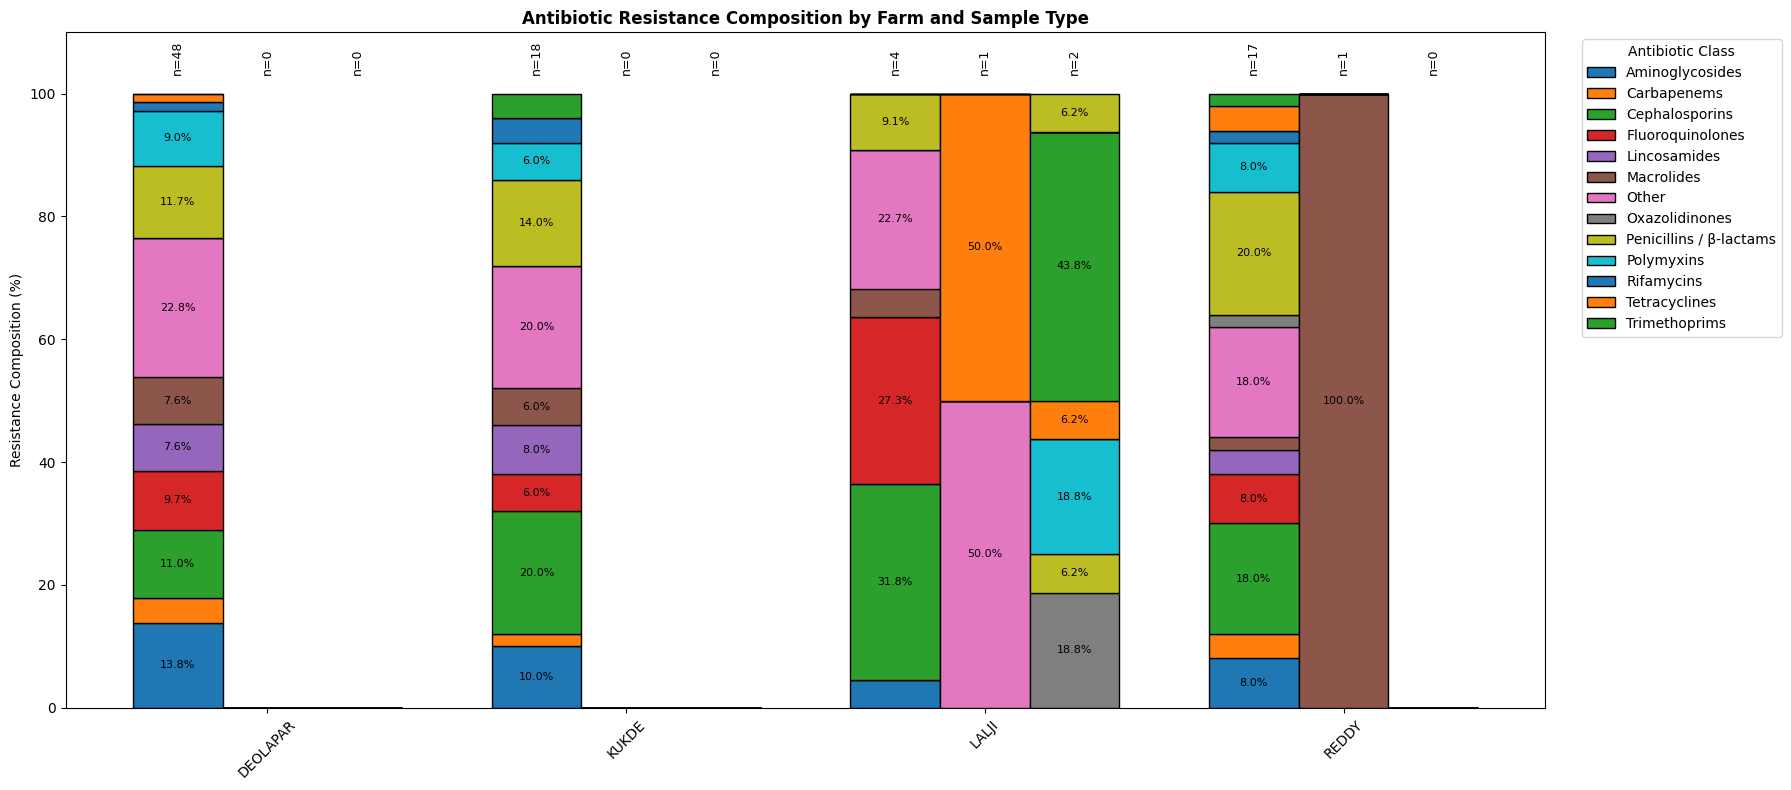

In [6]:
# ============================================================
# FINAL ONE HEALTH AMR RESISTANCE COMPOSITION PIPELINE
# (WITH COLUMN NORMALIZATION – FINAL FIX)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import io
from google.colab import files

# ============================================================
# 0. NORMALIZE COLUMN NAMES (CRITICAL)
# ============================================================

def normalize_columns(df):
    df = df.copy()
    df.columns = (
        df.columns
        .astype(str)
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )
    return df

# ============================================================
# 1. LOAD EXCEL WITH HEADER FIX
# ============================================================

def load_and_fix_excel(file_bytes, source, abx_start=15, abx_end=50):
    df = pd.read_excel(io.BytesIO(file_bytes))

    # Fix antibiotic header row
    abx_names = df.iloc[0, abx_start:abx_end + 1].astype(str)
    df = df.drop(index=0).reset_index(drop=True)

    cols = list(df.columns)
    cols[abx_start:abx_end + 1] = abx_names
    df.columns = pd.Index(cols).astype(str)

    df["Source"] = source

    # 🔑 normalize column names (hidden spaces, line breaks, etc.)
    df = normalize_columns(df)

    return df, abx_start, abx_end


def upload_all_sources():
    data = {}
    for src in ["Human", "Animal", "Environment"]:
        print(f"\nUpload {src} AMR file:")
        up = files.upload()
        fname = list(up.keys())[0]
        data[src] = load_and_fix_excel(up[fname], src)

    human, s, e = data["Human"]
    animal, _, _ = data["Animal"]
    env, _, _ = data["Environment"]

    return human, animal, env, s, e

# ============================================================
# 2. FARM NORMALIZATION
# ============================================================

def canon_farm(x):
    if pd.isna(x):
        return None
    x = str(x).upper()
    x = re.sub(r"[^A-Z0-9 ]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()

    if any(k in x for k in ["LALJI", "NVC", "MAFSU", "MELGHAT"]):
        return "LALJI"
    if "DEOLAPAR" in x:
        return "DEOLAPAR"
    if "KUKDE" in x:
        return "KUKDE"
    if "REDDY" in x:
        return "REDDY"
    return None


def assign_location(df):
    df = df.copy()
    if "Farm Name" in df.columns:
        df["Location"] = df["Farm Name"].apply(canon_farm)
    else:
        df["Location"] = None
    return df


def assign_env_location(df):
    df = df.copy()
    df["Location"] = "LALJI"   # ENV samples → Lalji
    return df

# ============================================================
# 3. ANIMAL RESISTANCE COLUMN (AUTO-DETECTION)
# ============================================================

def find_resistant_count_column(df):
    for c in df.columns:
        c_norm = c.upper().replace(" ", "")
        if "RESISTANT" in c_norm and "AST" in c_norm:
            return c
    return None


def parse_resistant_count(val):
    if pd.isna(val):
        return 0
    digits = "".join(ch for ch in str(val) if ch.isdigit())
    return int(digits) if digits else 0

# ============================================================
# 4. ANTIBIOTIC → CLASS MAP
# ============================================================

CLASS_MAP = {
    "AMOX": "Penicillins / β-lactams",
    "PIPER": "Penicillins / β-lactams",
    "OXACILLIN": "Penicillins / β-lactams",
    "CEF": "Cephalosporins",
    "IMIP": "Carbapenems",
    "MEROP": "Carbapenems",
    "CIPRO": "Fluoroquinolones",
    "LEVO": "Fluoroquinolones",
    "AMIKA": "Aminoglycosides",
    "GENTA": "Aminoglycosides",
    "COLIST": "Polymyxins",
    "LINEZ": "Oxazolidinones",
    "CLINDA": "Lincosamides",
    "ERYTH": "Macrolides",
    "TETRA": "Tetracyclines",
    "RIFAMP": "Rifamycins",
    "TRIMETH": "Trimethoprims",
}

def assign_class(ab):
    ab = str(ab).upper()
    for k, v in CLASS_MAP.items():
        if k in ab:
            return v
    return "Other"

# ============================================================
# 5. BUILD RESISTANT DATASET (SOURCE-AWARE)
# ============================================================

def extract_resistance(human, animal, env, s, e):

    def ast_long(df):
        abx = df.iloc[:, s:e + 1].astype(str).apply(
            lambda x: x.str.strip().str.upper()
        )
        long = pd.concat(
            [df[["Source", "Location", "Sample Code"]], abx],
            axis=1
        ).melt(
            id_vars=["Source", "Location", "Sample Code"],
            var_name="Antibiotic",
            value_name="AST"
        )
        return long[long["AST"] == "R"]

    human_long = ast_long(human)
    animal_long = ast_long(animal)
    env_long = ast_long(env)

    all_long = pd.concat(
        [human_long, animal_long, env_long],
        ignore_index=True
    )

    all_long["Class"] = all_long["Antibiotic"].apply(assign_class)
    return all_long


# ============================================================
# 6. CALCULATE COMPOSITION
# ============================================================

def calculate_composition(long):
    counts = (
        long.groupby(["Location", "Source", "Class"])
        .size()
        .reset_index(name="n")
    )

    totals = (
        counts.groupby(["Location", "Source"])["n"]
        .sum()
        .reset_index(name="total")
    )

    comp = counts.merge(totals, on=["Location", "Source"])
    comp["percent"] = comp["n"] / comp["total"] * 100
    return comp

# ============================================================
# 7. PLOT
# ============================================================

def plot_composition(comp, long):
    farms = sorted(comp["Location"].unique())
    sources = ["Human", "Animal", "Environment"]
    classes = sorted(comp["Class"].unique())

    x = np.arange(len(farms))
    width = 0.25

    fig, ax = plt.subplots(figsize=(18, 8))

    for i, src in enumerate(sources):
        bottom = np.zeros(len(farms))

        for cls in classes:
            vals = [
                comp.loc[
                    (comp.Location == f) &
                    (comp.Source == src) &
                    (comp.Class == cls),
                    "percent"
                ].sum()
                for f in farms
            ]

            ax.bar(
                x + i * width,
                vals,
                width,
                bottom=bottom,
                label=cls if i == 0 else None,
                edgecolor="black"
            )

            for xi, yi, bi in zip(x + i * width, vals, bottom):
                if yi >= 5:
                    ax.text(
                        xi,
                        bi + yi / 2,
                        f"{yi:.1f}%",
                        ha="center",
                        va="center",
                        fontsize=8
                    )

            bottom += np.array(vals)

        # Sample count annotation
        for j, f in enumerate(farms):
            n = long.loc[
                (long.Location == f) & (long.Source == src),
                "Sample Code"
            ].nunique()

            ax.text(
                x[j] + i * width,
                103,
                f"n={n}",
                ha="center",
                va="bottom",
                fontsize=9,
                rotation=90
            )

    ax.set_xticks(x + width)
    ax.set_xticklabels(farms, rotation=45)
    ax.set_ylim(0, 110)
    ax.set_ylabel("Resistance Composition (%)")
    ax.set_title(
        "Antibiotic Resistance Composition by Farm and Sample Type",
        fontweight="bold"
    )

    ax.legend(
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        title="Antibiotic Class"
    )

    plt.tight_layout()
    plt.show()

# ============================================================
# 8. RUN PIPELINE
# ============================================================

human, animal, env, s, e = upload_all_sources()

human = assign_location(human)
animal = assign_location(animal)
env = assign_env_location(env)

long = extract_resistance(human, animal, env, s, e)
composition = calculate_composition(long)

print("\nSANITY CHECK — resistant isolates by source")
print(long.groupby("Source")["Sample Code"].nunique())
print("==========================================")

plot_composition(composition, long)
